Run this cell first, and modify the `DIRECTORY` string as necessary

In [6]:
from google.colab import drive
drive.mount('/content/drive')
DIRECTORY = '/content/drive/MyDrive/2021_a_final/Github'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Licenses

In [7]:
#@title ##### GraphNets License { form-width: "50%" }
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

In [8]:
#@title ##### Modified Notice - MCMB Lab { form-width: "50%" }
# The GraphNets framework has been modified by:
# Multiscale Computational Mechanics and Biomechanics LAB (MCMB Lab)
# Department of Mechanical Engineering and Mechanics
# Drexel University, Philadelphia, Pennsylvania 
# Diroctor: Ahmad Raeisi Najafi (Ph.D.)
# All rights reserved.
# Developer: Nolan Black 10/2020
# Created in: 10/2020
# Last modified in: 2021
# ============================================================================

# Load Functions

In [9]:
FUNCTIONS = '{}/Functions.ipynb'.format(DIRECTORY)
%run $FUNCTIONS

Installing Graph Nets library and dependencies:
Output message from command:

Tensor Flow Version: 1.15.5
GPU is NOT AVAILABLE


# Data Generation
Here we can pre-generate training data and pickle the graphs objects to our Drive directory for later use. 

In [10]:
start_time = time.time()
#Initialize model and domain
# reset the default graph and set seed for randmoization
tf.reset_default_graph()

# Domain initialization
# mesh is m1 elements along x, m2 elements along y
# mesh defined by m1 x m2, convergence near 40 x 20
elem_type = "quad" # "tri" or "quad"
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

force_dofs = [0, 1]
applied_force_vals = [1e7, 1e7]
body_force = [0.0, 0.0]
########################################################################

# Data / training parameters.
fetch_size = 2  # the number of files to save in the directory
data_size_tr = fetch_size # the number of fea examples in each file
batch_size_tr = 1 #keep 1
m1_min_max_tr = (8, 12) #integer
m2_min_max_tr = (4, 7) #integer
refine_fact_tr = (0.0, 0.5) # for tri only, n_elem = (2+fract)*(m1 * m2) 
# Mesh Noise
if elem_type == "tri" :
  coord_noise_min_max_tr = (0.0, 0.1)#float, over 0.25 gets crazy
else :
  coord_noise_min_max_tr = (0.0, 0.0) #float, over 0.4 gets crazy
noise_type_tr = "posi" # "posi" or "row" 
vol_frac_min_max = (1.0, 1.0) #unused
density_min_max = (1.0, 1.0) # unused 
multiscale_min_max_m1 = (2, 7) # the dimensions of the subgraph 
multiscale_min_max_m2 = (2, 7) 
force_scale = (-1.0, 1.0) # used in scaling the force value

support_options = ["left_cantilever", "right_cantilever", "dual_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center", "top_center", "top_distributed"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = True, False, True, True
########################################################################

dirname = 'test_datagen'


for fetch_iter in range(0, fetch_size) :
  print(fetch_iter)
  print("Generating data....", end = ' ')
  # True physics simulator for ground truth generation.
  def_time_0 = time.time()
  # rand = np.random.RandomState(fetch_iter)
  np.random.seed(fetch_iter)

  raw_tr, input_graph_list_tr, simulated_graph_list_tr, graph_recovery = generate_data(data_size_tr, m1_min_max_tr, m2_min_max_tr, refine_fact_tr, vol_frac_min_max, density_min_max, 
                                                                                noise_type_tr, coord_noise_min_max_tr, support_options, force_options,
                                                                                multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
                                                                                elem_type, bound_x, bound_y, E, v, 
                                                                                applied_force_vals, force_dofs, body_force, multiscale_min_max_m1, multiscale_min_max_m2, force_scale)
  
  initial_conditions_tr, true_deformation_tr  = generate_raw_data(input_graph_list_tr, simulated_graph_list_tr, batch_size_tr )
  training_time = time.time() - def_time_0
  print("...Training data ready in {}m {}s".format(int(training_time//60), int(training_time % 60)))

  # Optimizer.
  opt_start = time.time()
  print("Setting optimizer...", end = ' ')
  try:
    sess.close()
  except NameError:
    pass

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  input_graph_tr = sess.run(initial_conditions_tr)
  target_tr = sess.run(true_deformation_tr)

  net_time = time.time() - opt_start
  print("...Complete Optimizer ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))

  # save graphtups
  with open('{}/{}/inputs/{}'.format(DIRECTORY, dirname, fetch_iter), 'wb') as f :
    dill.dump(input_graph_tr, f) 

  with open('{}/{}/outputs/{}'.format(DIRECTORY, dirname, fetch_iter), 'wb') as f :
    dill.dump(target_tr, f) 
    
  with open('{}/{}/recovery/{}'.format(DIRECTORY, dirname, fetch_iter), 'wb') as f :
    dill.dump(graph_recovery, f) 

  del input_graph_tr
  del target_tr
  del initial_conditions_tr
  del true_deformation_tr
  del input_graph_list_tr
  del simulated_graph_list_tr
  del graph_recovery
  del raw_tr
  tf.reset_default_graph()

  net_time = time.time() - def_time_0
  print("Fetch ready in {}m {}s\n".format(int(net_time//60), int(net_time % 60)))

net_time = time.time() - start_time
print("...Datalog ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))

0
Generating data.... 
Stat mesh: 8 x 4 || Father mesh: 24 x 8 || Child mesh: 144 x 16 || Force Vals: 10000000.0000, -10000000.0000 || right_cantilever, top_center || [0.0, 2.2] x [-0.8, 0.8]
Projection Error: avg 0.0527, max 3.9533, min -0.5286
Pass:  0.0001121794419202748

Stat mesh: 8 x 6 || Father mesh: 24 x 18 || Child mesh: 96 x 72 || Force Vals: -10000000.0000, 0.0000 || left_cantilever, top_distributed || [0.0, 1.9] x [-0.9, 0.9]
Projection Error: avg 0.0524, max 4.4425, min -0.7140
Pass:  0.00012237953998842123
...Training data ready in 0m 50s
Setting optimizer... ...Complete Optimizer ready in 0m 2s
Fetch ready in 0m 53s

1
Generating data.... 
Stat mesh: 8 x 4 || Father mesh: 24 x 12 || Child mesh: 144 x 60 || Force Vals: 10000000.0000, -10000000.0000 || left_cantilever, top_distributed || [0.0, 2.6] x [-0.6, 0.6]
Projection Error: avg 0.0493, max 2.9642, min -0.4084
Pass:  0.00043754909184825293

Stat mesh: 8 x 4 || Father mesh: 24 x 8 || Child mesh: 48 x 16 || Force Vals: 

## Validate data gen
Here you may verify the randomization techniques used in generating training data function properly (i.e. looping does not reset the seed)

In [11]:
test_data_size = 2
raw_tr, input_graph_list_tr, simulated_graph_list_tr, graph_recovery = generate_data(test_data_size, m1_min_max_tr, m2_min_max_tr, refine_fact_tr, vol_frac_min_max, density_min_max, 
                                                                              noise_type_tr, coord_noise_min_max_tr, support_options, force_options,
                                                                              multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
                                                                              elem_type, bound_x, bound_y, E, v, 
                                                                              applied_force_vals, force_dofs, body_force, multiscale_min_max_m1, multiscale_min_max_m2, force_scale)



Stat mesh: 10 x 4 || Father mesh: 30 x 12 || Child mesh: 150 x 48 || Force Vals: 10000000.0000, 10000000.0000 || right_cantilever, top_distributed || [0.0, 1.8] x [-0.5, 0.5]
Projection Error: avg 0.0448, max 1.9153, min -0.5050
Pass:  0.00034174141935608524

Stat mesh: 10 x 6 || Father mesh: 20 x 18 || Child mesh: 120 x 54 || Force Vals: -10000000.0000, 10000000.0000 || dual_cantilever, top_distributed || [0.0, 3.8] x [-0.7, 0.7]
Projection Error: avg 0.0623, max 1.4710, min -0.3227
Pass:  4.265680289515411e-05


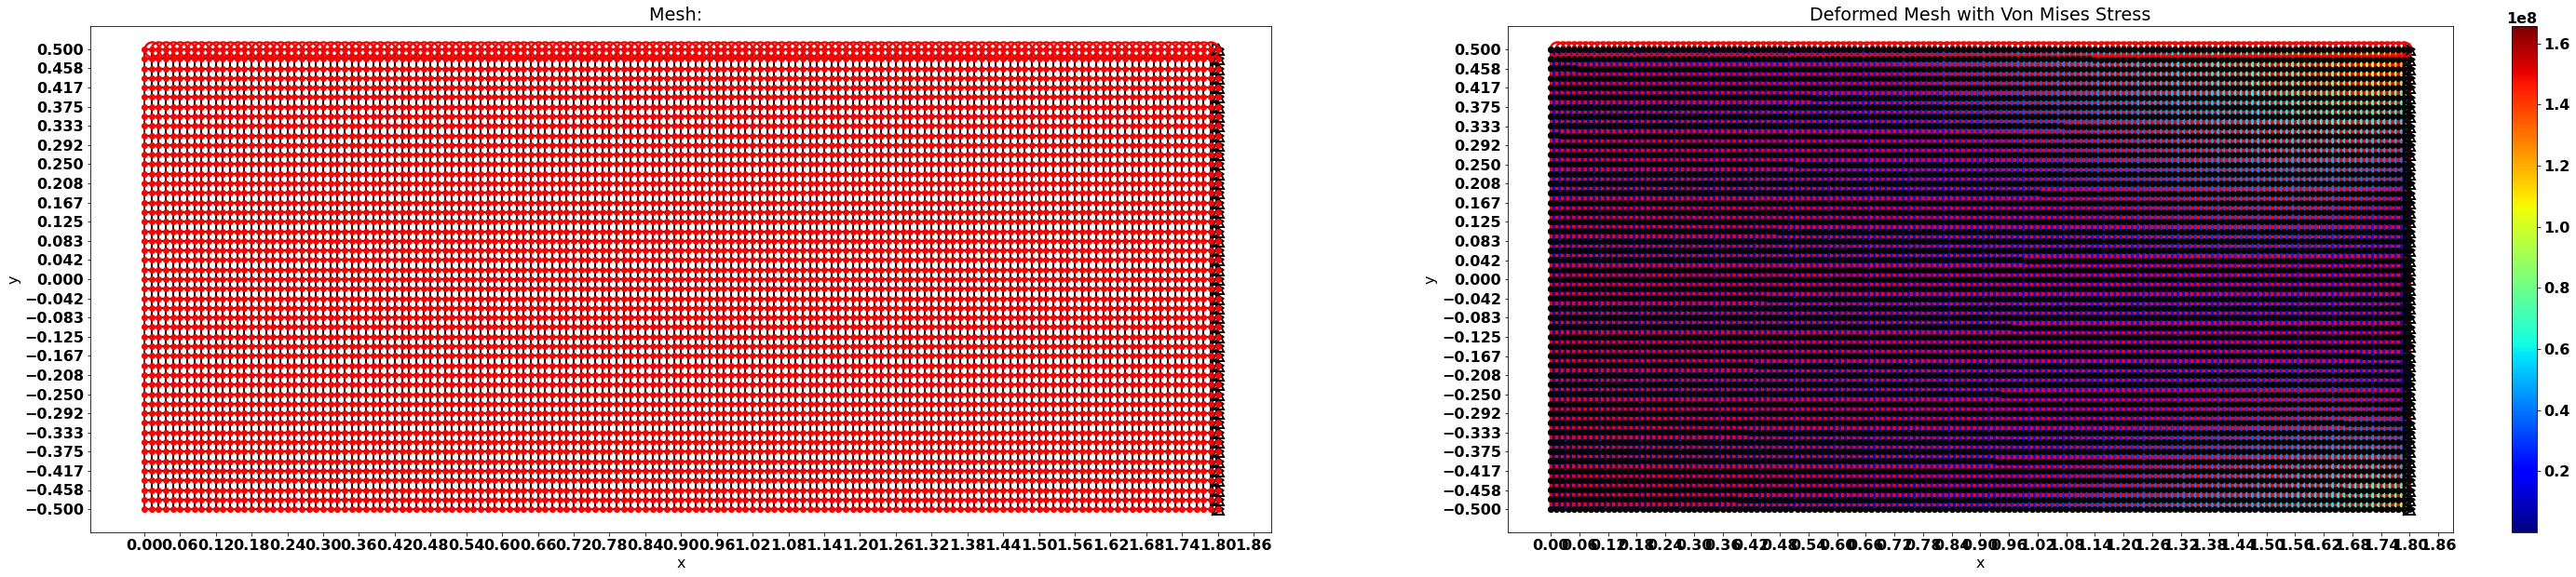

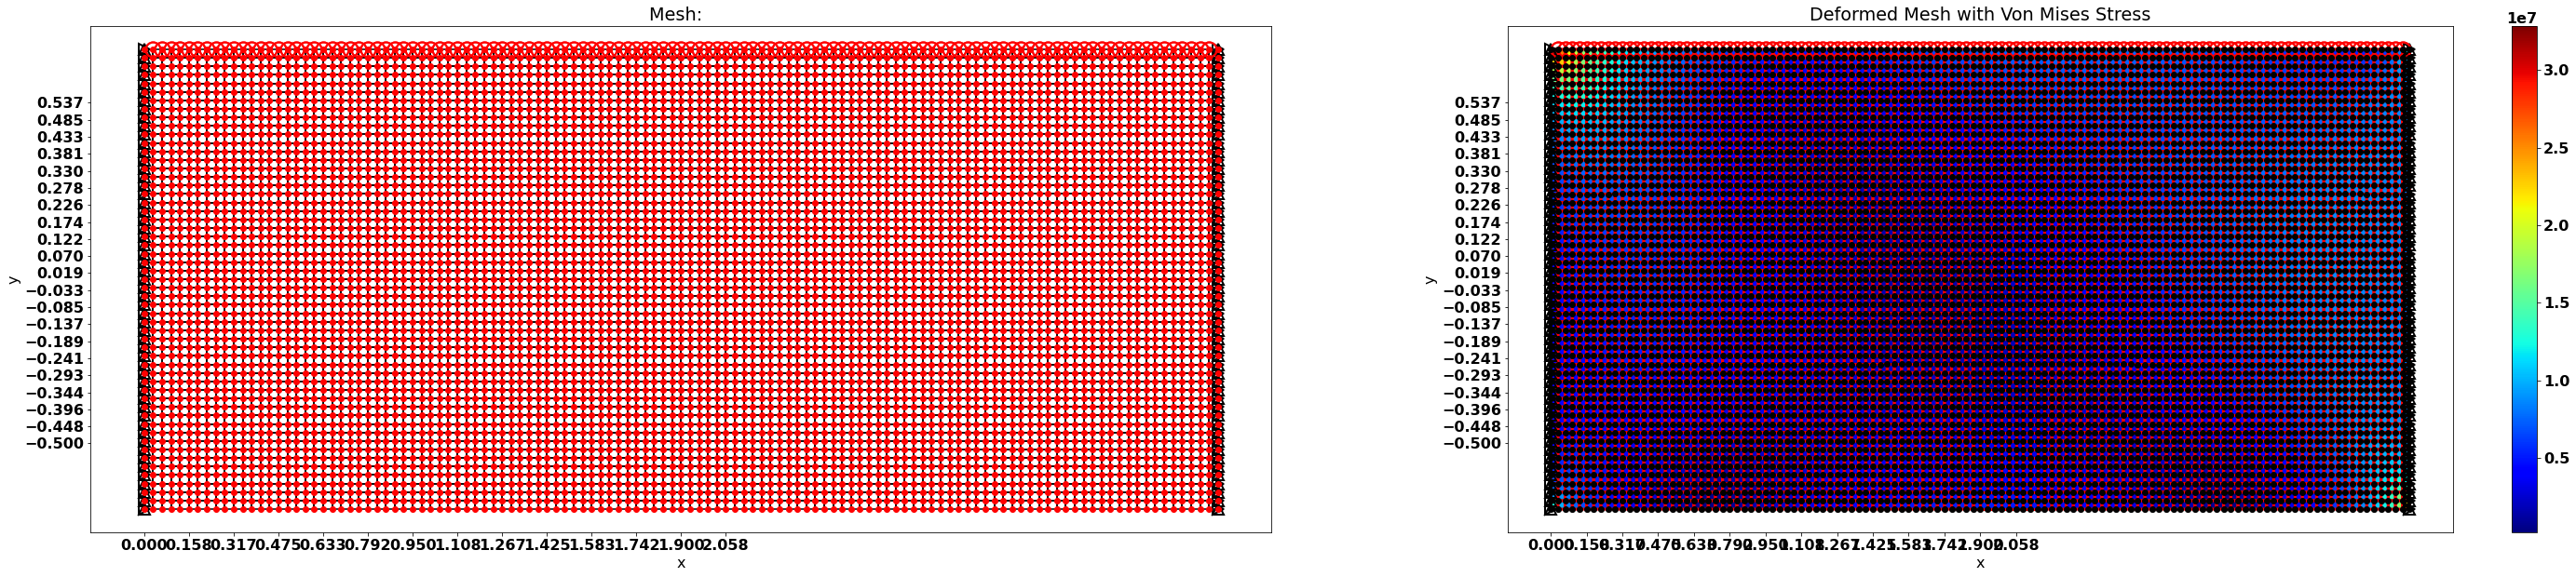

In [12]:
for i in range(test_data_size) :
  mesh_1, bc_1, results_1 = raw_tr[i][0], raw_tr[i][1], raw_tr[i][4]
  element_density_1 = [1]*mesh_1.n_elem
  base_density_1 = [1]*mesh_1.n_elem
  surf_nodes_1  = [1]*mesh_1.n_node
  void_nodes_1  = [1]*mesh_1.n_node
  base_material_1 = assign_material(elem_type, mesh_1, E, v, element_density_1)
  nodal_stress_1, elem_stress_1 = get_stress_gauss(elem_type, mesh_1, base_material_1, results_1)

  plot_mesh(elem_type, False, " ", bound_x, bound_y,
            mesh_1, bc_1, results_1.UUR, elem_stress_1.T[-1,...])

# Dataset Stats
Here we can pre-generate training data and pickle the graphs objects to our Drive directory for later use. 

In [ ]:
dirname = 'test_datagen'

print("Starting Normalization...")
start_time = time.time()

# Note: fetch_stats() requires at least 10 examples to generate dataset stats
node_means, node_stds, edge_means, edge_stds = fetch_stats(
    '{}/{}/inputs/'.format(DIRECTORY, dirname))
node_means_target, node_stds_target, edge_means_target, edge_stds_target = fetch_stats(
    '{}/{}/outputs/'.format(dirname))

with open('{}/{}/input_stats'.format(DIRECTORY, dirname), 'wb') as f :
  dill.dump([node_means, node_stds, edge_means, edge_stds], f)

with open('{}/{}/output_stats'.format(DIRECTORY, dirname), 'wb') as f :
  dill.dump([node_means_target, node_stds_target, edge_means_target, edge_stds_target], f)

net_time = time.time() - start_time
print("...Normalization ready in {}m {}s".format(int(net_time//60), int(net_time % 60))) 

# Validation
The following examples will visualize various plotting functions and may be used to experiment with the randomization parameters used for training data generation.

## FEA Example

Residual of Reaction: 1.1567026376724243e-06


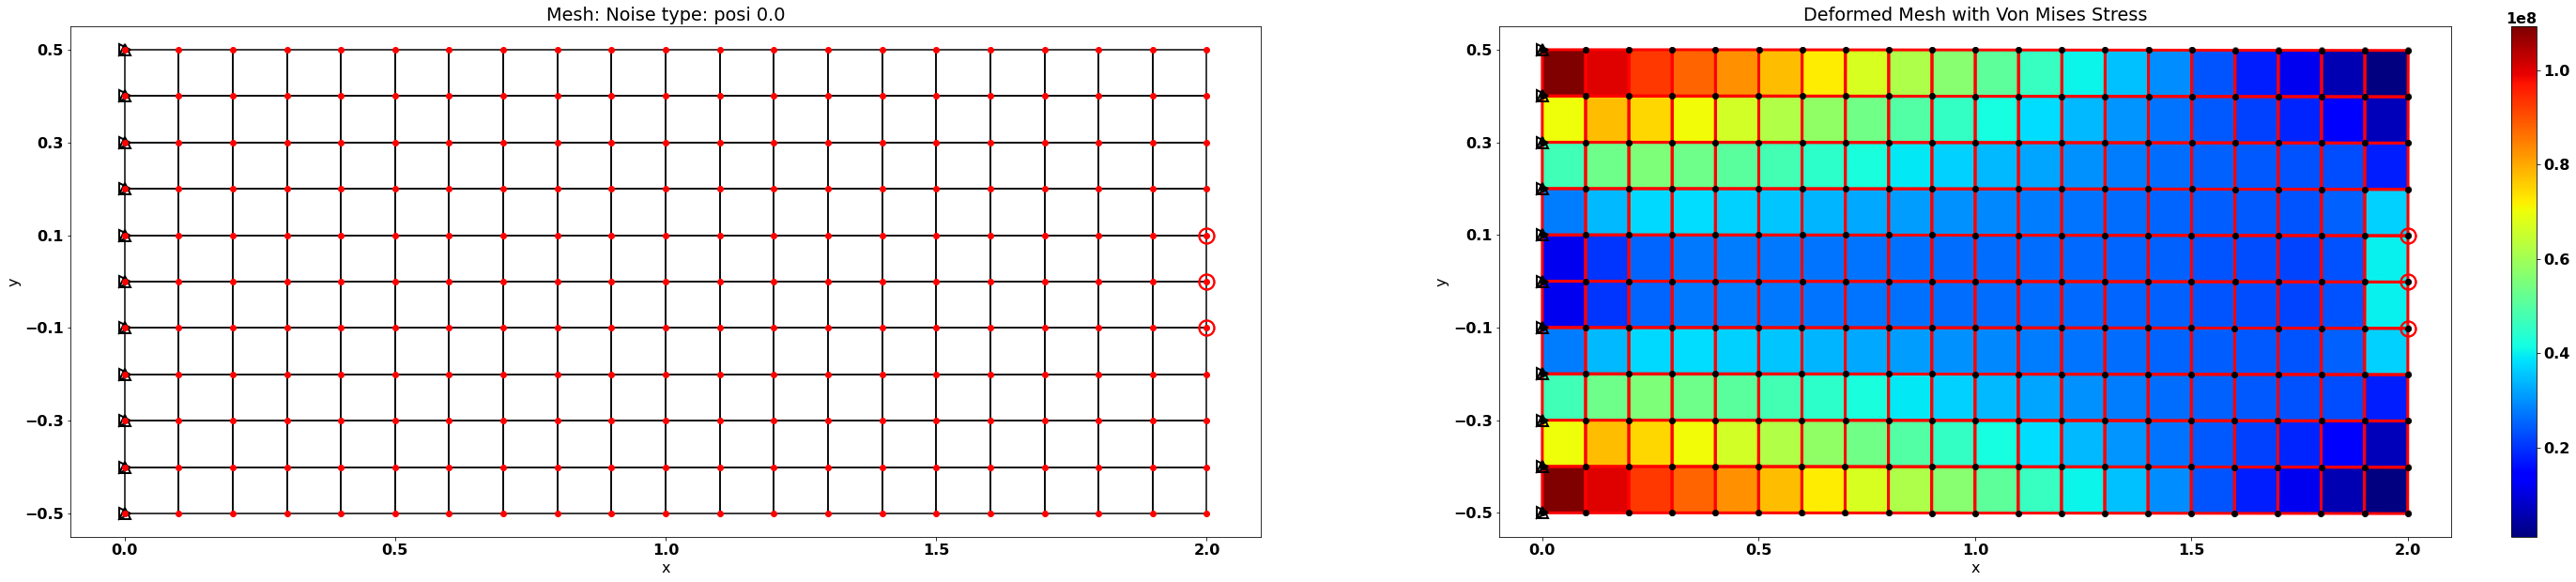

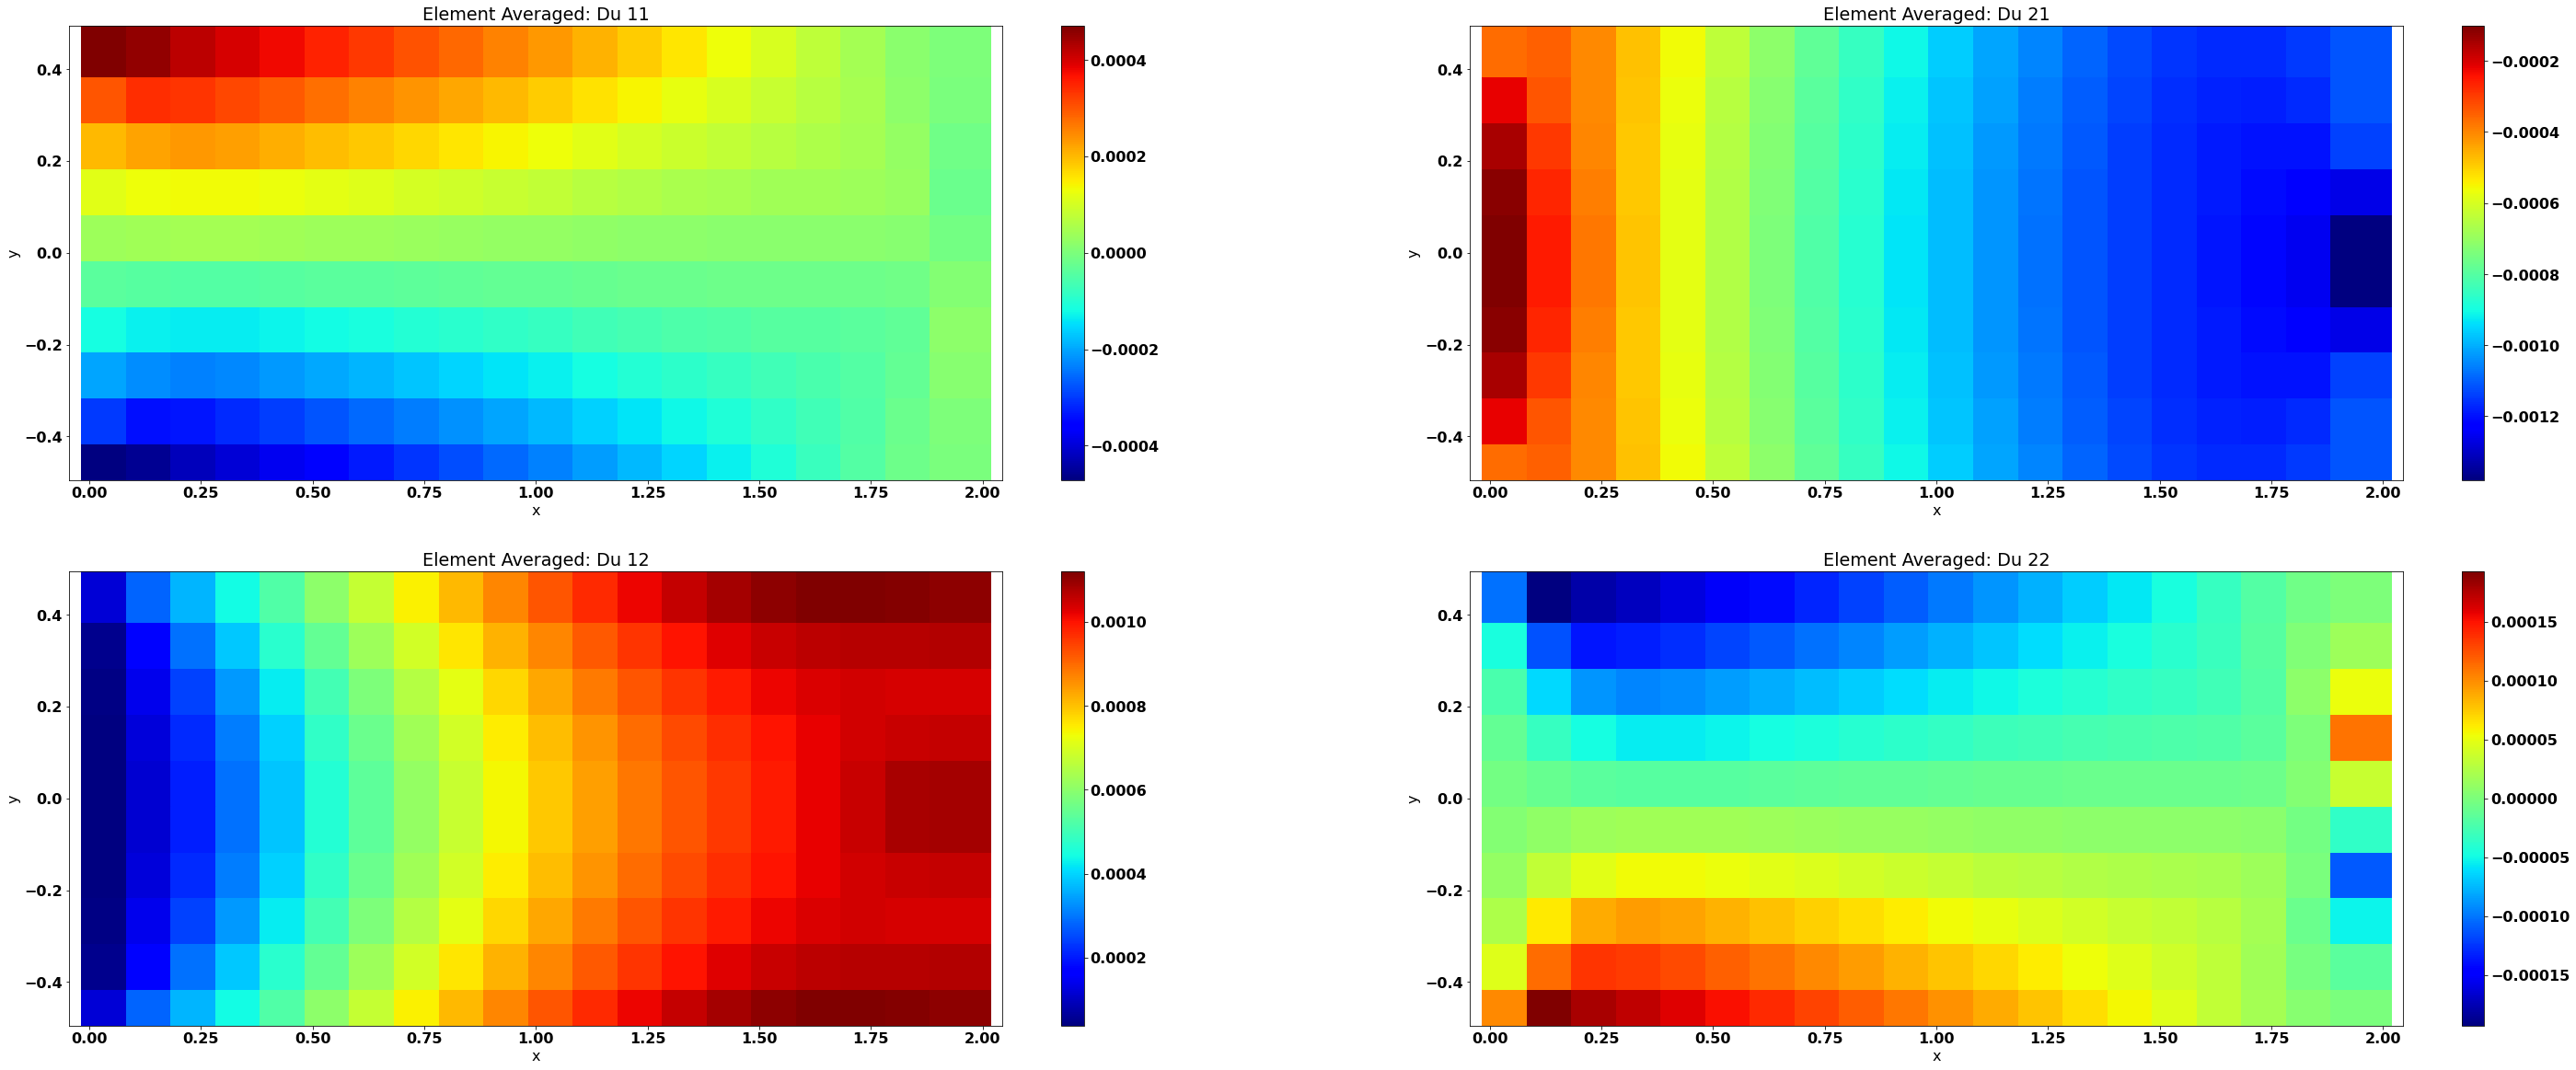

In [18]:
elem_type = "quad"
E = 200e9
v = 0.3
applied_force_dofs = [0, 1]
applied_force_vals = [0, -1e7]
body_force = [0.0, 0.0]
m1 = 20
m2 = 10
bound_x = [0.0, 2.0]
bound_y = [-0.5, 0.5]

noise_type = "posi" # "posi" or "row"
support_option = "left_cantilever" # left_cantilever, right_cantilever, dual_cantilever, MBB
force_option = "side_center" # side_center, side_bottom, side_top, top_center, top_distributed
noise_coord_scale = 0.0

efficient_opt = True
mesh = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                  "posi", noise_coord_scale, 0.0)
base_density = [1]*mesh.n_elem
base_material = assign_material(elem_type, mesh, E, v, base_density)
bc = assign_BC_option(mesh, applied_force_vals, applied_force_dofs, body_force,
                     support_option, force_option)
fea = assemble_matrices(elem_type, mesh, base_material, bc, efficient_opt)
results = solve_FEA(mesh, bc, fea)
print("Residual of Reaction: {}".format(sum(results.R[...,0]) + applied_force_vals[1]))

nodal_stress, elem_stress = get_stress_gauss(elem_type, mesh, base_material, results)
nodal_du, elem_du = get_dU_gauss(elem_type, mesh, results.UUR.T )

annotations = False
alternate_title = "Noise type: " + noise_type + " " + str(noise_coord_scale)
plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh, bc, results.UUR, elem_stress.T[-1,...])
title= "Element Averaged: Du"
plot_elem_attr(elem_type, title, mesh, elem_du)

# x, y = np.asarray(mesh.coords).T
# z = results.UUR.T[..., 0]
# plot_nodal_vect(x, y, z, " ")
# z = results.UUR.T[..., 1]
# plot_nodal_vect(x, y, z, " ")

## Global Graph Example

In [19]:
M1 = 8
M2 = 4
refine_fract = 0.0
noise_type, noise_coord_scale = "posi", 0.0

force_vals, force_dofs = applied_force_vals, applied_force_dofs

multiscale_min_max_m1 = (4,6)
multiscale_min_max_m2 = multiscale_min_max_m1

In [20]:
mesh_0 = build_mesh(elem_type, M1, M2, bound_x, bound_y,
              "posi", 0.0, refine_fract)
element_density_0 = [1]*mesh_0.n_elem
surf_nodes_0  = [1]*mesh_0.n_node
void_nodes_0  = [1]*mesh_0.n_node
base_material_0 = assign_material(elem_type, mesh_0, E, v, element_density_0)
bc_0 = assign_BC_option(mesh_0, force_vals, force_dofs, body_force,
                  support_option, force_option)
fea_0 = assemble_matrices(elem_type, mesh_0, base_material_0, bc_0, efficient_opt)
results_0 = solve_FEA(mesh_0, bc_0, fea_0)
nodal_stress_0, elem_stress_0 = get_stress_gauss(elem_type, mesh_0, base_material_0, results_0)
nodal_du_0, elem_du = get_dU_gauss(elem_type, mesh_0, results_0.UUR.T )

m1_p = M1*np.random.randint(multiscale_min_max_m1[0]//2, multiscale_min_max_m1[1]//2)
m2_p = M2*np.random.randint(multiscale_min_max_m2[0]//2, multiscale_min_max_m2[1]//2)
mesh_p = build_mesh(elem_type, m1_p, m2_p, bound_x, bound_y,
                  "posi", 0.0, refine_fract)
element_density_p = [1]*mesh_p.n_elem
surf_nodes_p  = [1]*mesh_p.n_node
void_nodes_p  = [1]*mesh_p.n_node
base_material_p = assign_material(elem_type, mesh_p, E, v, element_density_p)
bc_p = assign_BC_option(mesh_p, force_vals, force_dofs, body_force, support_option, force_option)
fea_p = assemble_matrices(elem_type, mesh_p, base_material_p, bc_p, efficient_opt)
results_p = solve_FEA(mesh_p, bc_p, fea_p)
nodal_stress_p, elem_stress_p = get_stress_gauss(elem_type, mesh_p, base_material_p, results_p)
nodal_du_p, elem_du = get_dU_gauss(elem_type, mesh_p, results_p.UUR.T )


m1 = m1_p*np.random.randint(multiscale_min_max_m1[0], multiscale_min_max_m1[1])
m2 = m2_p*np.random.randint(multiscale_min_max_m2[0], multiscale_min_max_m2[1])
print("\nStat mesh: {} x {}".format(M1, M2), end = " || ")
print("Father mesh: {} x {}".format(m1_p, m2_p), end = " || ")
print("Child mesh: {} x {}".format(m1, m2), end = " || ")
print("Force Vals: {:.4f}, {:.4f}".format(force_vals[0], force_vals[1]), end = " || ")
print("{}, {}".format(support_option , force_option), end = " || ")
print(bound_x, "x",  bound_y)
mesh_1 = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                  "posi", 0.0, refine_fract)
base_coords = copy.deepcopy(mesh_1.coords)
mesh_1.coords = noise_mesh_MS(noise_type, noise_coord_scale, mesh_0, mesh_1)
print("WARNING: NO mesh noise")
element_density_1 = [1]*mesh_1.n_elem
base_density_1 = [1]*mesh_1.n_elem
surf_nodes_1  = [1]*mesh_1.n_node
void_nodes_1  = [1]*mesh_1.n_node
base_material_1 = assign_material(elem_type, mesh_1, E, v, element_density_1)
bc_1 = assign_BC_option(mesh_1, force_vals, force_dofs, body_force,
                  support_option, force_option)
fea_1 = assemble_matrices(elem_type, mesh_1, base_material_1, bc_1, efficient_opt)
results_1 = solve_FEA(mesh_1, bc_1, fea_1)
nodal_stress_1, elem_stress_1 = get_stress_gauss(elem_type, mesh_1, base_material_1, results_1)
nodal_du_1, _ = get_dU_gauss(elem_type, mesh_1, results_1.UUR.T )

father_elems_0, graph_nodes_0 = dual_mesh_pre_process(mesh_0, mesh_1)
father_elems, graph_nodes = dual_mesh_pre_process(mesh_p, mesh_1)

input_graph_0 = get_input_graph(elem_type, mesh_0, bc_0, element_density_0, surf_nodes_0, void_nodes_0)
output_graph_0 = get_output_graph(elem_type, input_graph_0, mesh_0, results_0, nodal_stress_0, nodal_du_0)

input_graph_p = get_input_graph(elem_type, mesh_p, bc_p, element_density_p, surf_nodes_p, void_nodes_p)
output_graph_p = get_output_graph(elem_type, input_graph_p, mesh_p, results_p, nodal_stress_p, nodal_du_p)

input_graph_1 = get_input_graph_dual_informed(elem_type, mesh_1, bc_1, element_density_1, surf_nodes_1, void_nodes_1,
                            father_elems_0, father_elems, graph_nodes,
                            mesh_p, output_graph_p) 
output_graph_1 = get_output_graph_informed(elem_type, input_graph_1, mesh_1, results_1, nodal_stress_1, nodal_du_1)

err_projection, avg_err_tst, max_tst, min_tst = get_disp_err(results_1.UUR.T, input_graph_1["nodes"][..., 10:12])
print("Projection Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))



Stat mesh: 8 x 4 || Father mesh: 16 x 8 || Child mesh: 64 x 40 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || [0.0, 2.0] x [-0.5, 0.5]
Projection Error: avg 0.0690, max 3.3006, min -0.3942


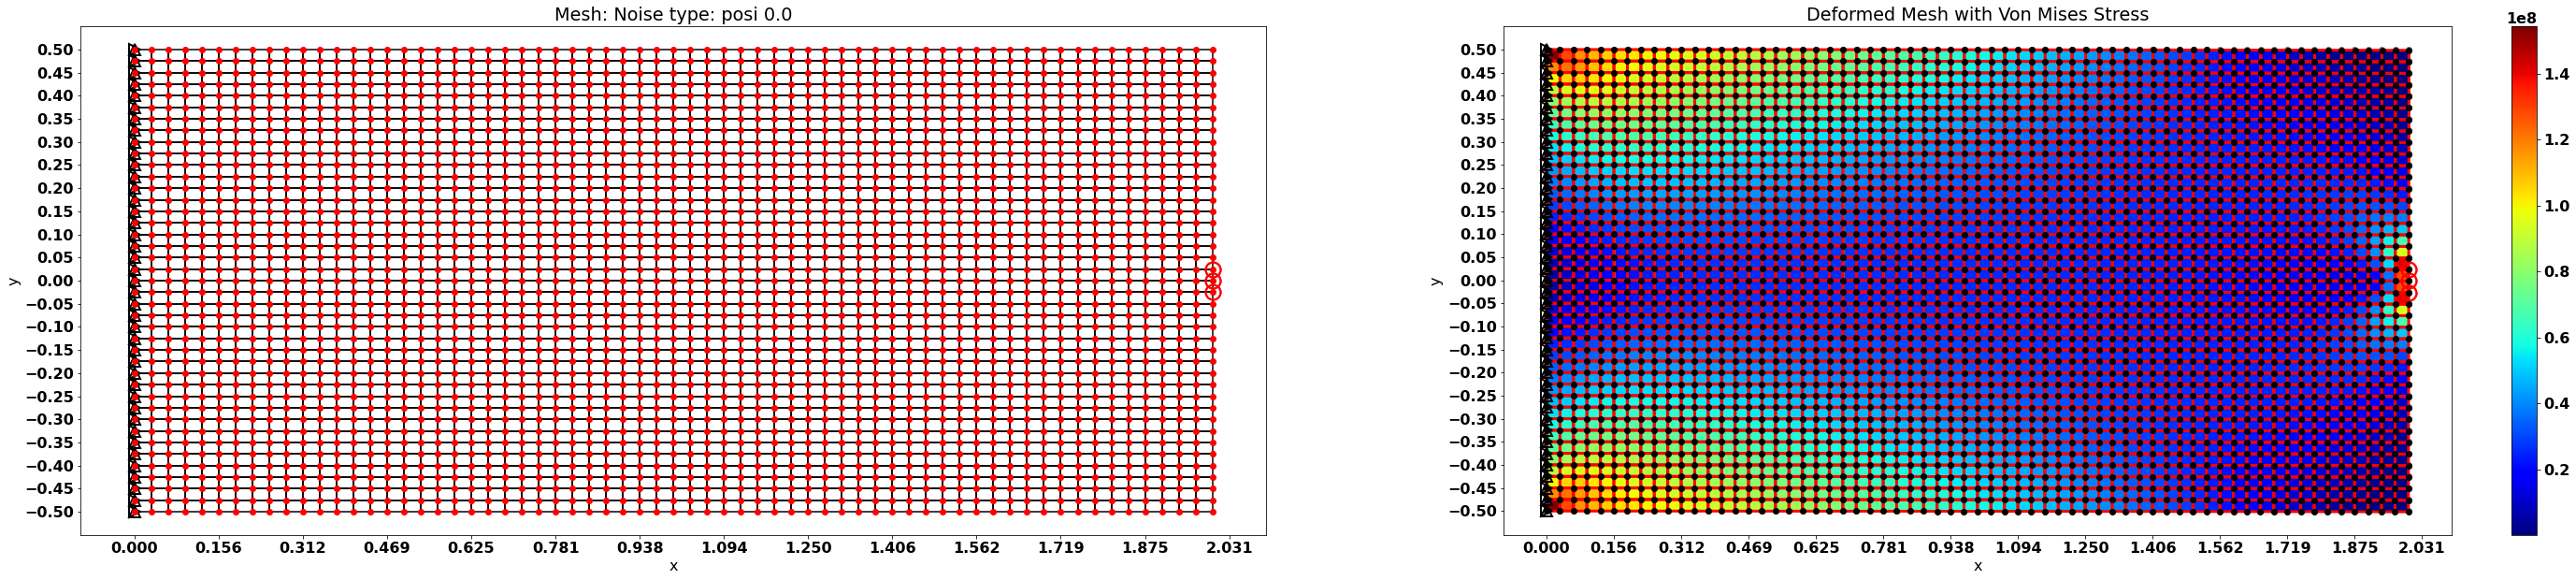

In [21]:
plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_1, bc_1, results_1.UUR, elem_stress_1.T[-1,...])

delta_projection error = 7.450580596923828e-09
Edge Recovery Error: avg 0.0510, max 1.3449, min -0.4172
edge recovery is not an exact function in this form, just make sure it doesn't blow up


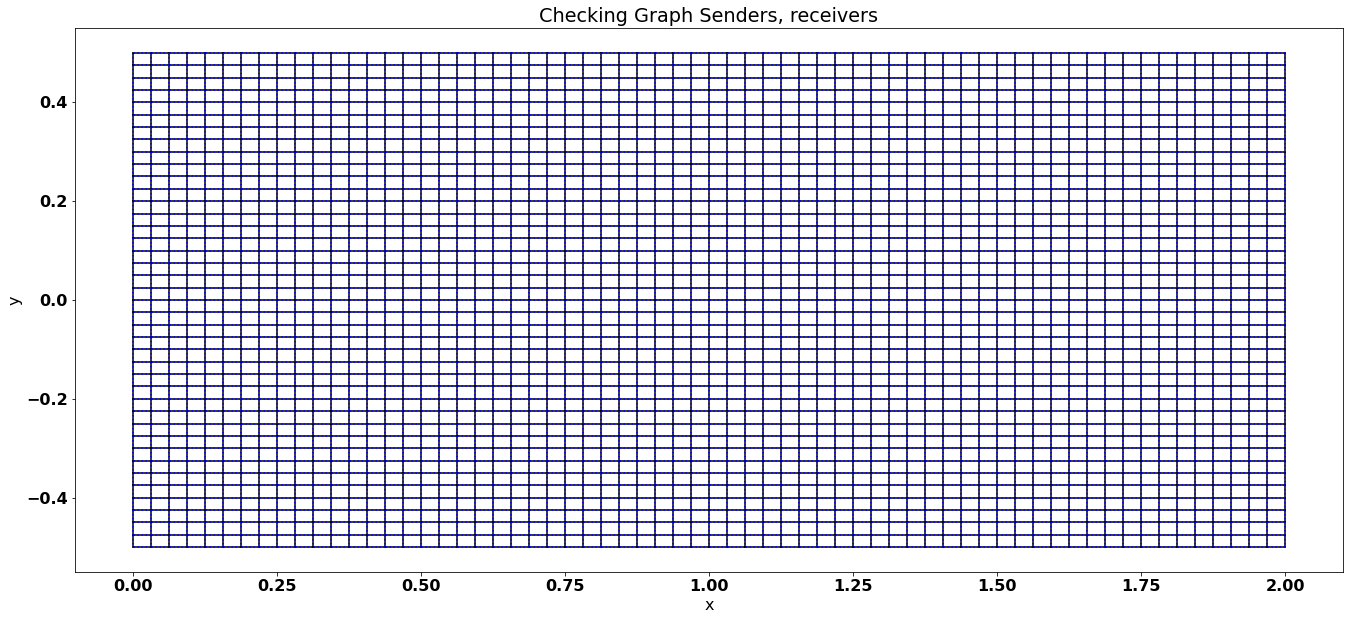

In [22]:
projected_values = input_graph_1["nodes"][..., 10:19]
fine_values = output_graph_1["nodes"][..., 0:9]
delta_projection = output_graph_1["nodes"][..., 9:18]

print("delta_projection error = {}".format(np.amax(np.abs(projected_values + delta_projection - fine_values))))

output_nodes = copy.deepcopy(output_graph_1["nodes"][..., 0:9])
for i, (send, rec) in enumerate(zip(input_graph_1["senders"], input_graph_1["receivers"])) :
  output_nodes[send,...] +=  (output_nodes[rec,...] - output_graph_1["edges"][i,8:17])
  output_nodes[send,...] /= 2

err_projection, avg_err_tst, max_tst, min_tst = get_disp_err(results_1.UUR.T, output_nodes[...,0:2])
print("Edge Recovery Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))
print("edge recovery is not an exact function in this form, just make sure it doesn't blow up")

fig = plt.figure(1, figsize=(50, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Checking Graph Senders, receivers") 
ax.set_ylabel('y')
ax.set_xlabel('x')
for i, (send, rec) in enumerate(zip(input_graph_1["senders"], input_graph_1["receivers"])) :
  x0, y0 = input_graph_1["nodes"][send,0:2]
  x1, y1 = input_graph_1["nodes"][rec,0:2]
  if i % 2 == 0 :
    ax.plot([x0, x1], [y0, y1], c = 'k')
  else :
    ax.plot([x0, x1], [y0, y1], ':', c = 'b')

## MF Graph Example

In [32]:
input_sub_graph_list = []
output_sub_graph_list = []
graph_edges = []
for elem in range(mesh_0.n_elem) :
  graph_node_list = graph_nodes_0[elem]
  father_elem_node_list = father_elems_0[elem]

  ig, edge_id_list = get_input_graph_multiscale_informed(elem, input_graph_0, input_graph_1, output_graph_0, output_graph_1, 
                                                        graph_node_list, father_elem_node_list, mesh_0)
  og = get_output_graph_multiscale_informed(ig, output_graph_1, graph_node_list, edge_id_list)

  graph_edges.append(edge_id_list)
  input_sub_graph_list.append(ig)
  output_sub_graph_list.append(og)

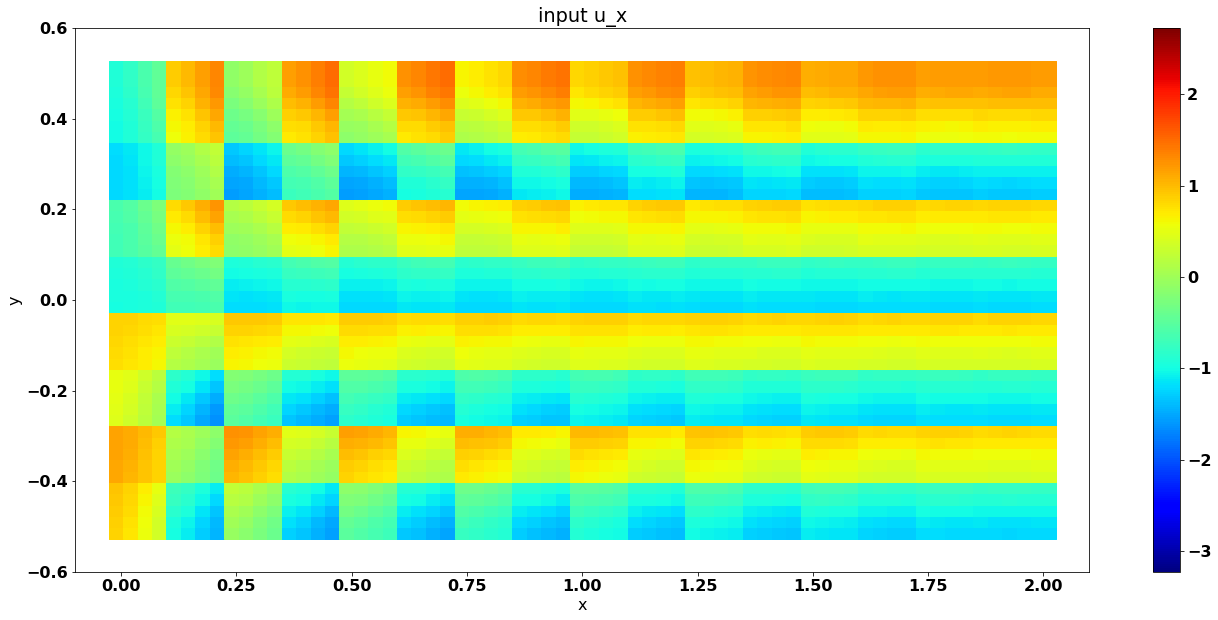

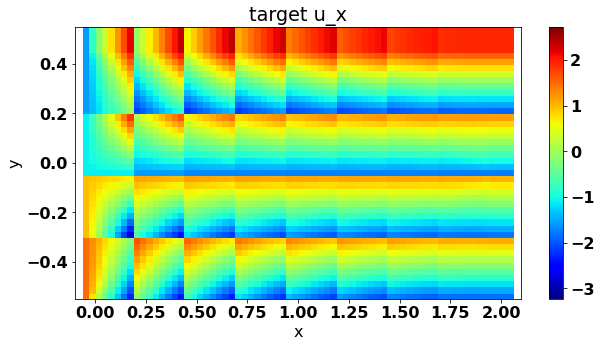

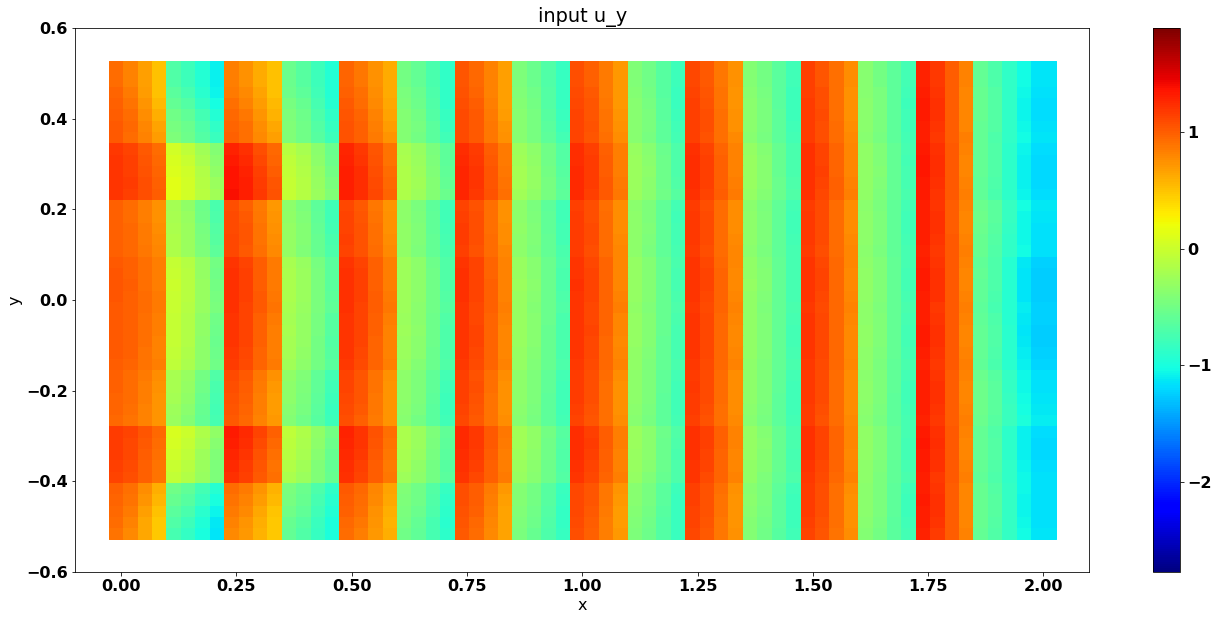

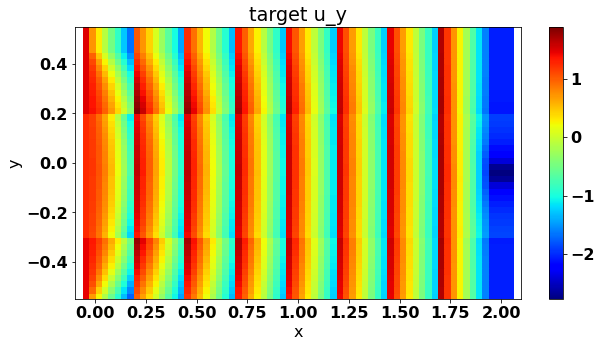

In [33]:
normalized_input_list, local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list = normalize_input_list_informed_multiscale(input_sub_graph_list, [0]*10, [1]*10)
normalized_target_list = local_standard_target(output_sub_graph_list,  local_mean_list, local_std_list)


input_nodes = np.concatenate([item["nodes"]for item in normalized_input_list])
target_nodes = np.concatenate([item["nodes"]for item in normalized_target_list])

plot_capped_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                input_nodes[..., 10], "input u_x", 6e2, np.min(target_nodes[..., 0]), np.max(target_nodes[..., 0]))
plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                target_nodes[..., 0], "target u_x", 6e2)
plot_capped_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                input_nodes[..., 11], "input u_y", 6e2, np.min(target_nodes[..., 1]), np.max(target_nodes[..., 1]))
plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                target_nodes[..., 1], "target u_y", 6e2)

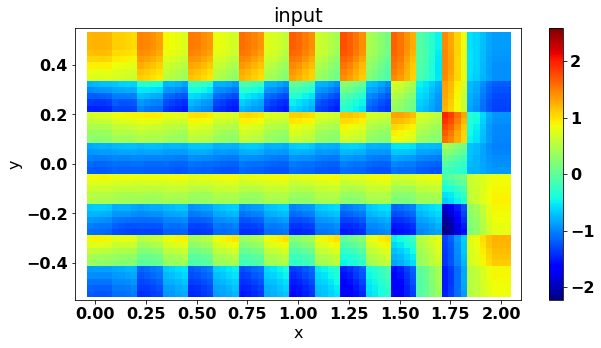

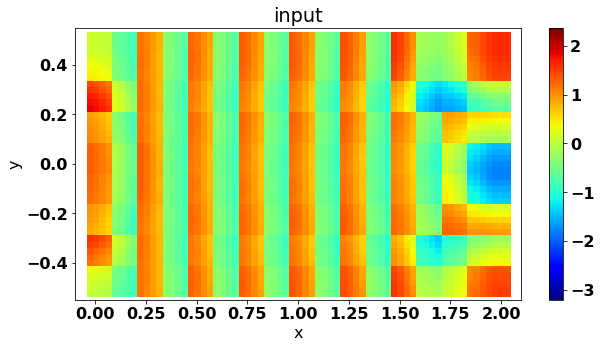

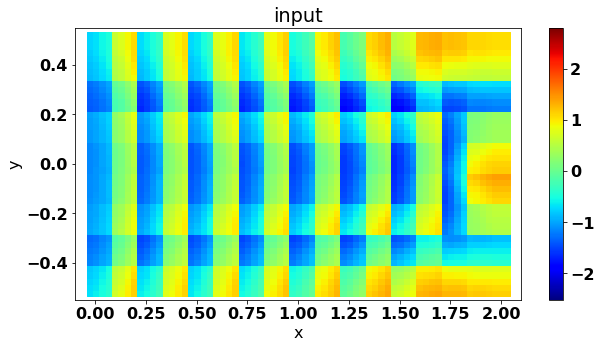

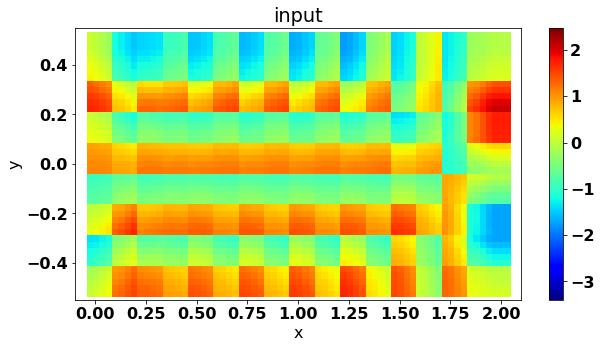

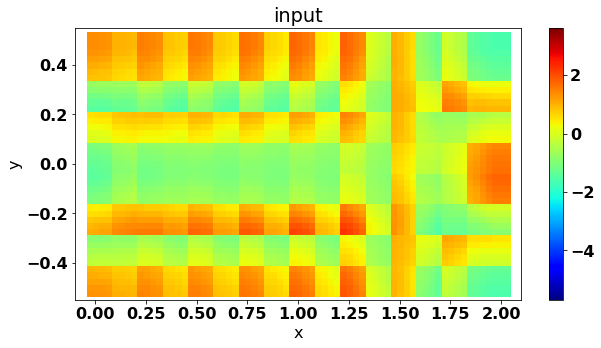

In [34]:
for i in range(5) :
  plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                  input_nodes[..., 14 + i], "input", 3e2) 

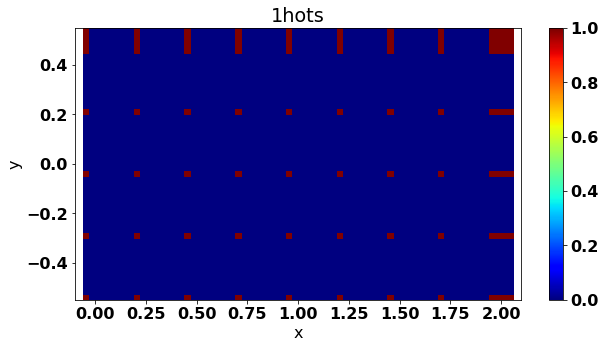

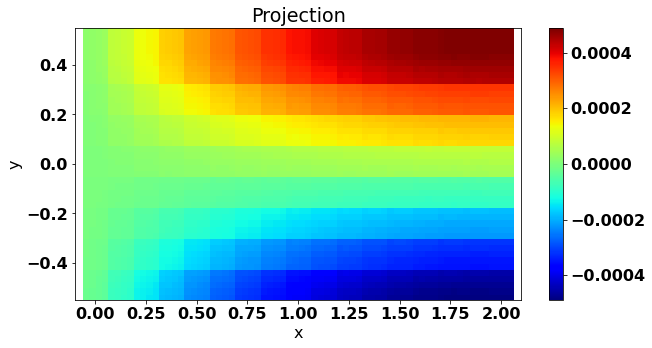

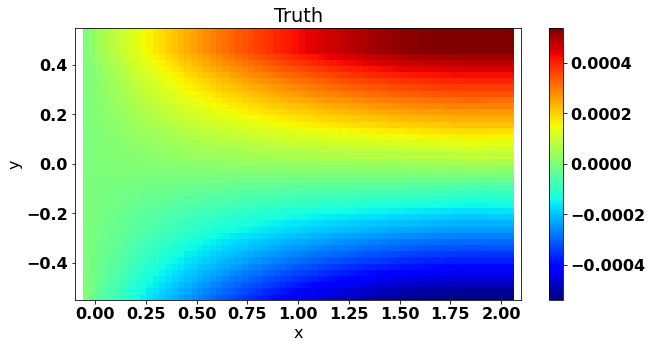

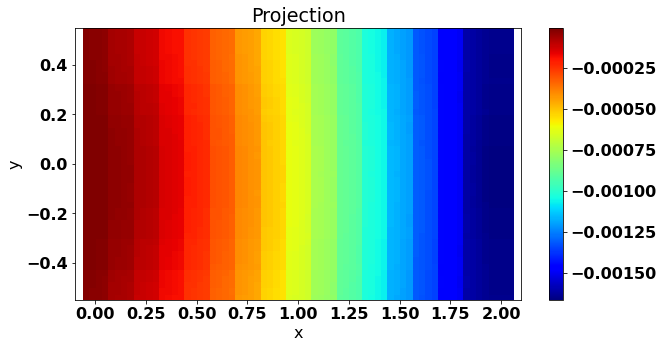

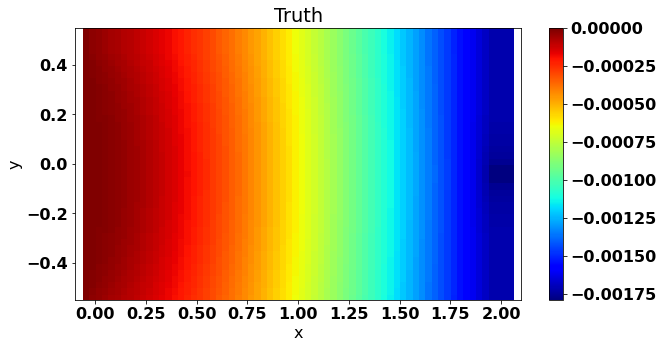

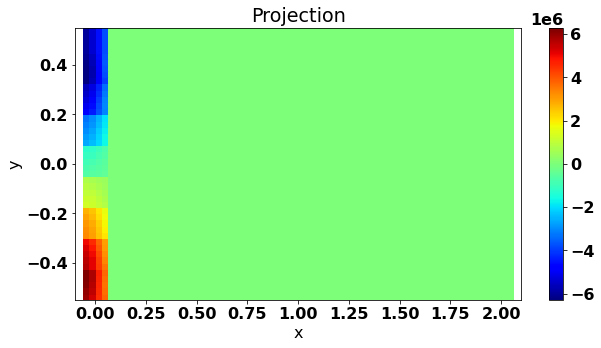

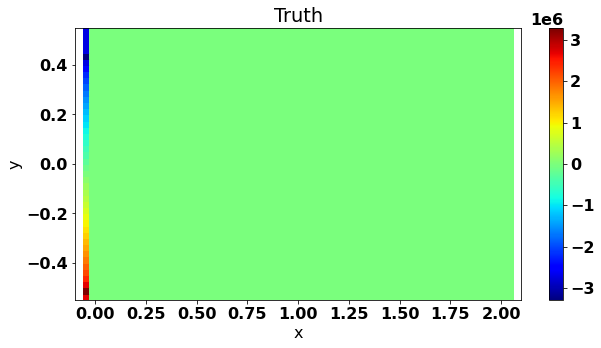

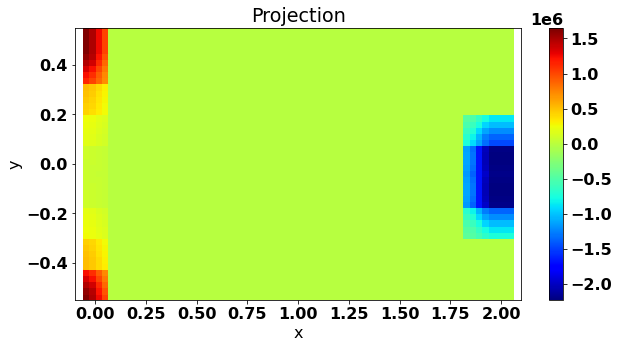

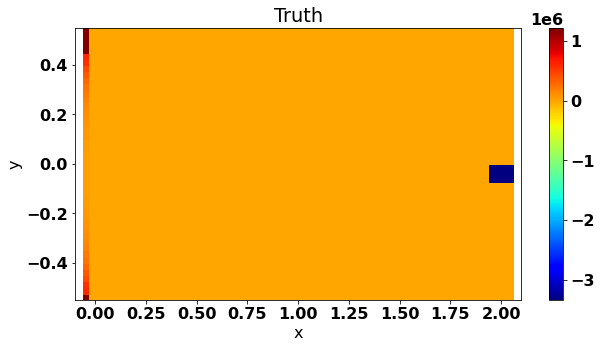

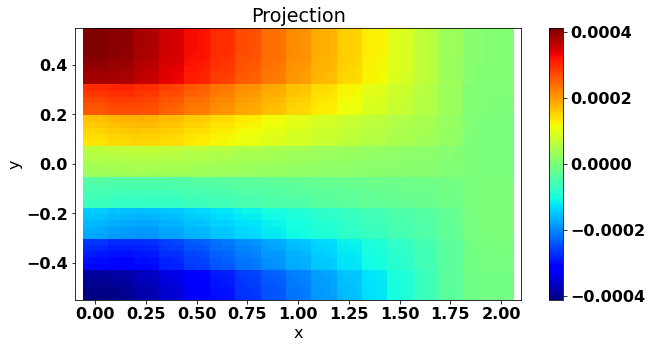

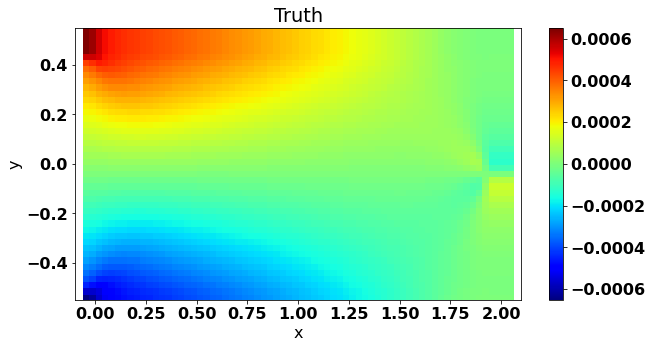

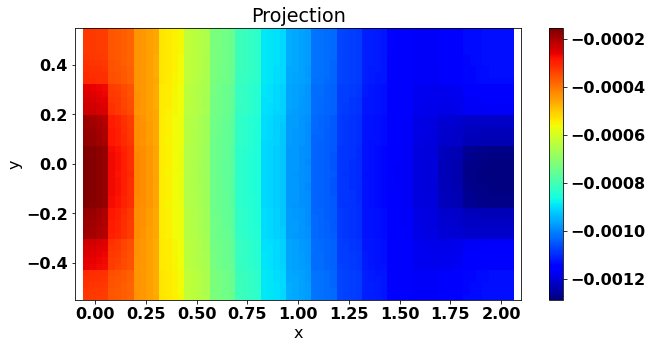

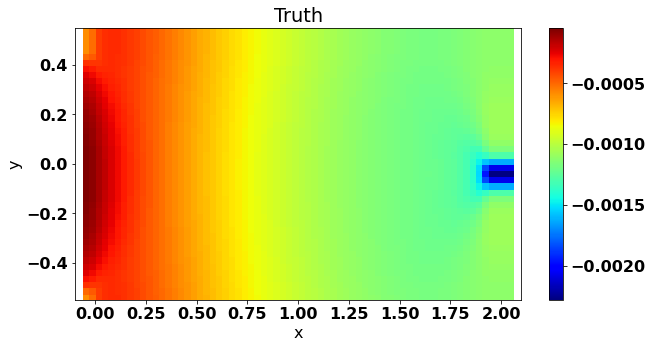

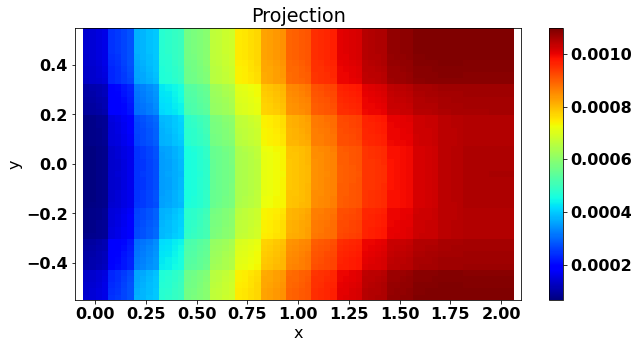

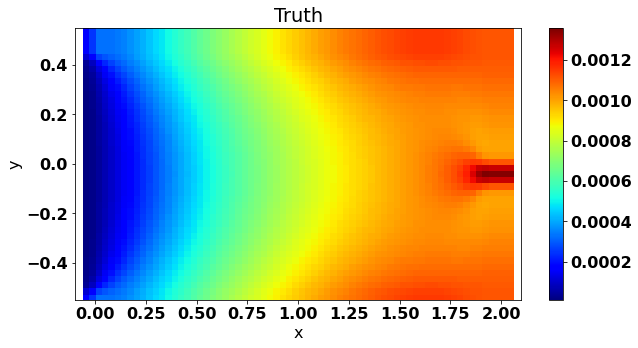

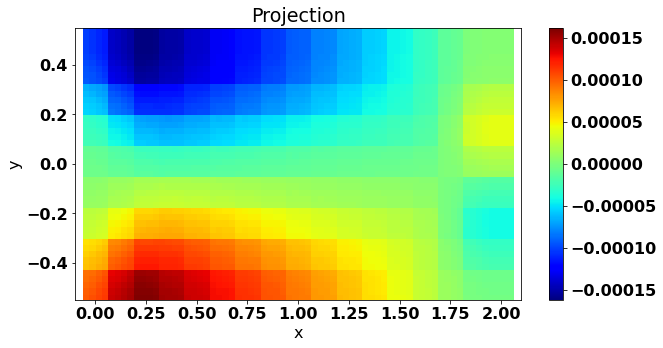

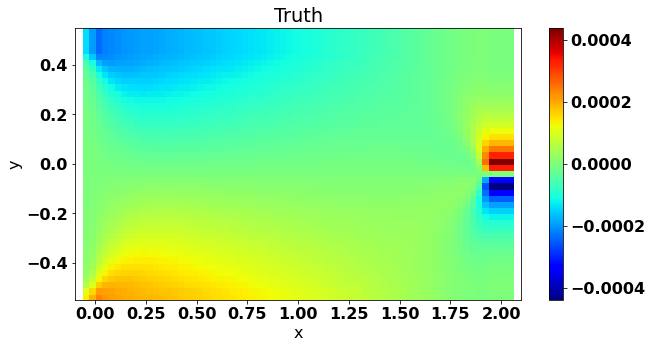

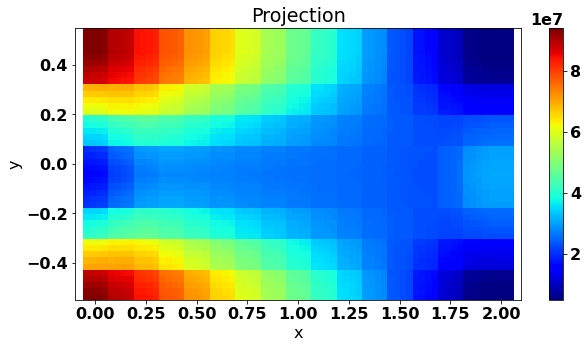

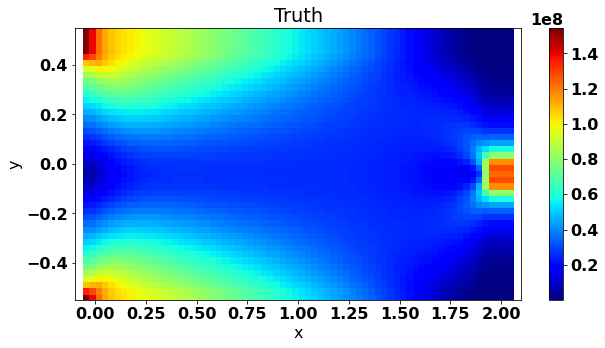

In [35]:
x, y = np.asarray(mesh_1.coords).T
plot_nodal_vect(x, y, input_graph_1["nodes"][..., 9], "1hots", 6e2)
for i in range(9) :
  plot_nodal_vect(x, y, input_graph_1["nodes"][..., i+10], "Projection", 6e2)
  plot_nodal_vect(x, y, output_graph_1["nodes"][..., i], "Truth", 6e2 )

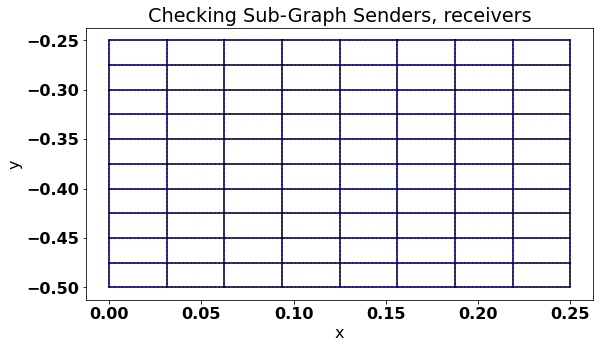

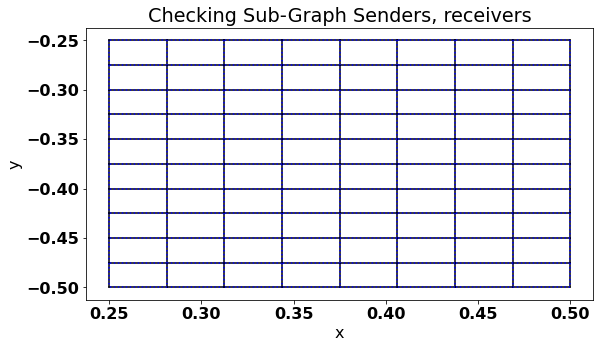

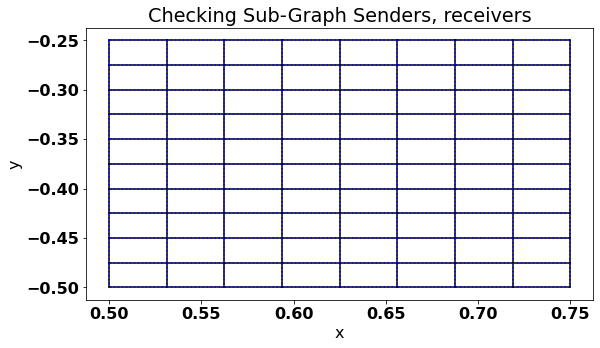

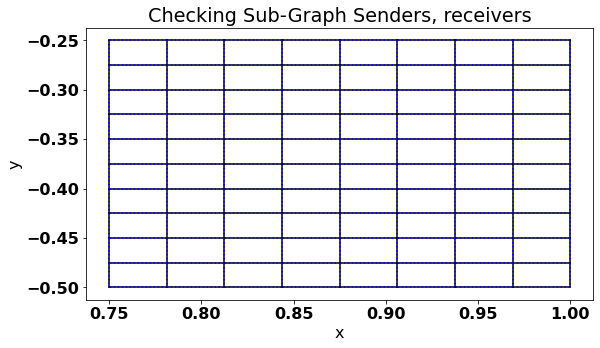

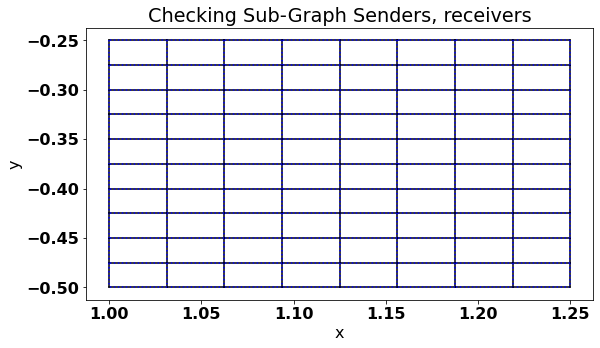

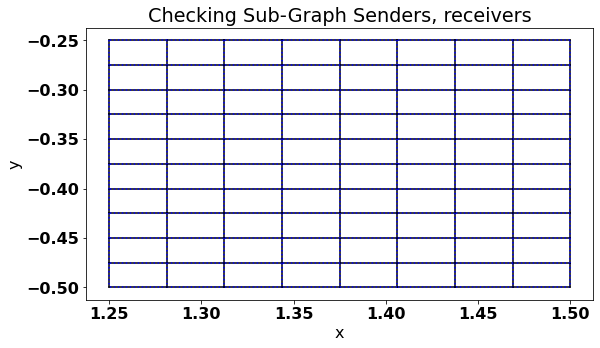

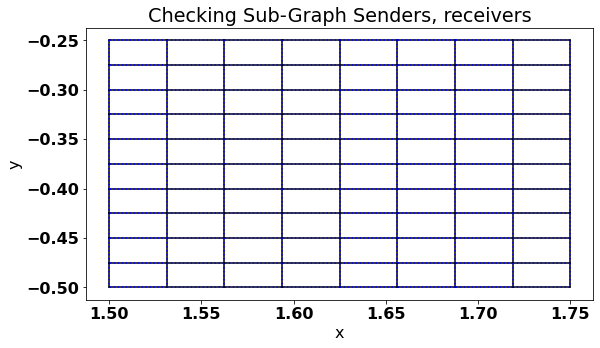

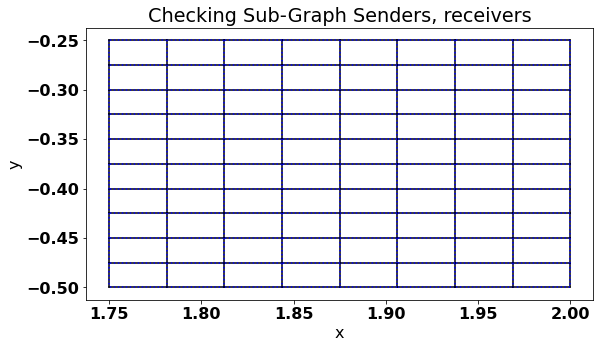

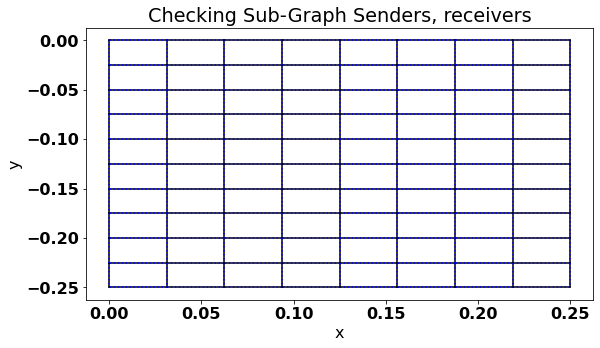

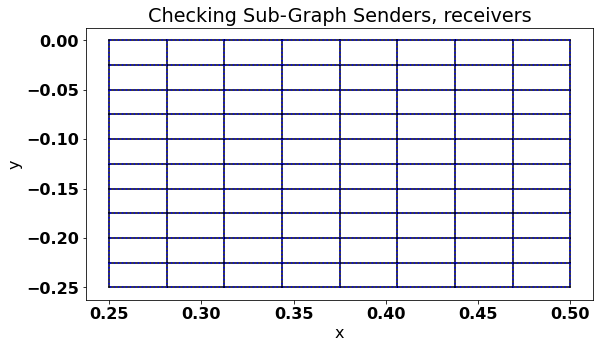

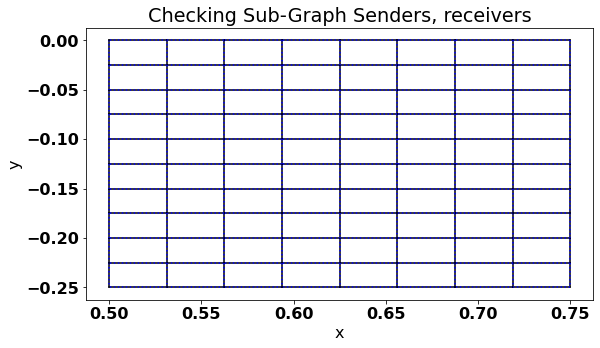

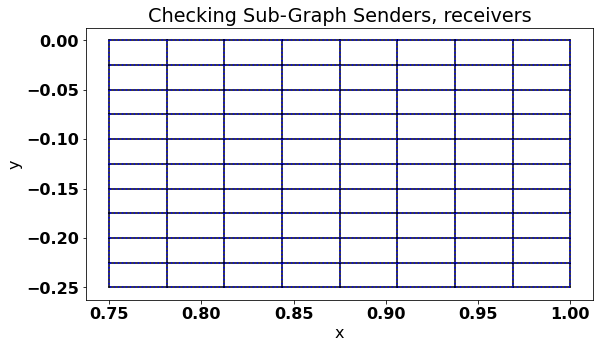

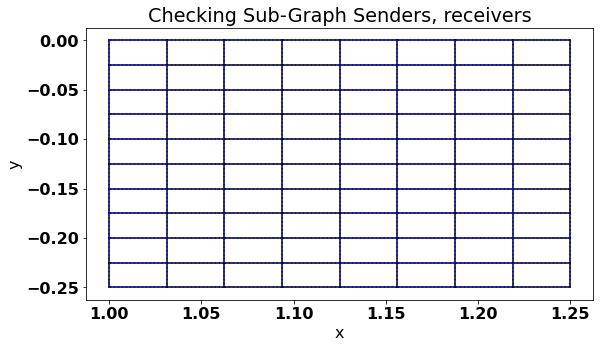

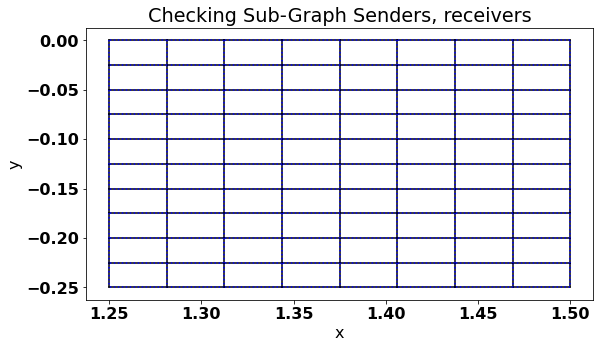

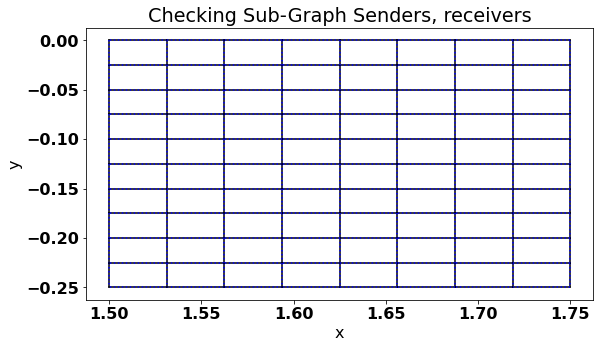

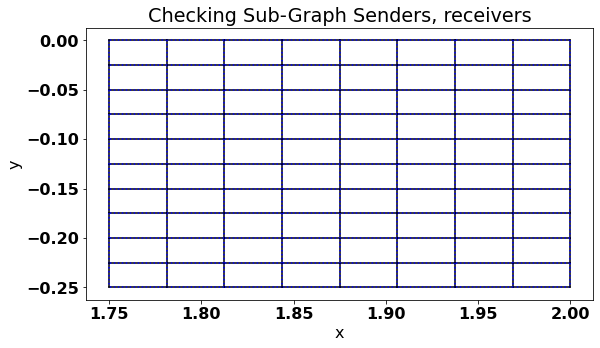

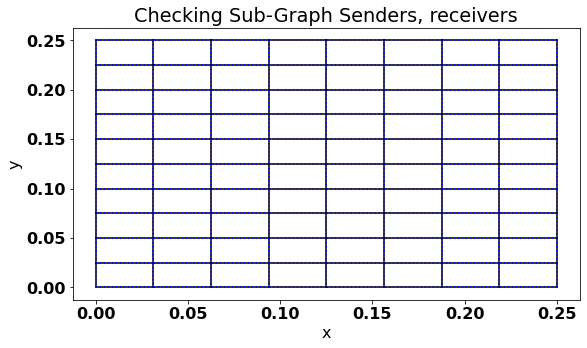

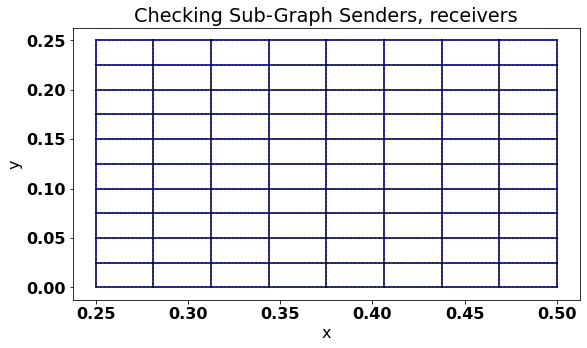

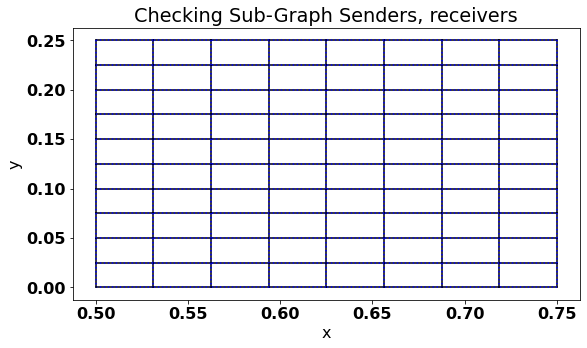

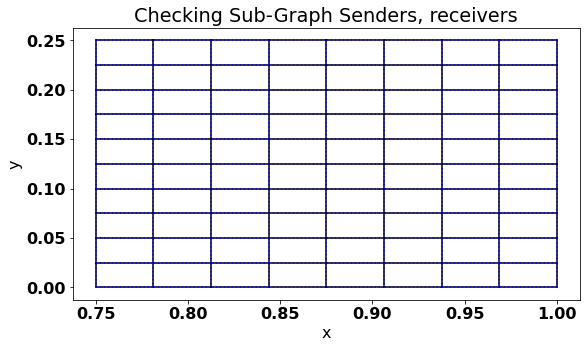

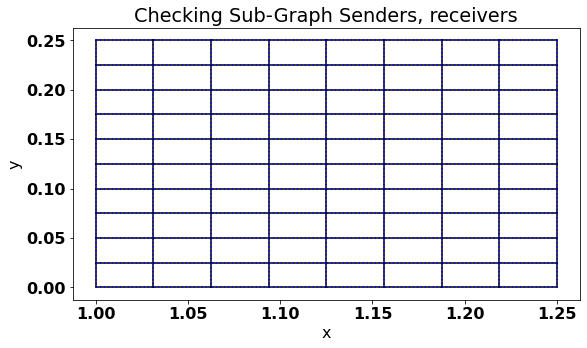

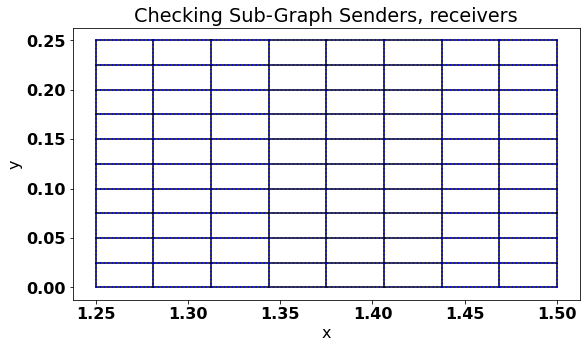

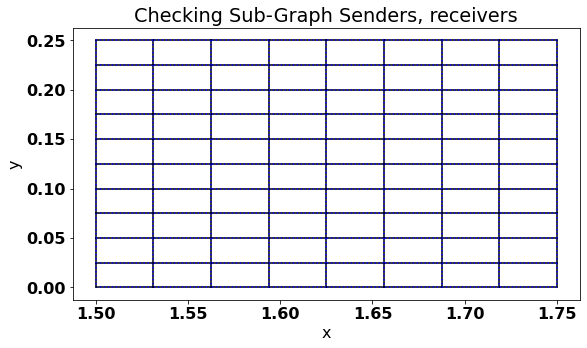

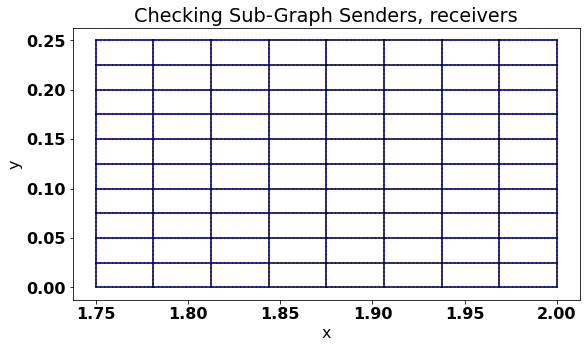

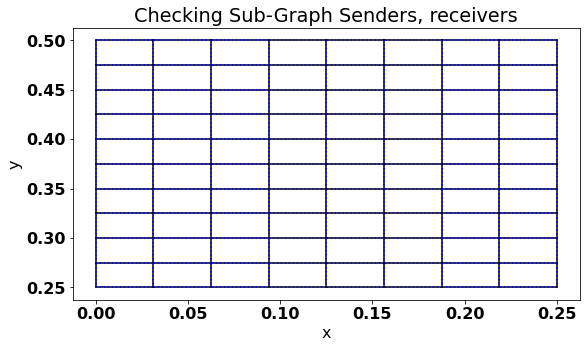

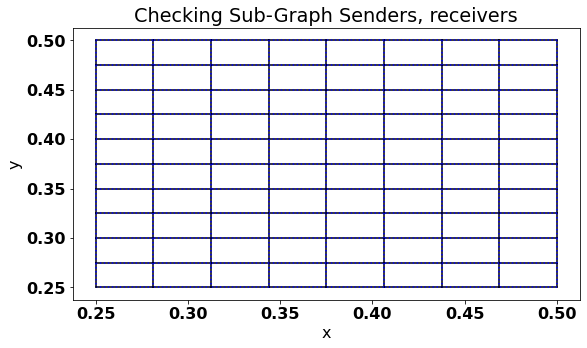

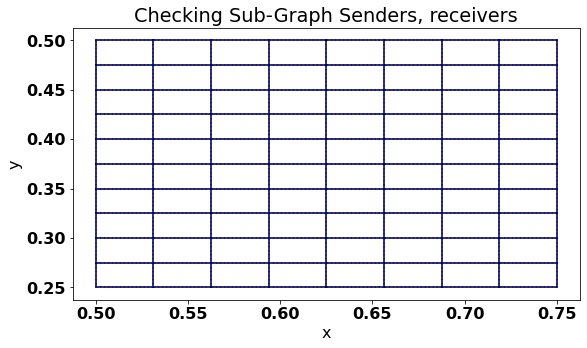

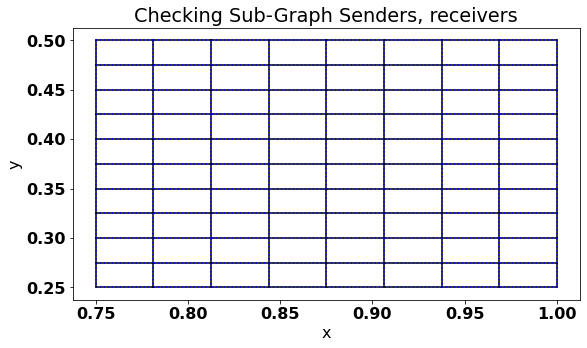

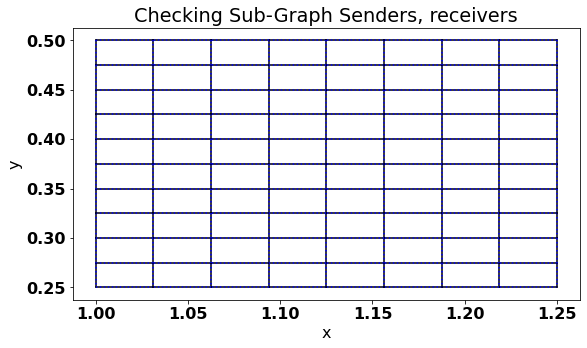

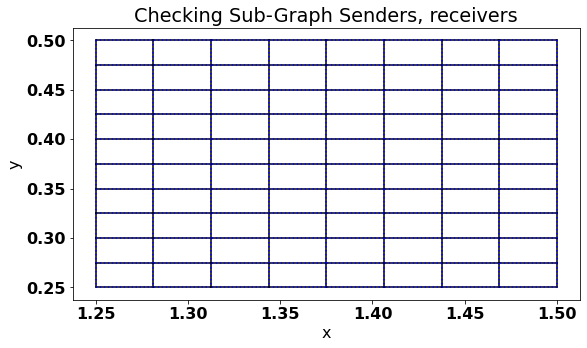

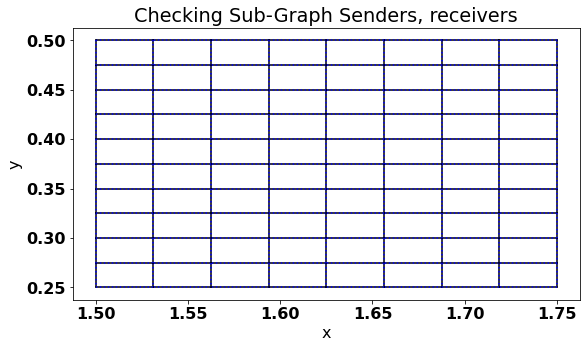

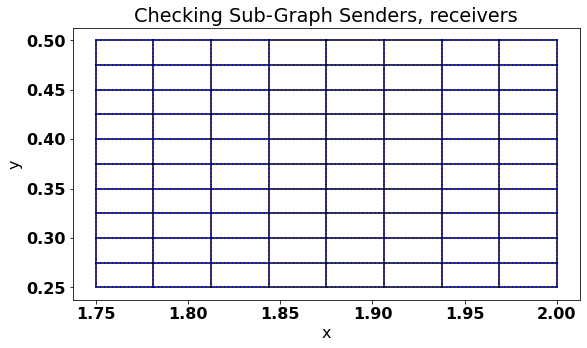

In [36]:
for i, item in enumerate(normalized_input_list) :
  fig = plt.figure(1, figsize=(20, 5))
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title("Checking Sub-Graph Senders, receivers") 
  ax.set_ylabel('y')
  ax.set_xlabel('x')
  for e, (send, rec) in enumerate(zip(item["senders"], item["receivers"])) :
    x0, y0 = item["nodes"][send,0:2]
    x1, y1 = item["nodes"][rec,0:2]
    if e % 2 == 0 :
      ax.plot([x0, x1], [y0, y1], c = 'k')
    else :
      ax.plot([x0, x1], [y0, y1], ':', c = 'b')
  plt.show()
  fig.clf()


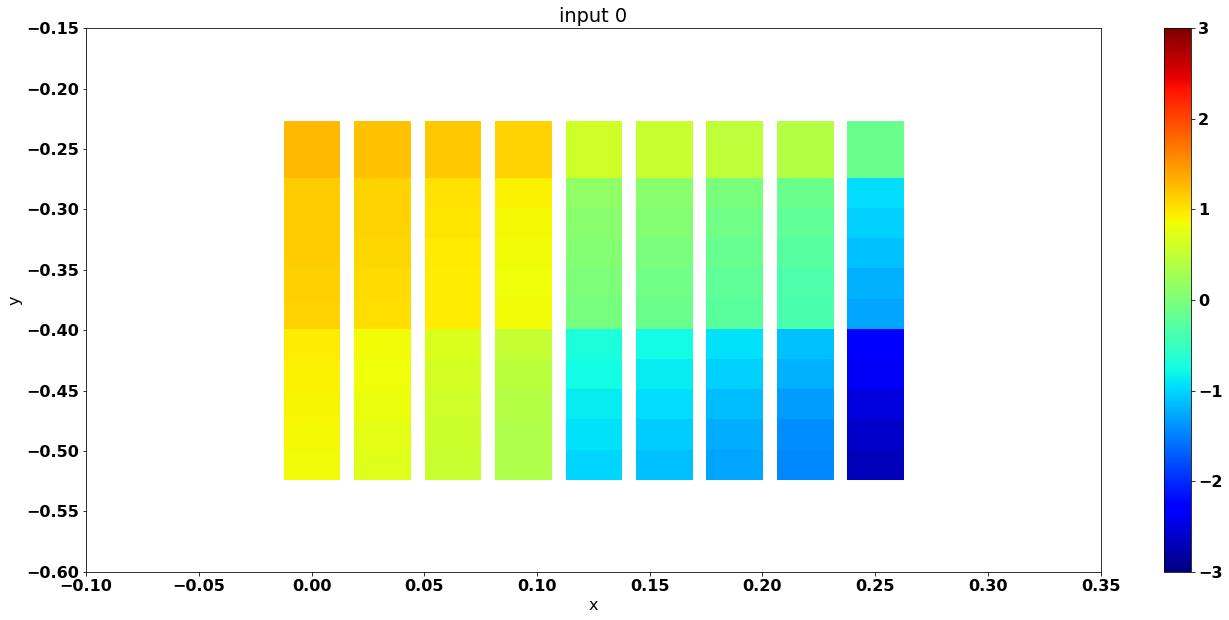

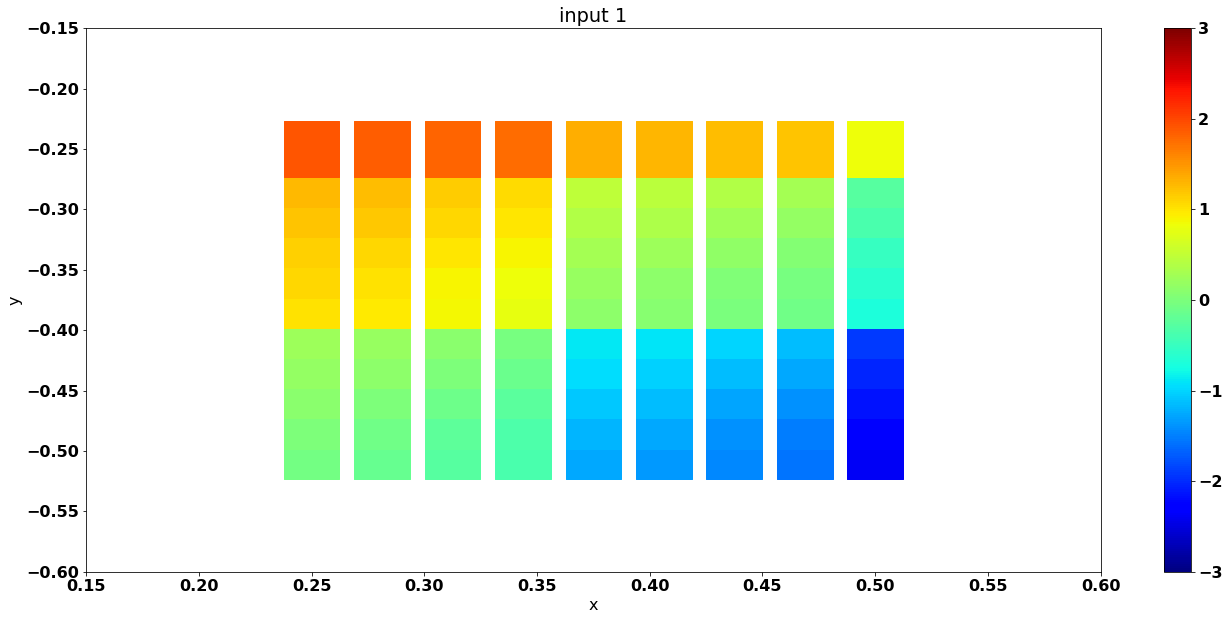

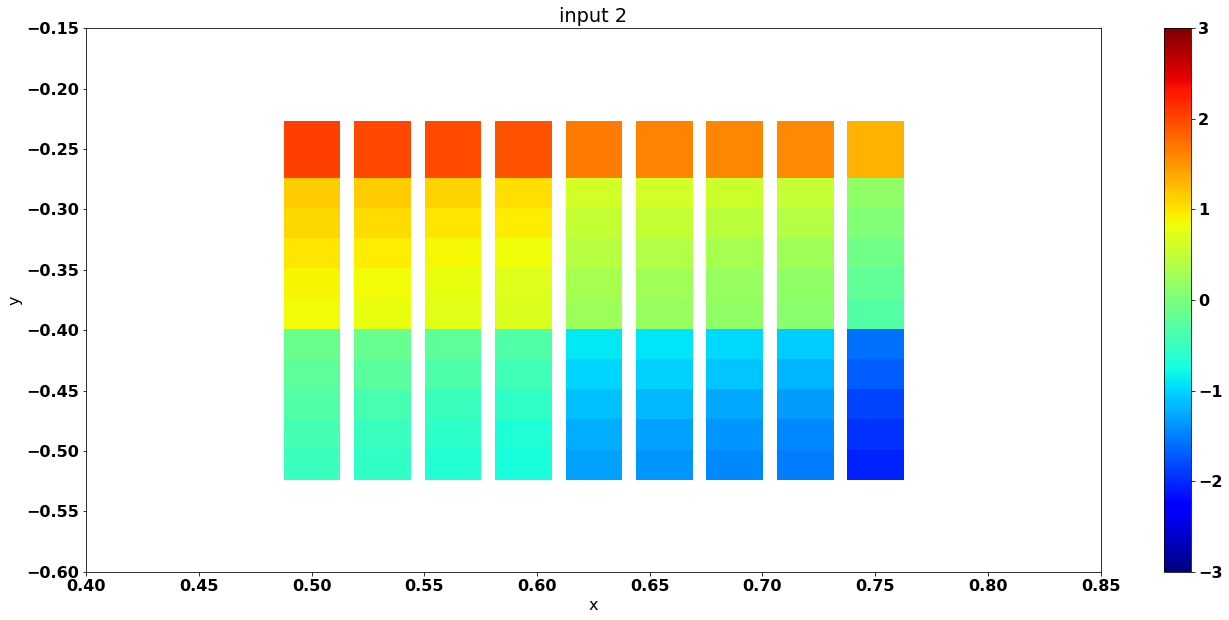

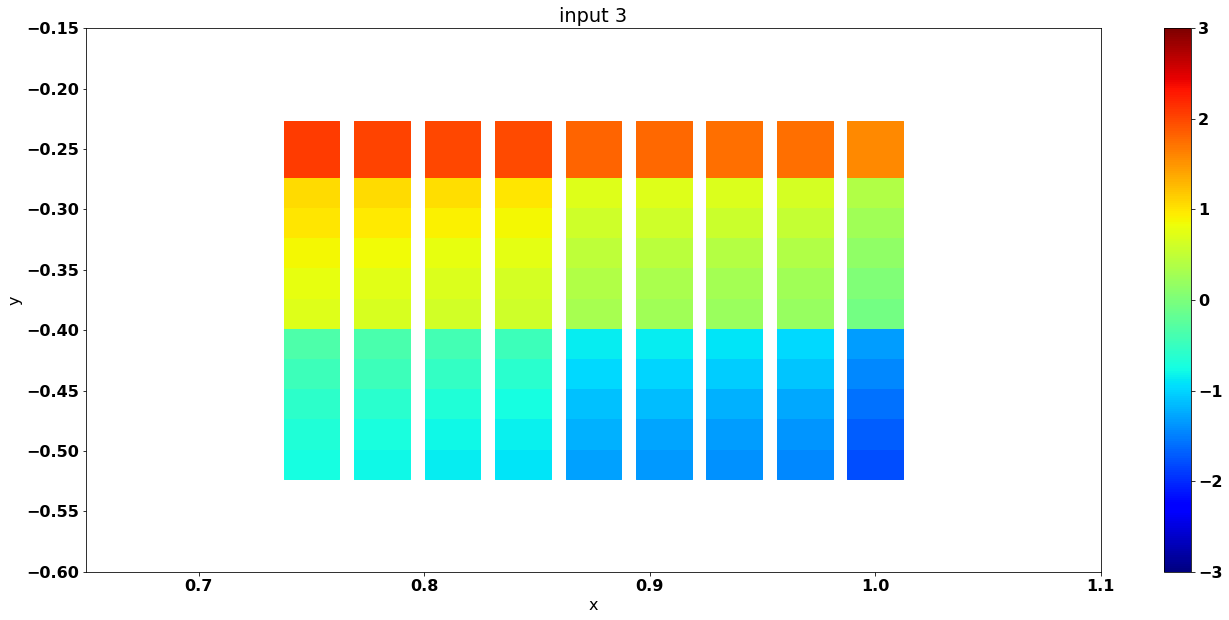

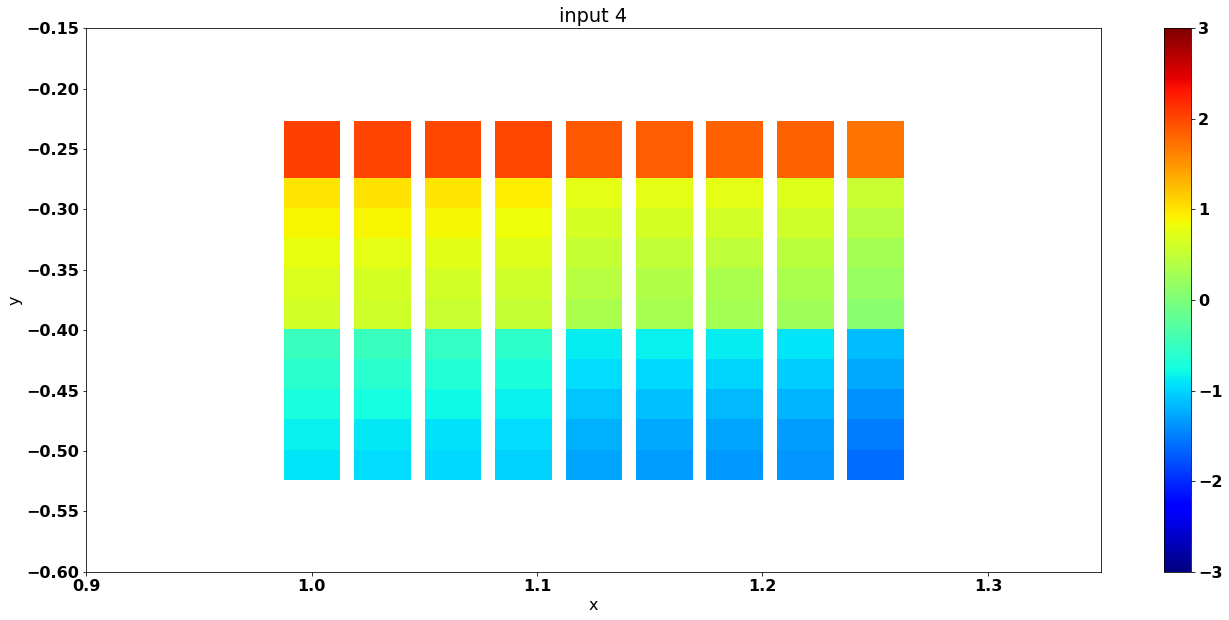

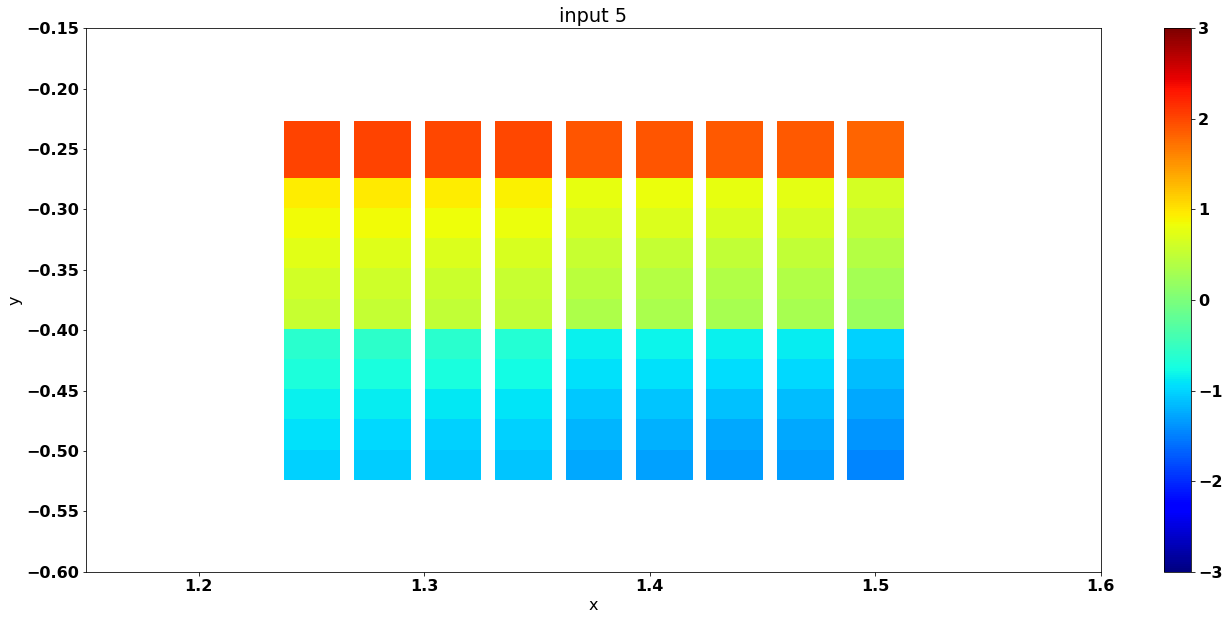

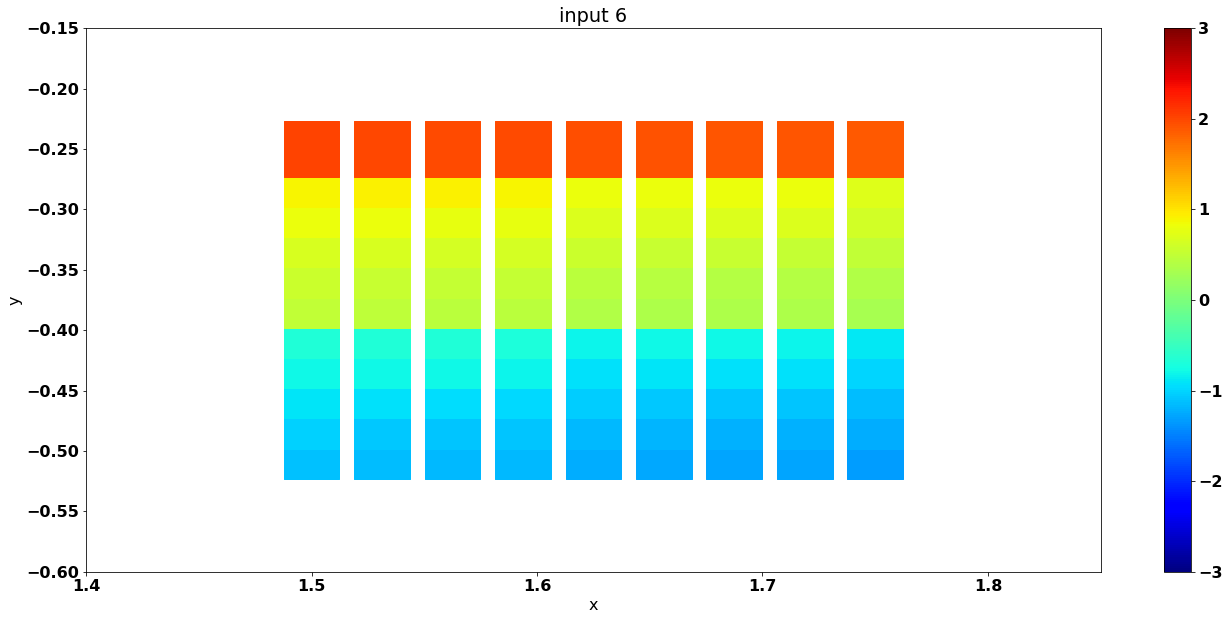

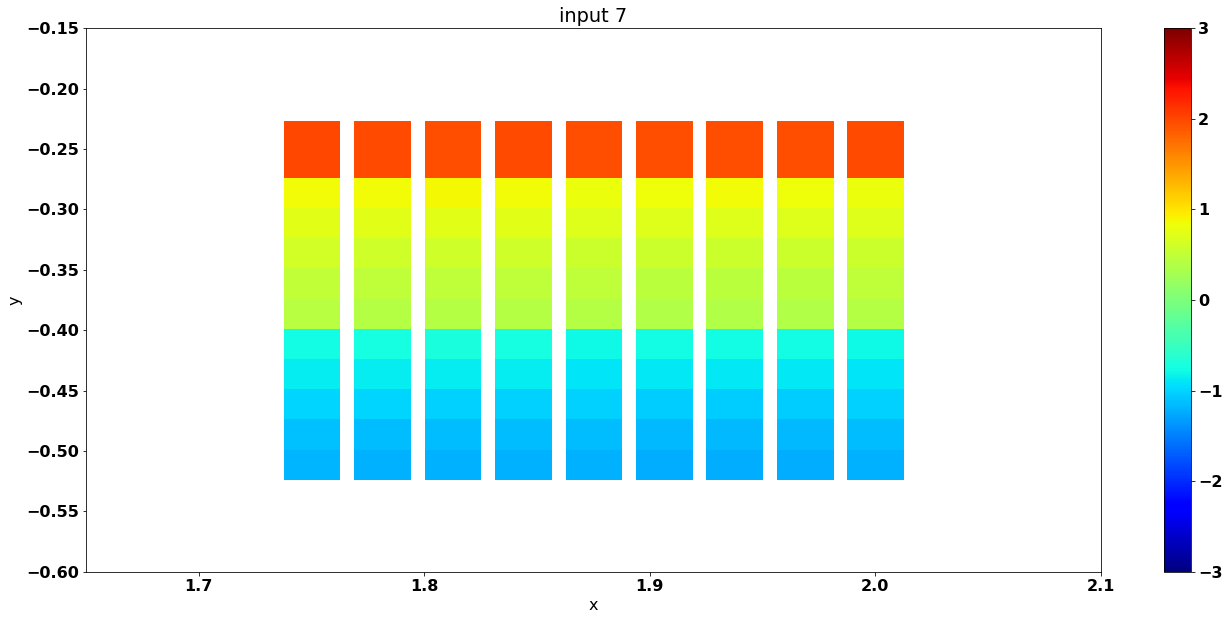

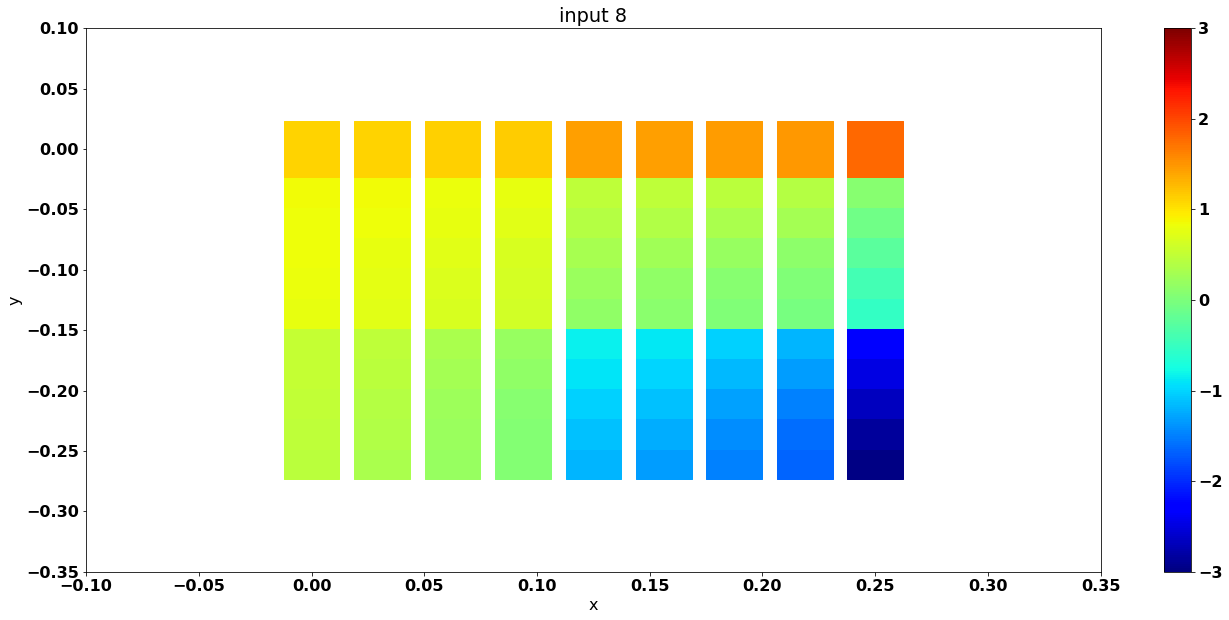

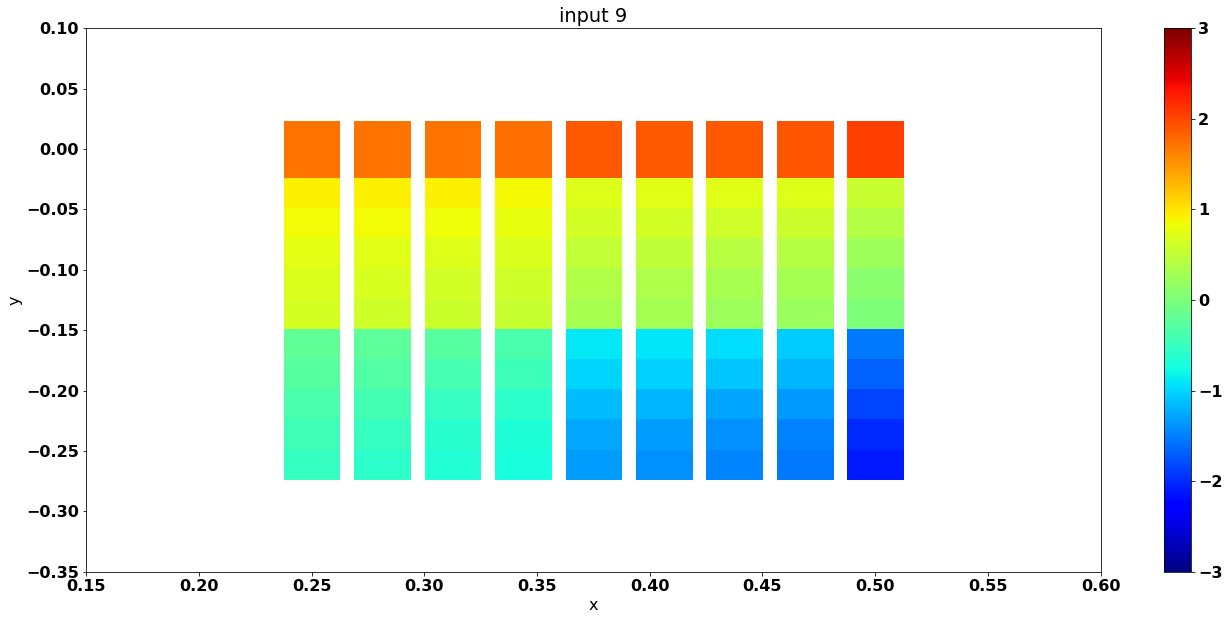

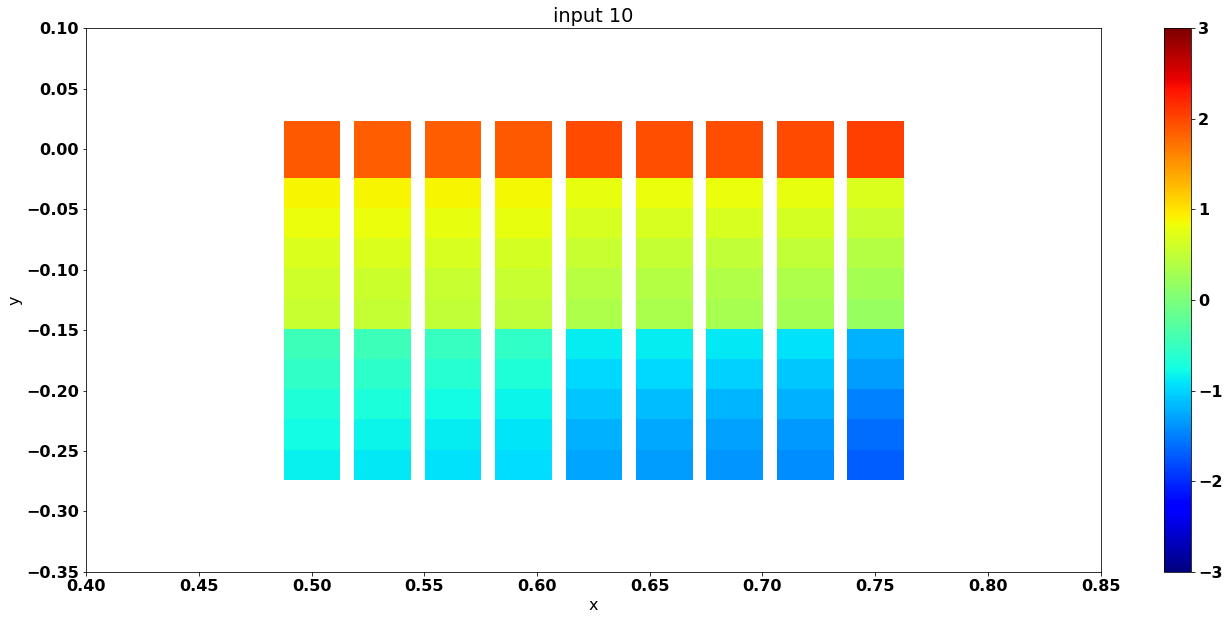

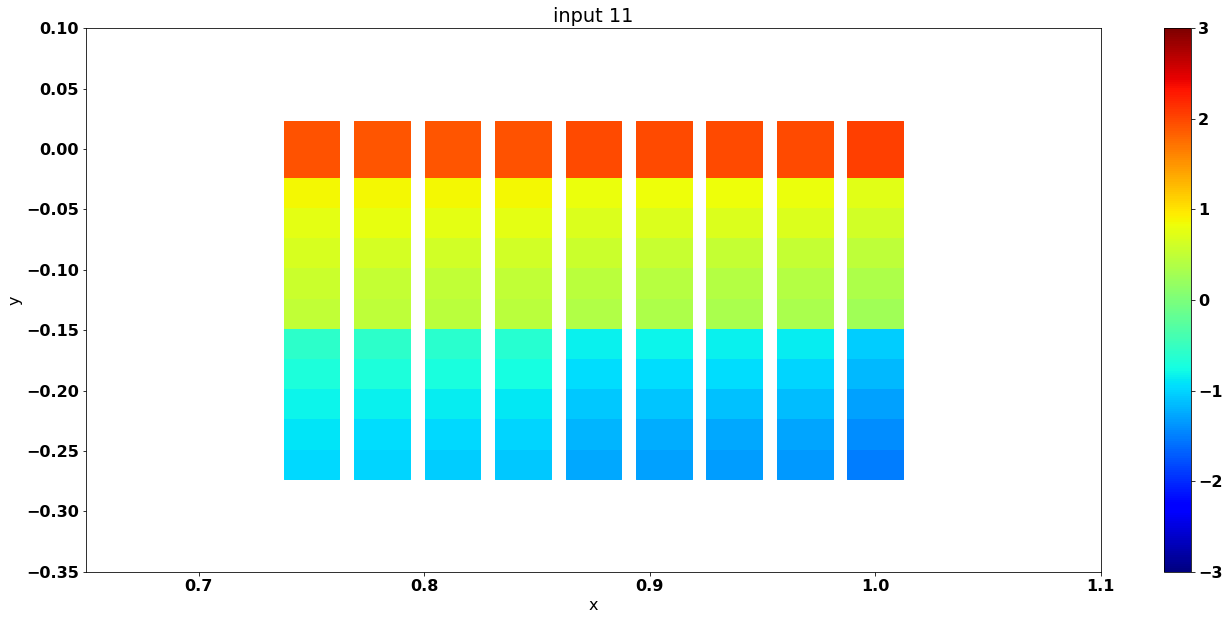

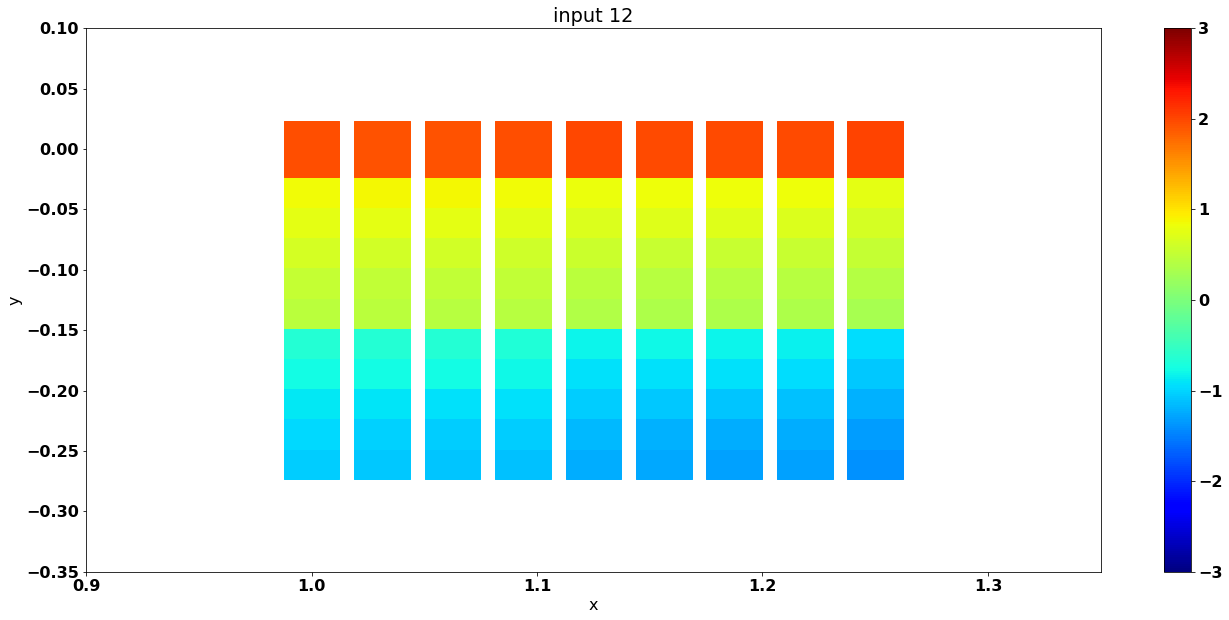

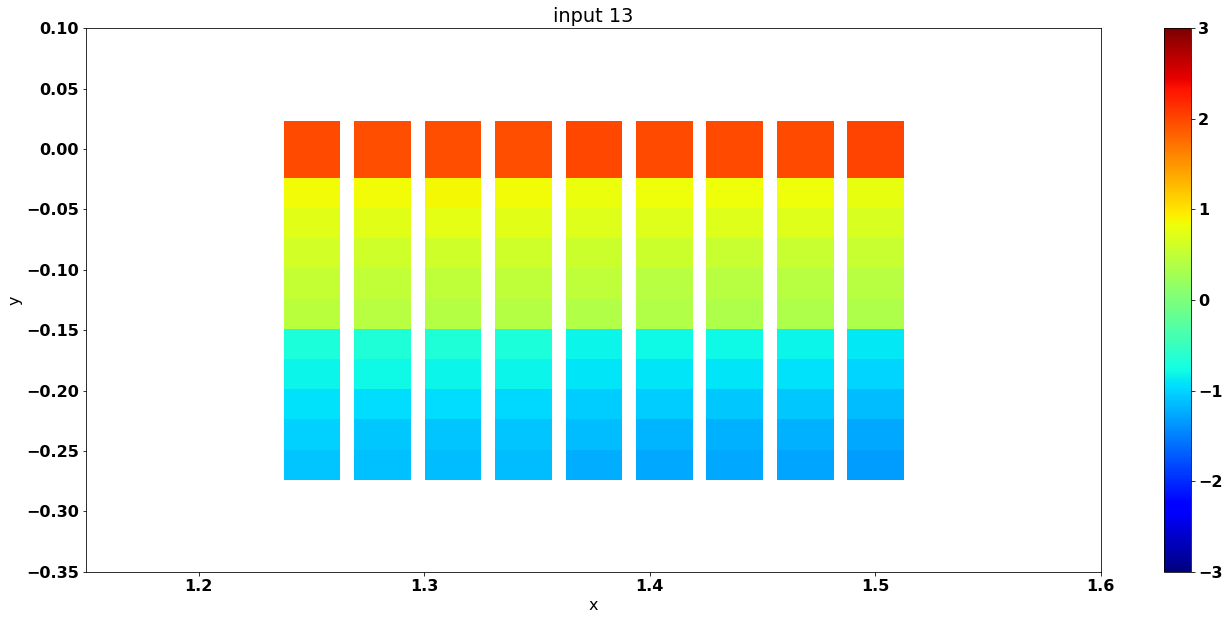

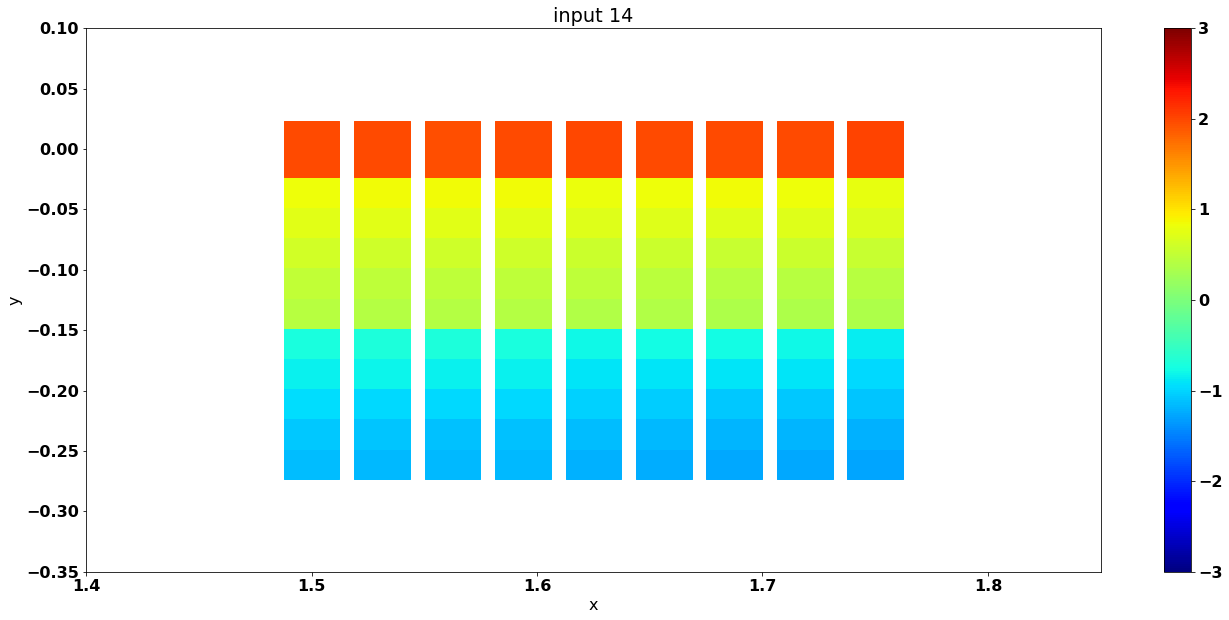

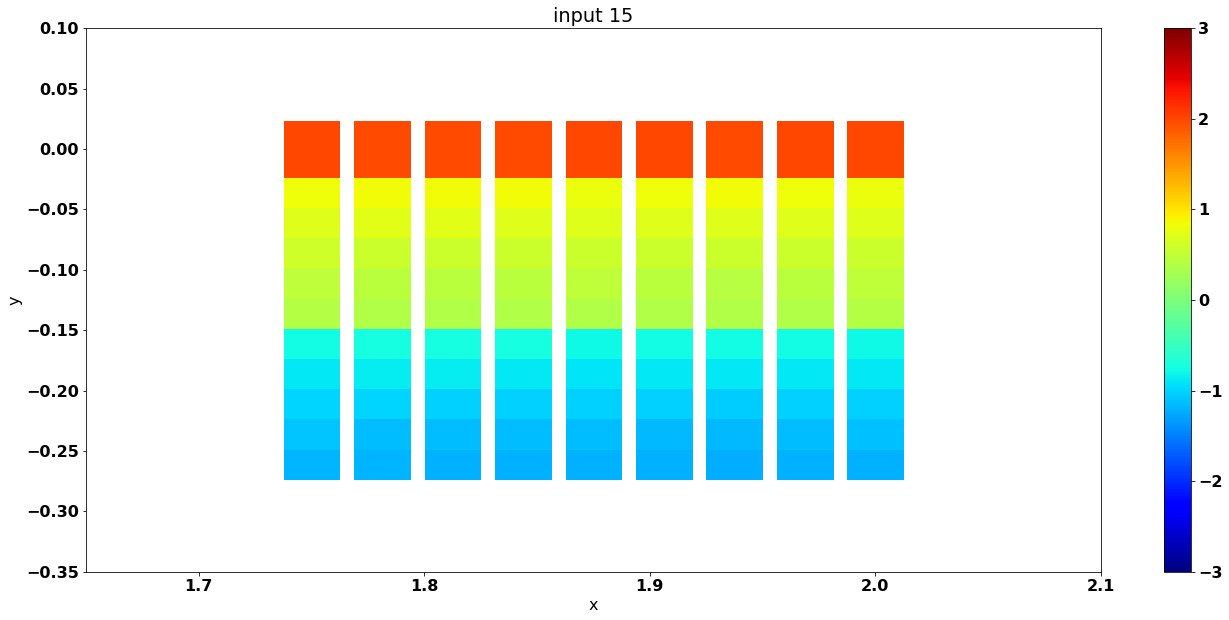

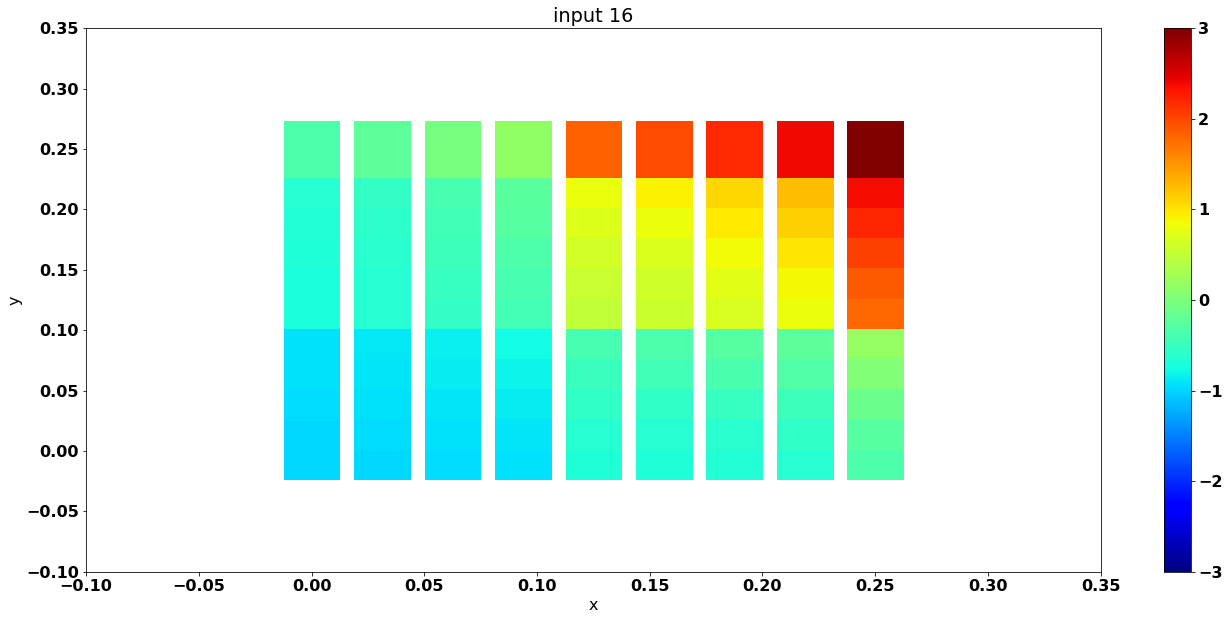

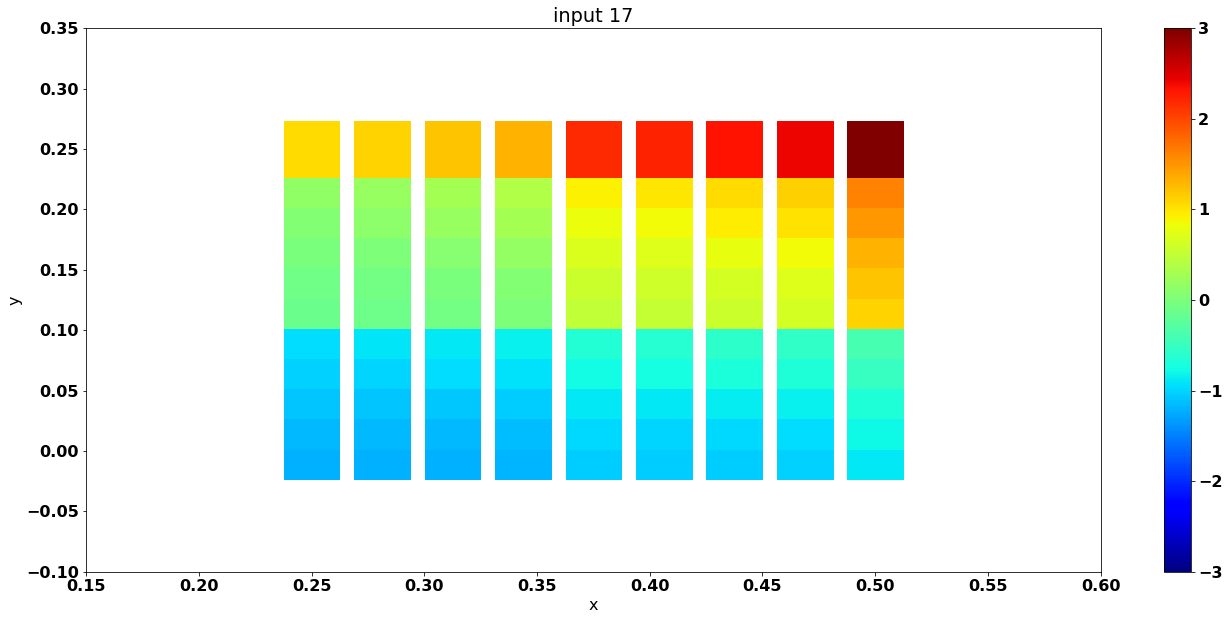

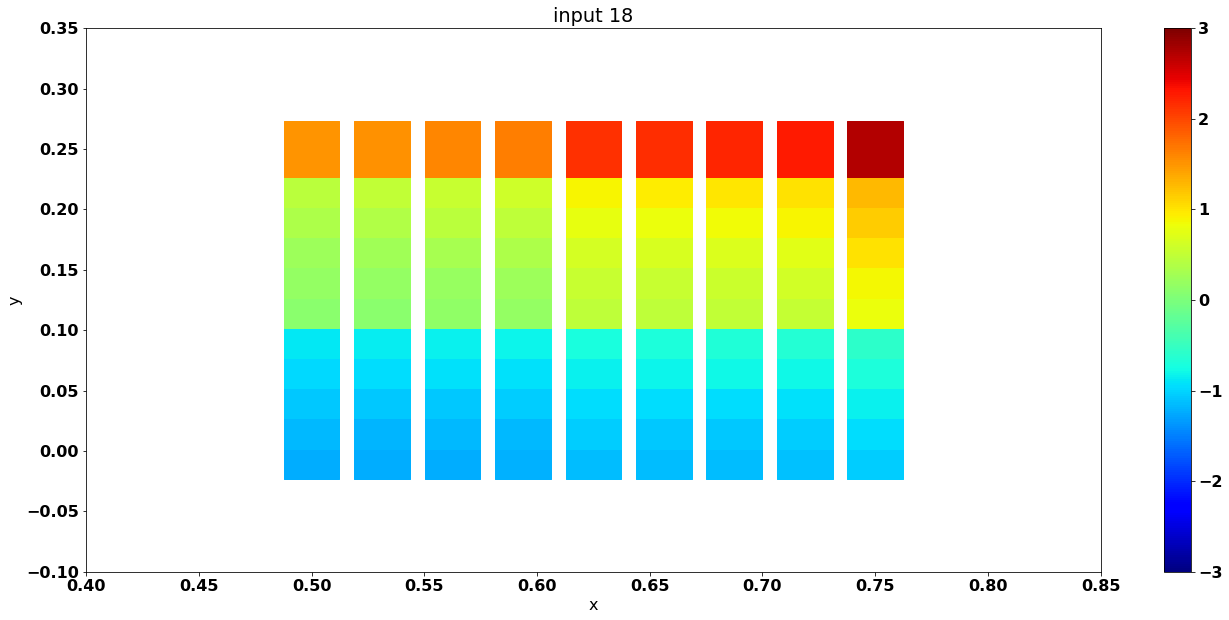

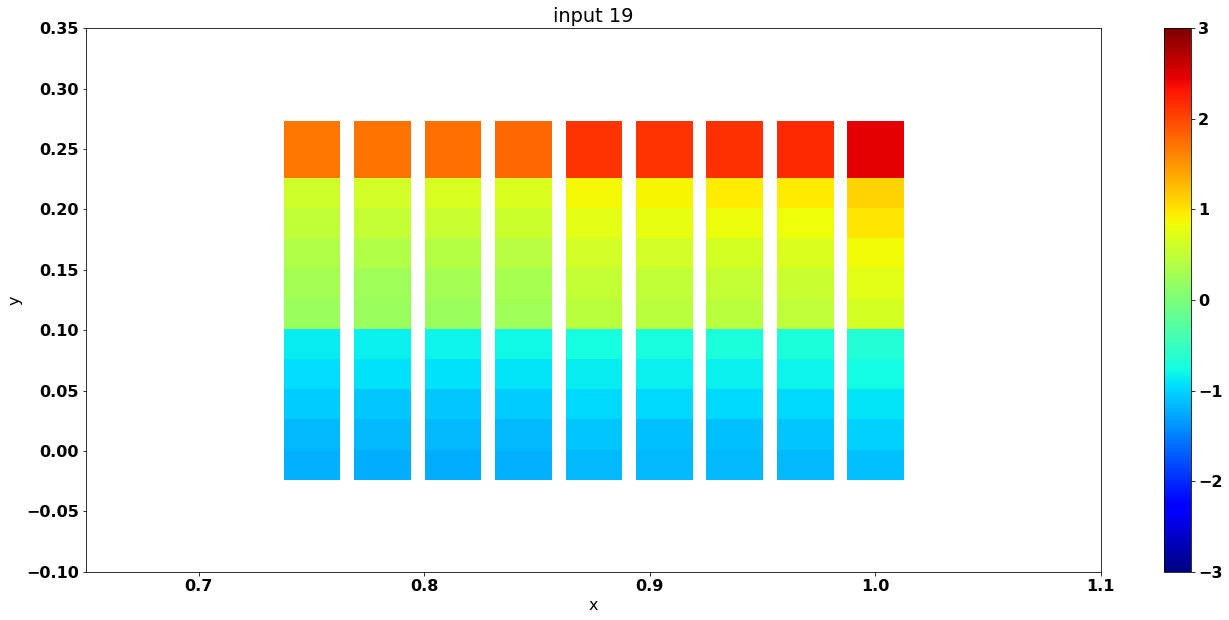

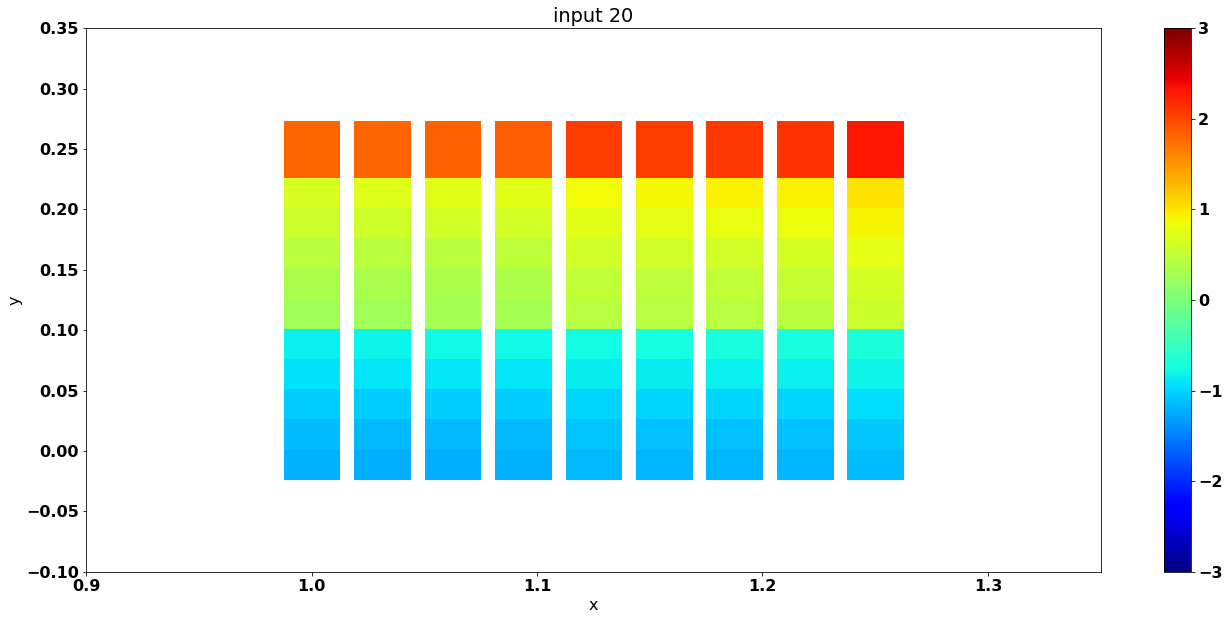

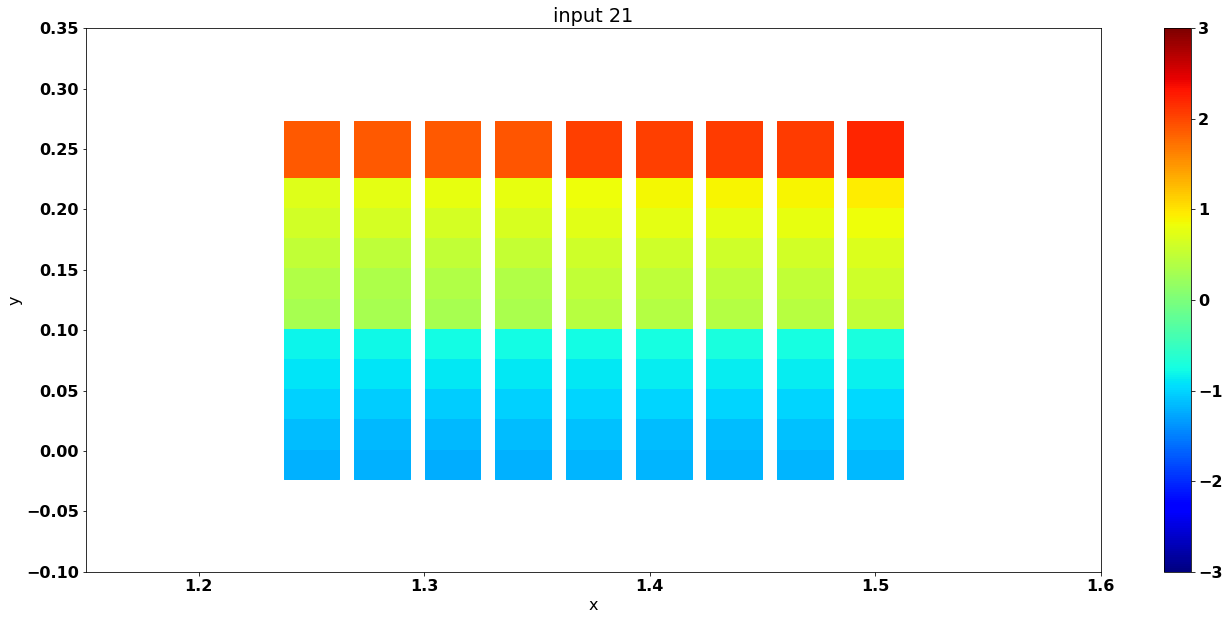

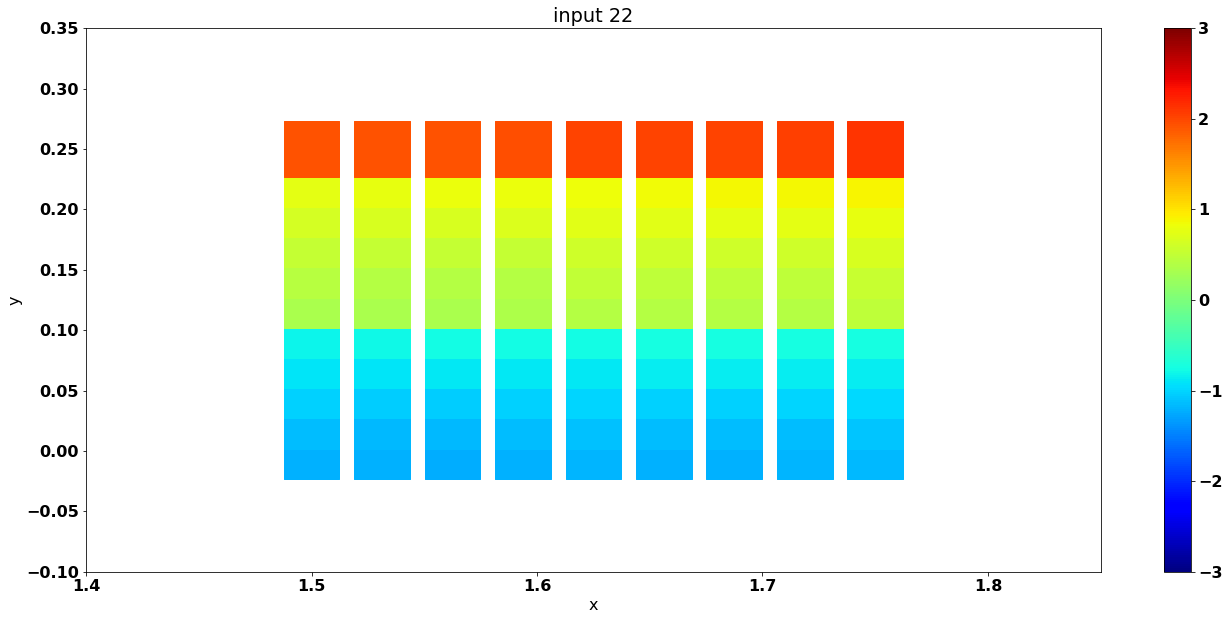

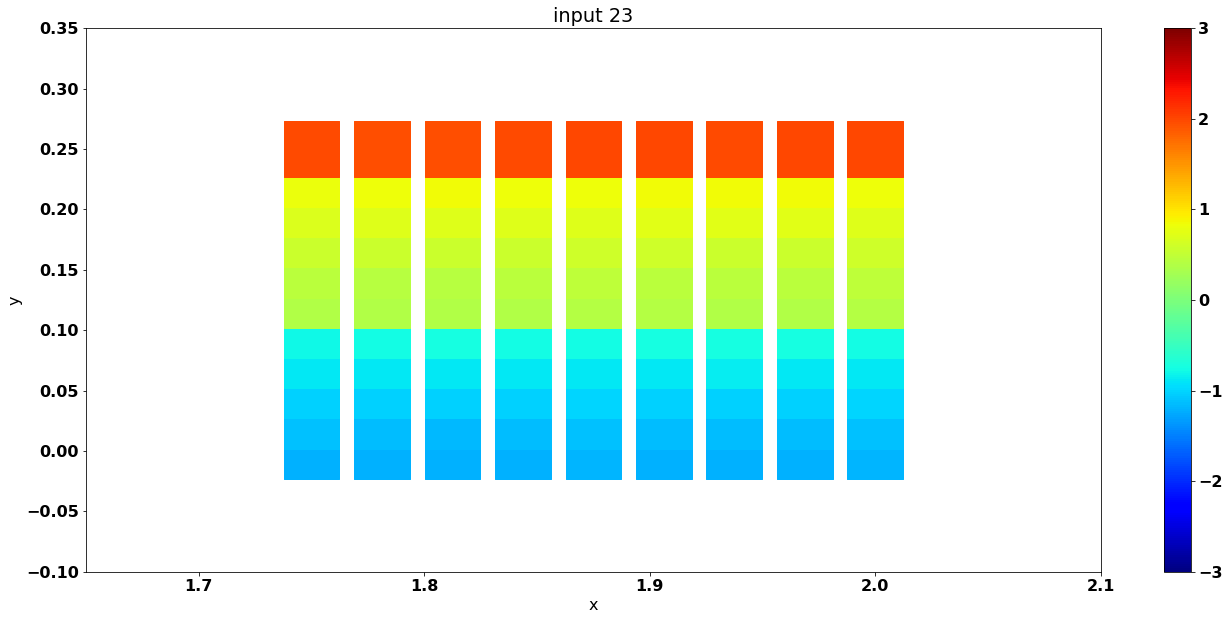

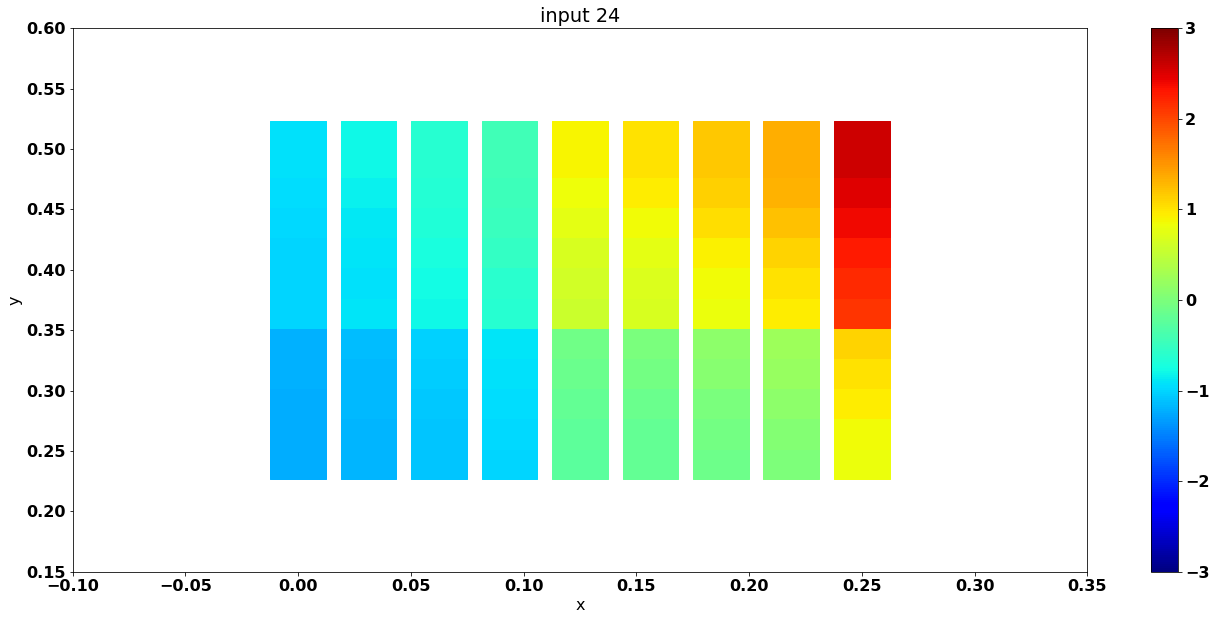

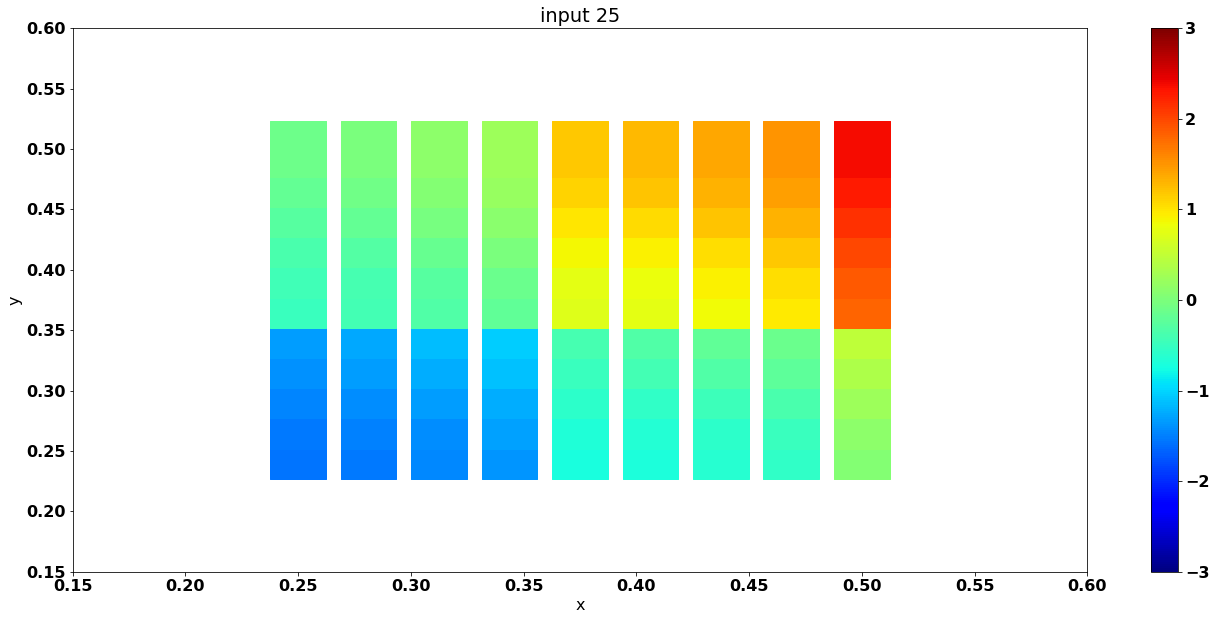

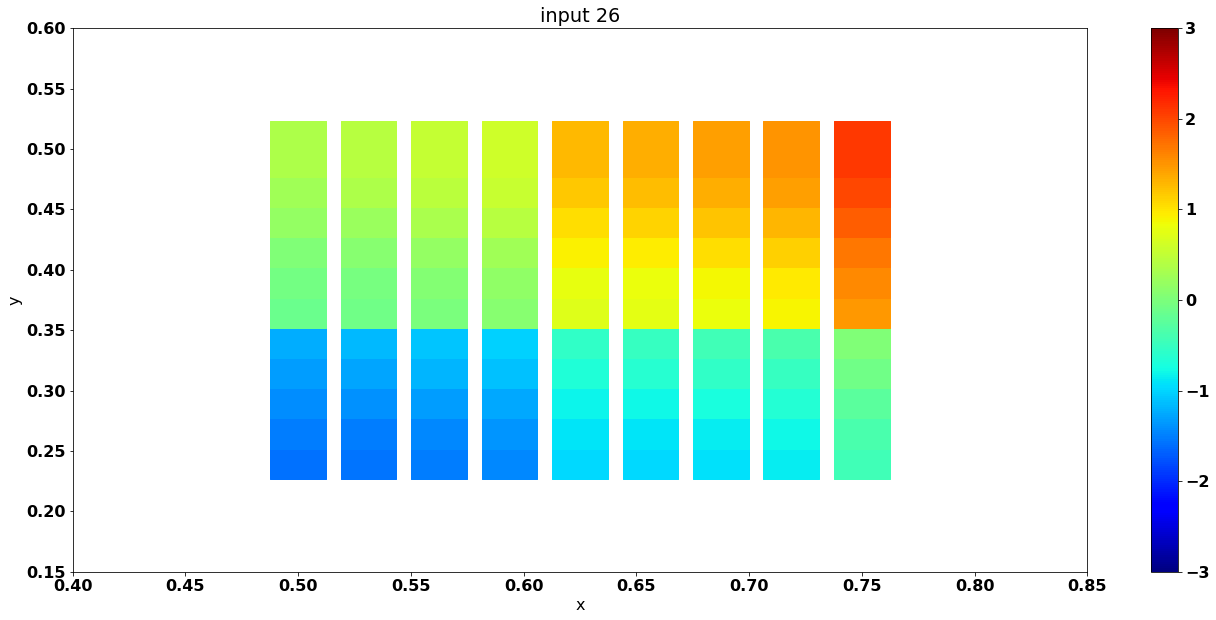

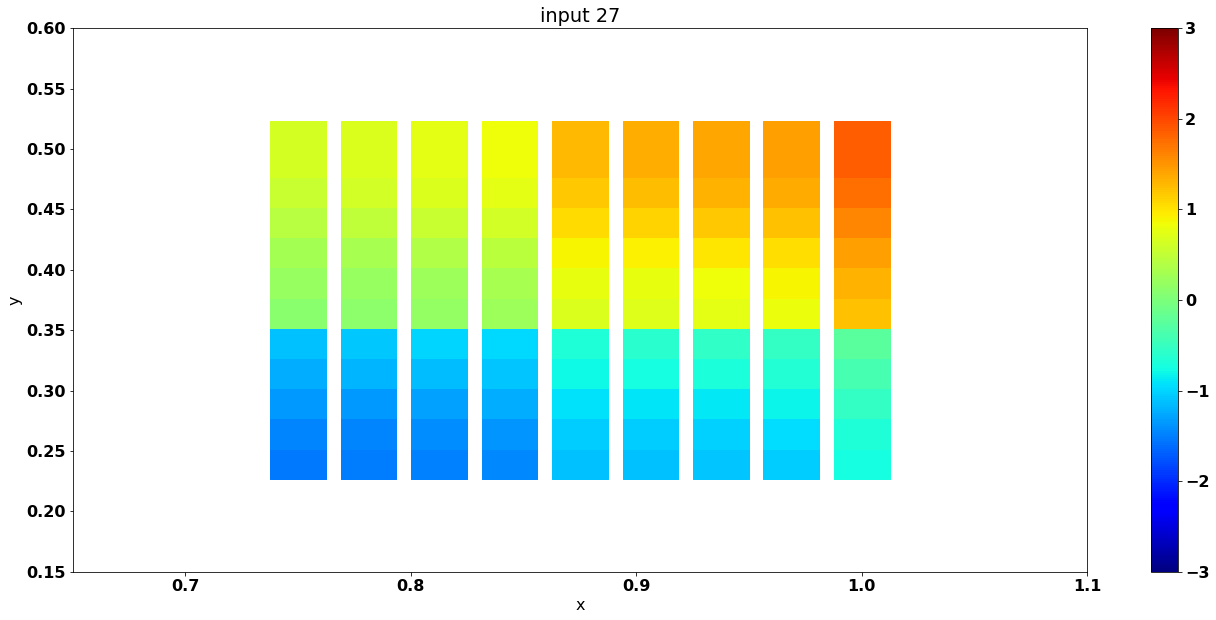

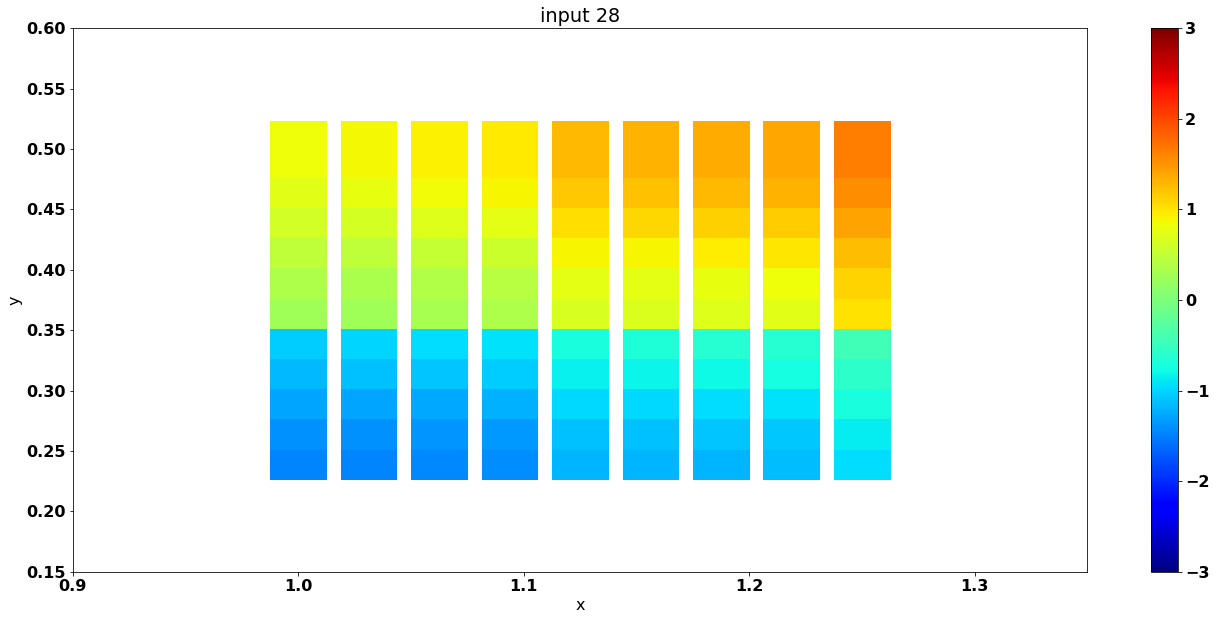

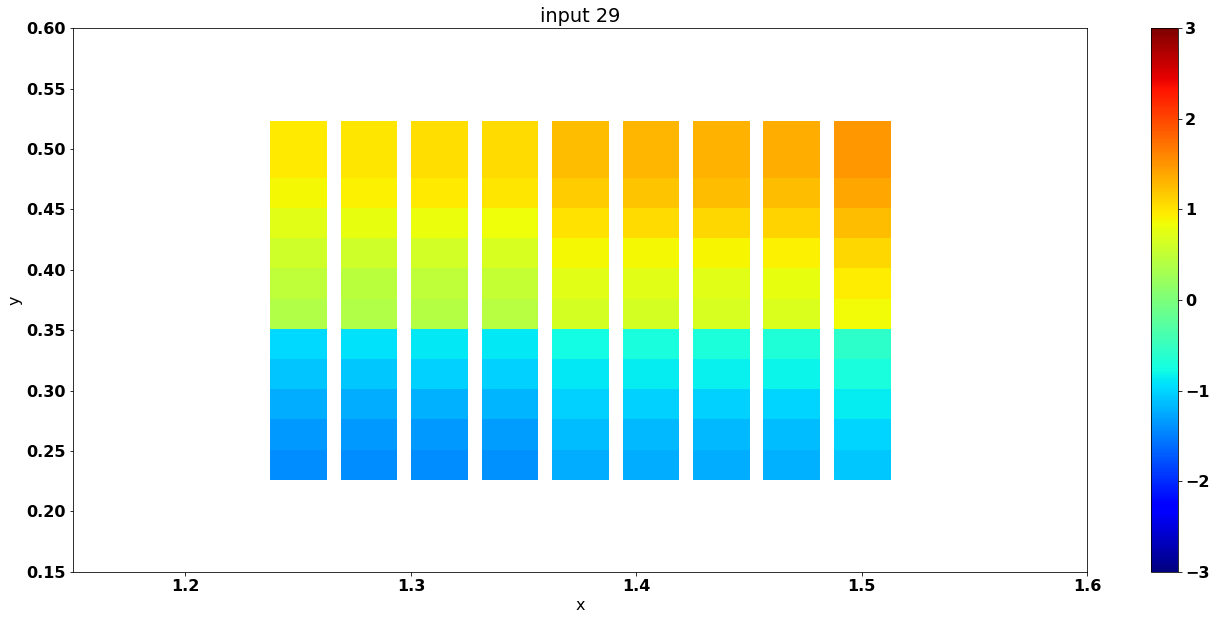

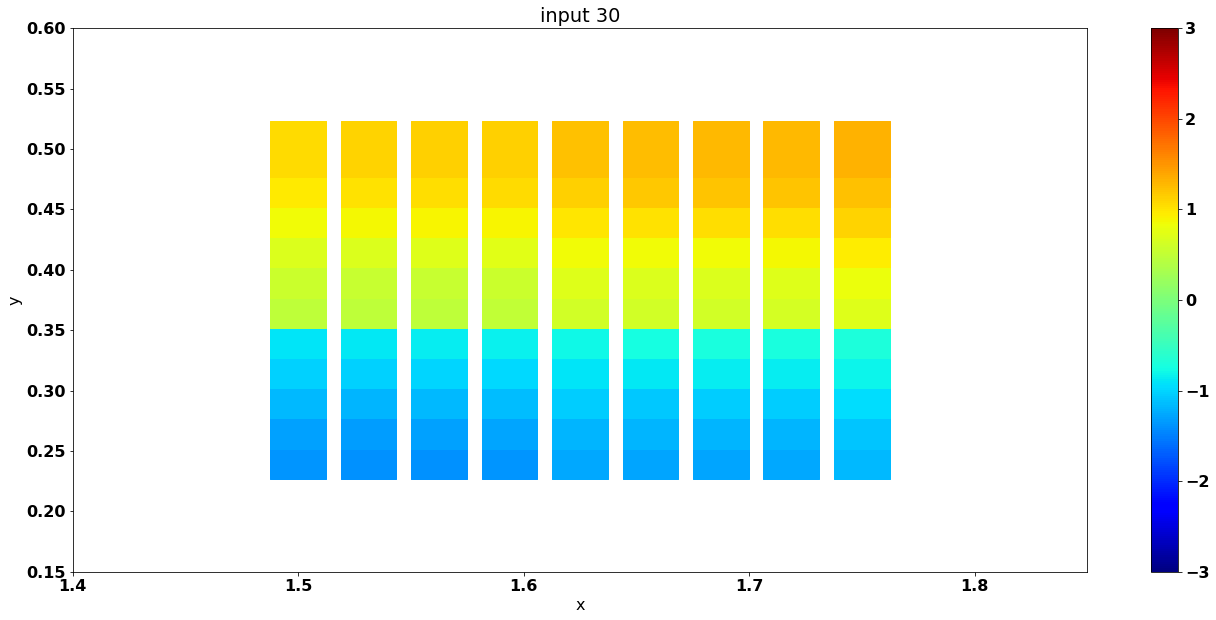

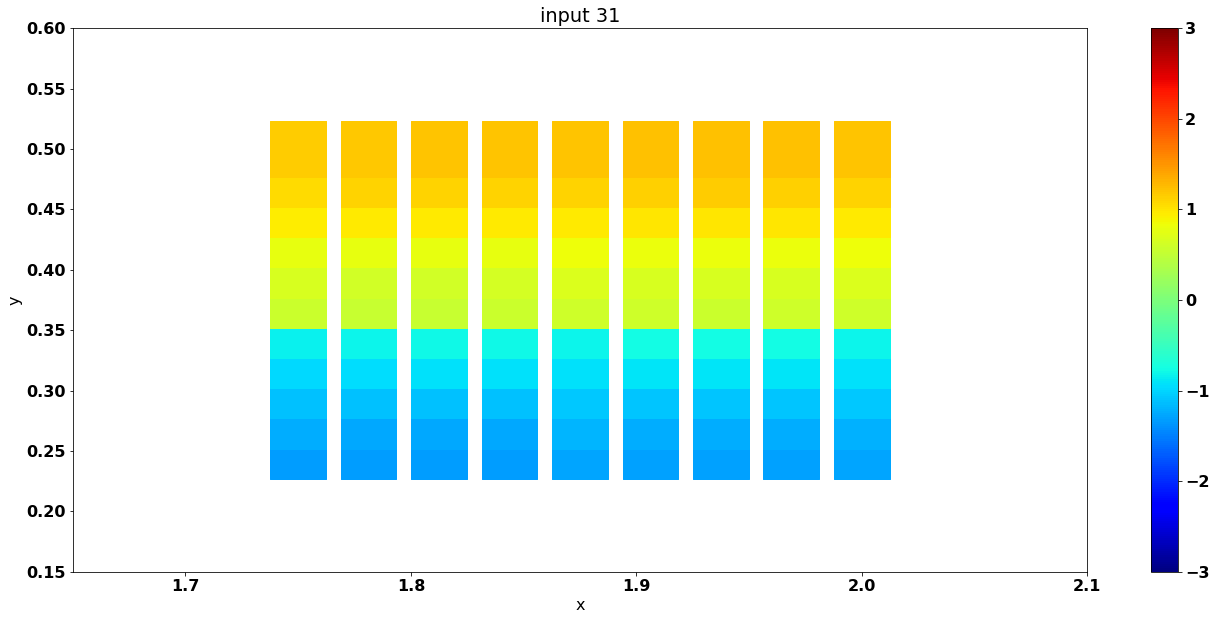

In [37]:
for i, item in enumerate(normalized_input_list) :
  plot_capped_nodal_vect(item["nodes"][..., 0], item["nodes"][..., 1], 
                 item["nodes"][..., 10], "input " + str(i), 3.1e3, -3, 3)

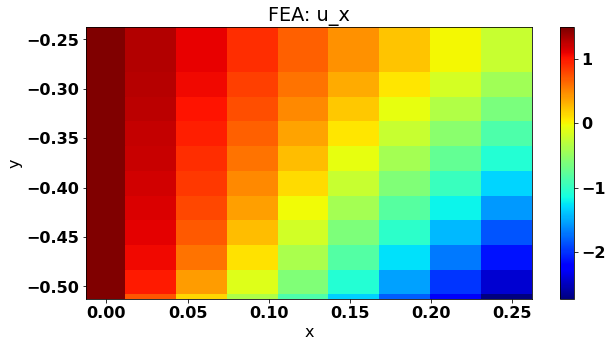

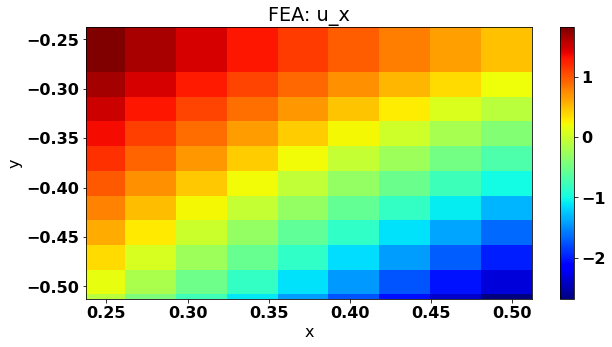

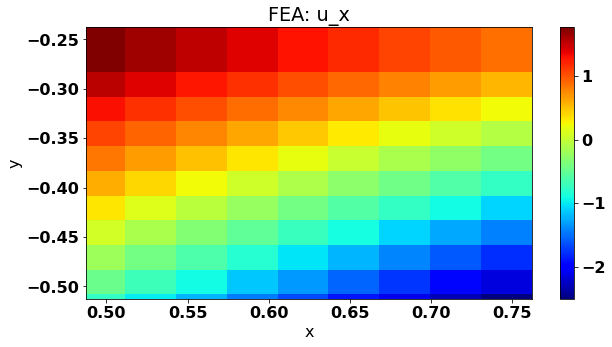

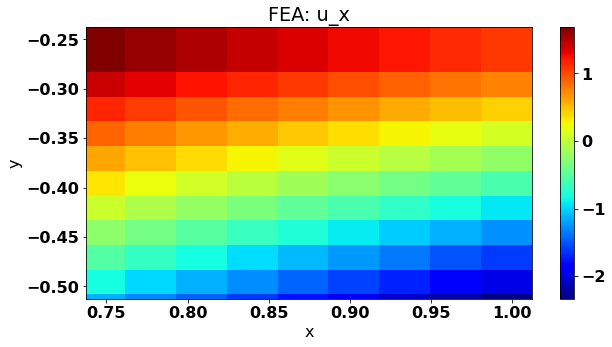

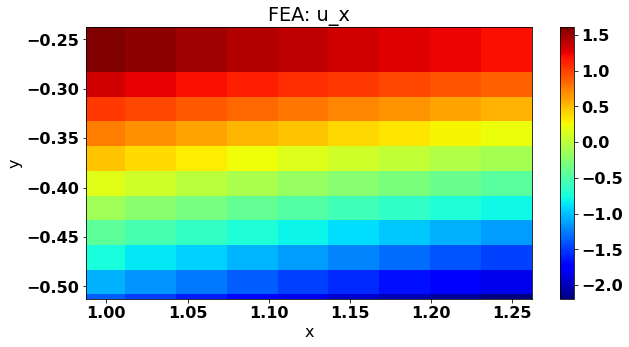

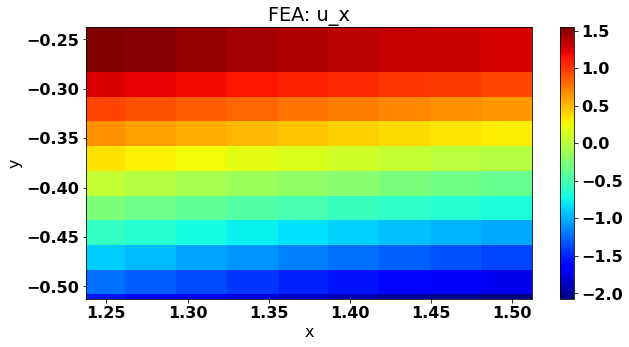

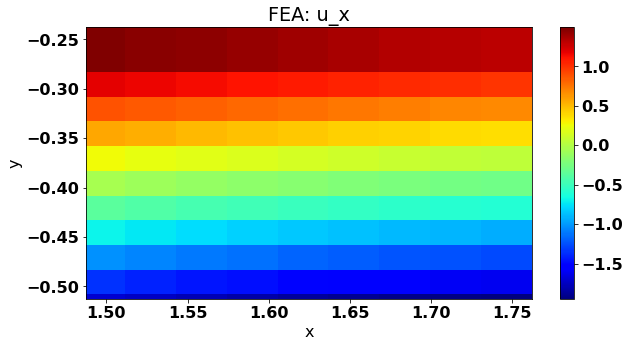

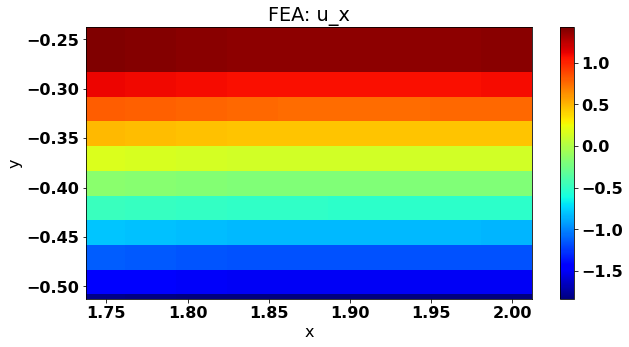

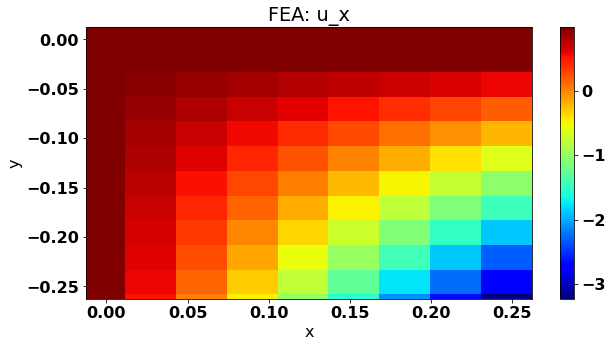

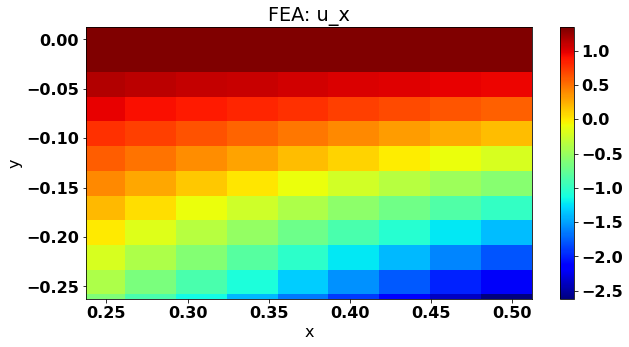

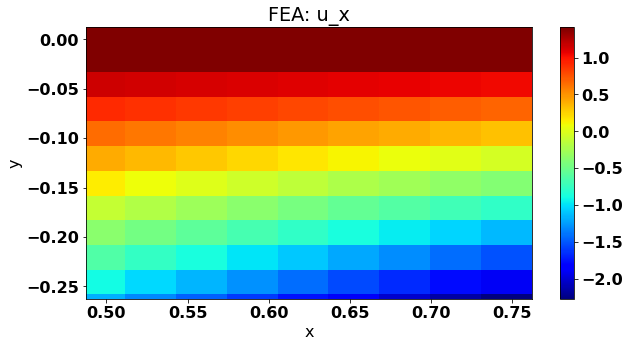

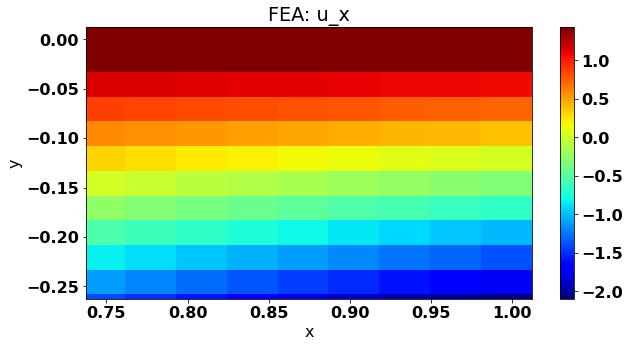

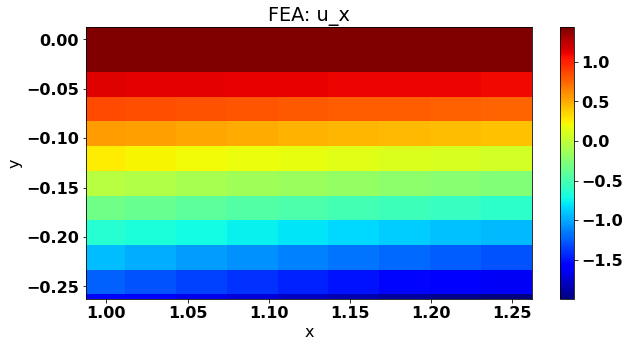

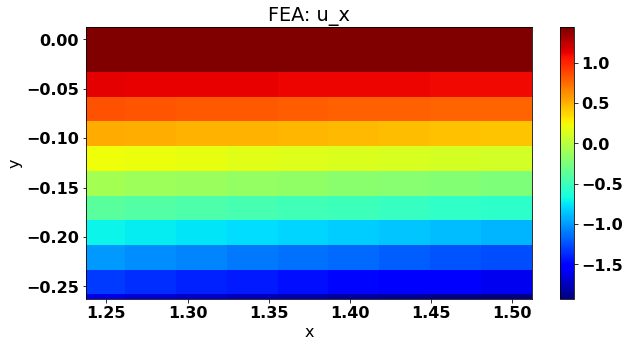

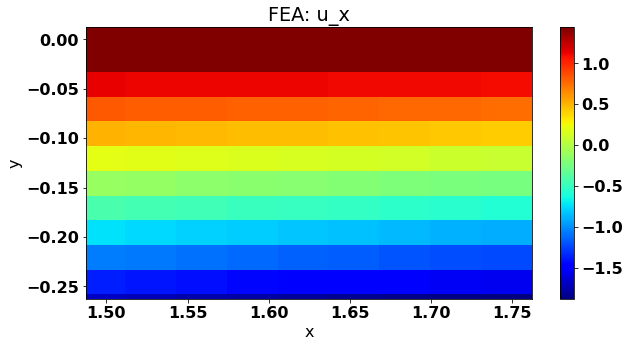

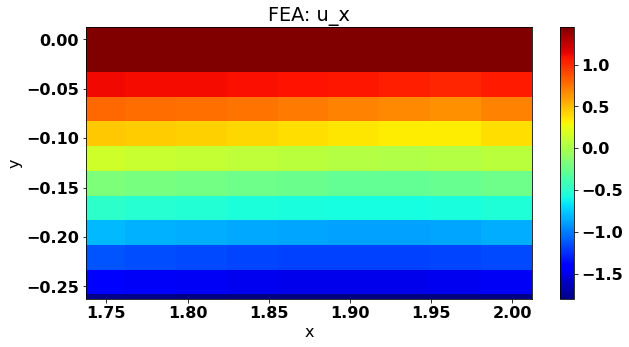

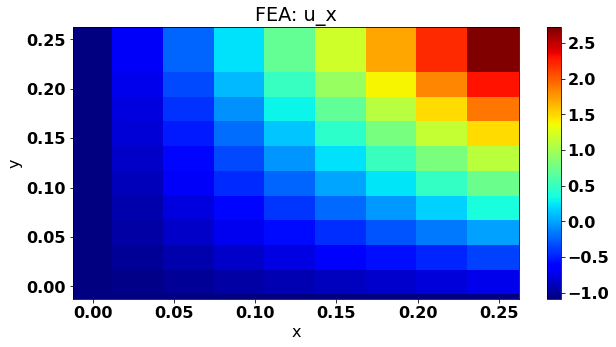

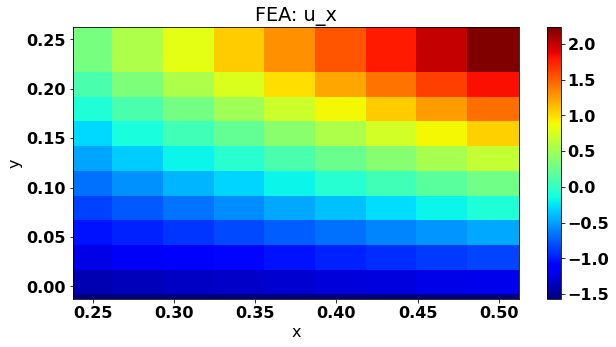

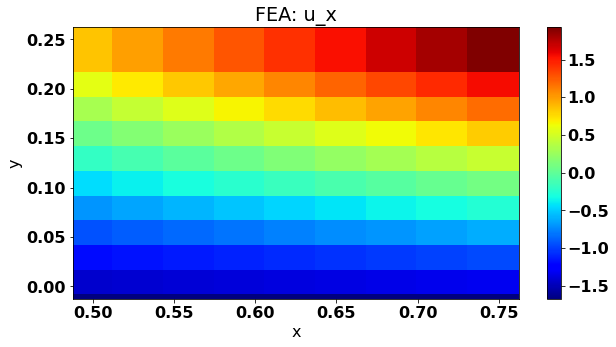

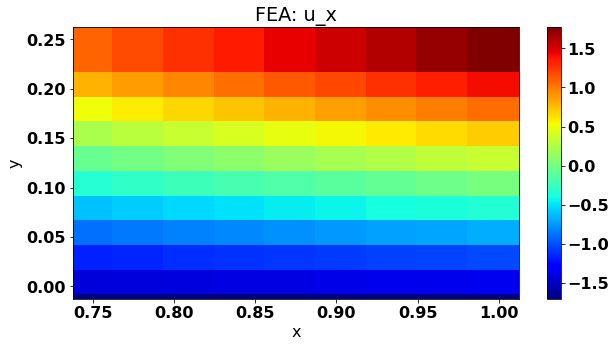

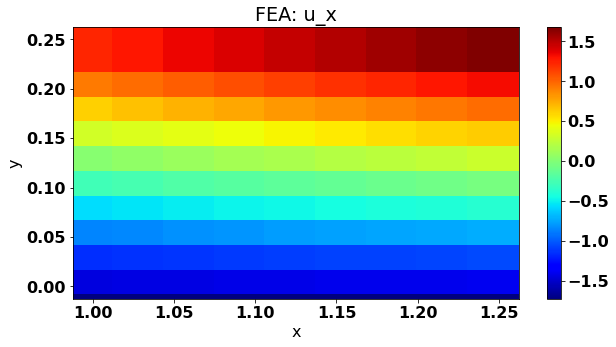

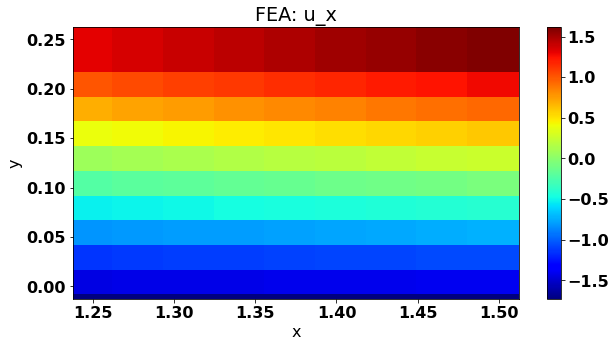

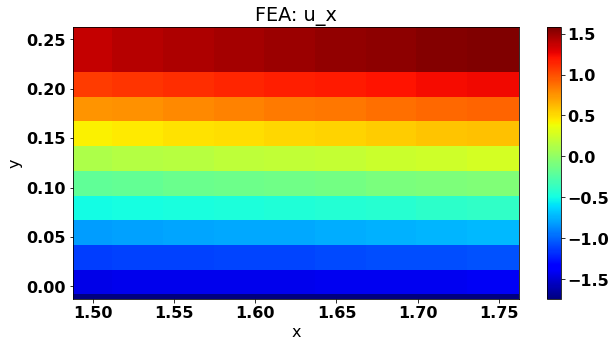

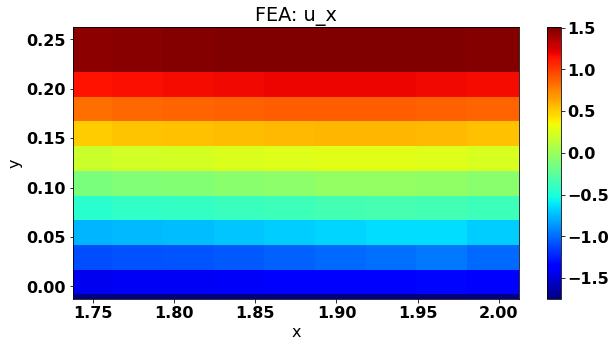

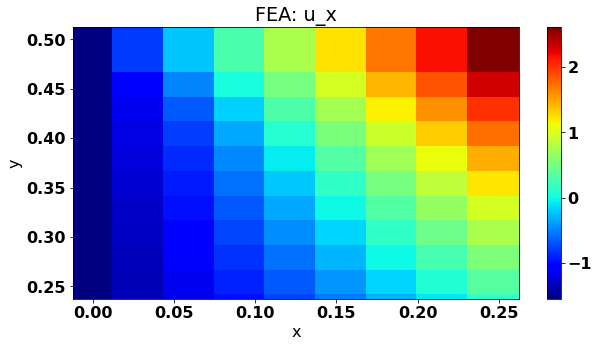

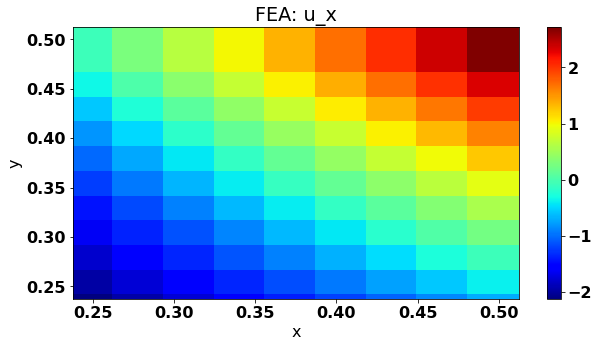

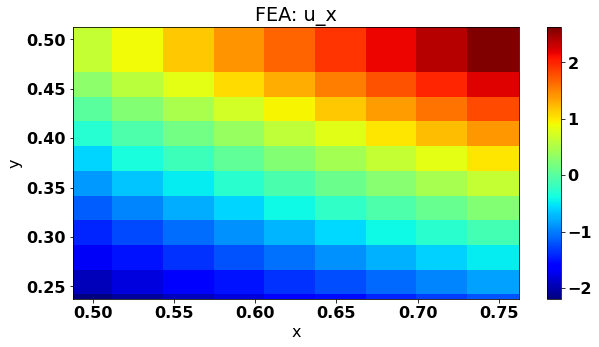

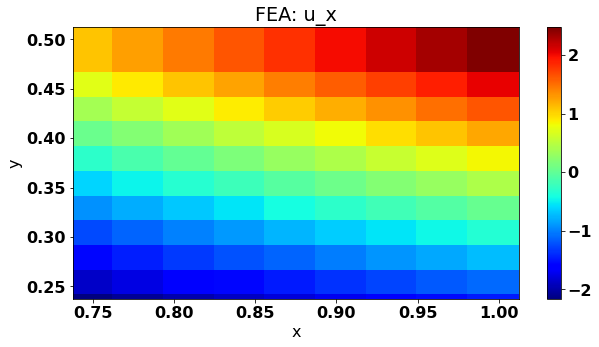

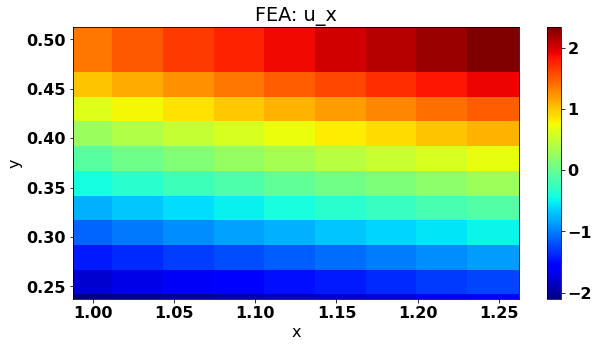

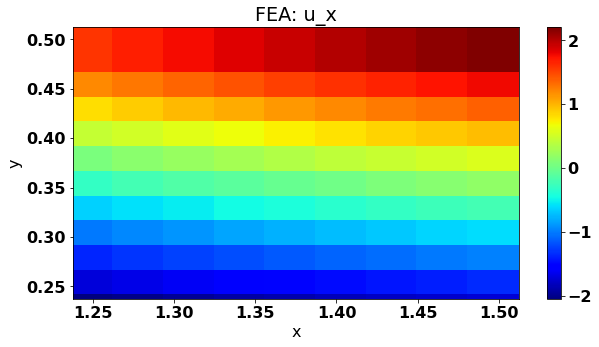

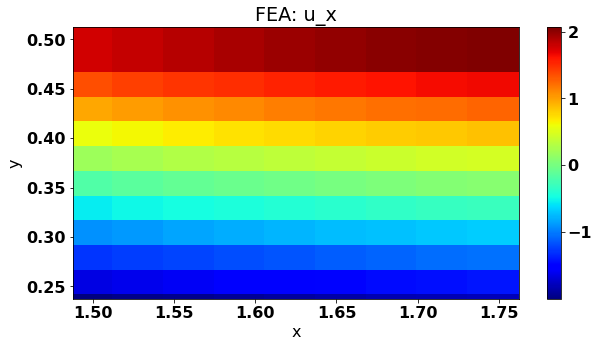

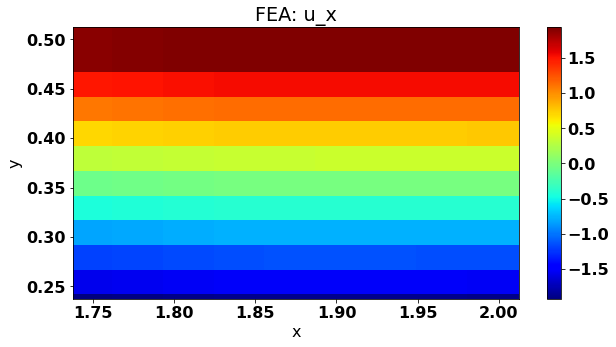

In [38]:
for item, targ in zip(normalized_input_list, normalized_target_list) :
  plot_nodal_vect(item["nodes"][..., 0], item["nodes"][..., 1], 
                 targ["nodes"][..., 0], "FEA: u_x", 4e3)

## Convergence, compliance

Residual of Reaction: 1.1567026376724243e-06


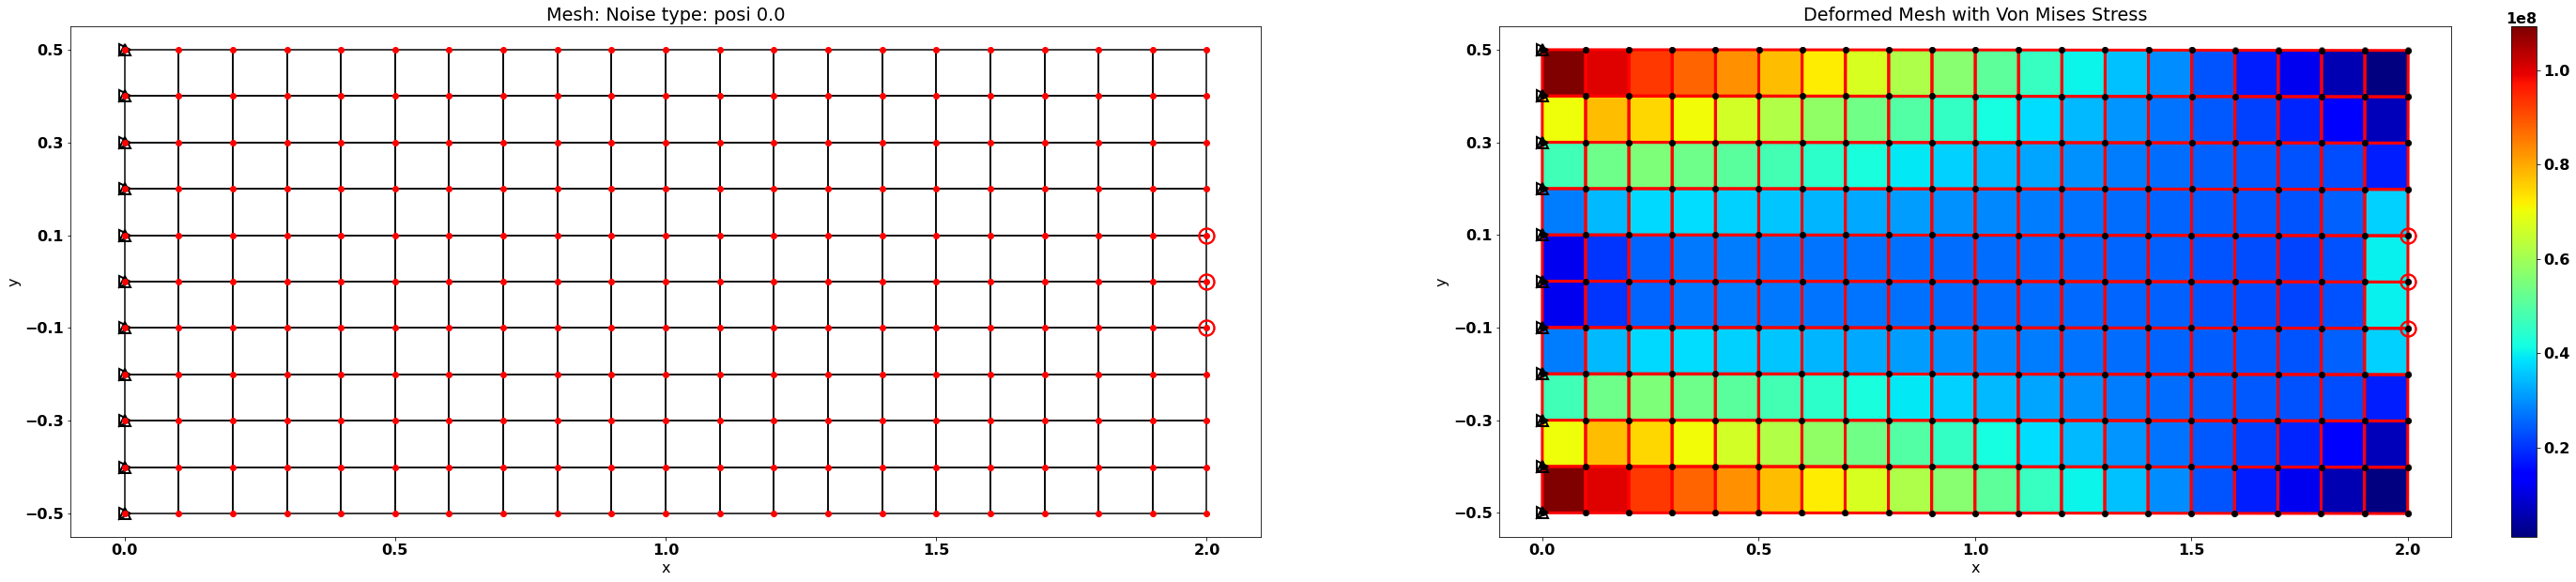

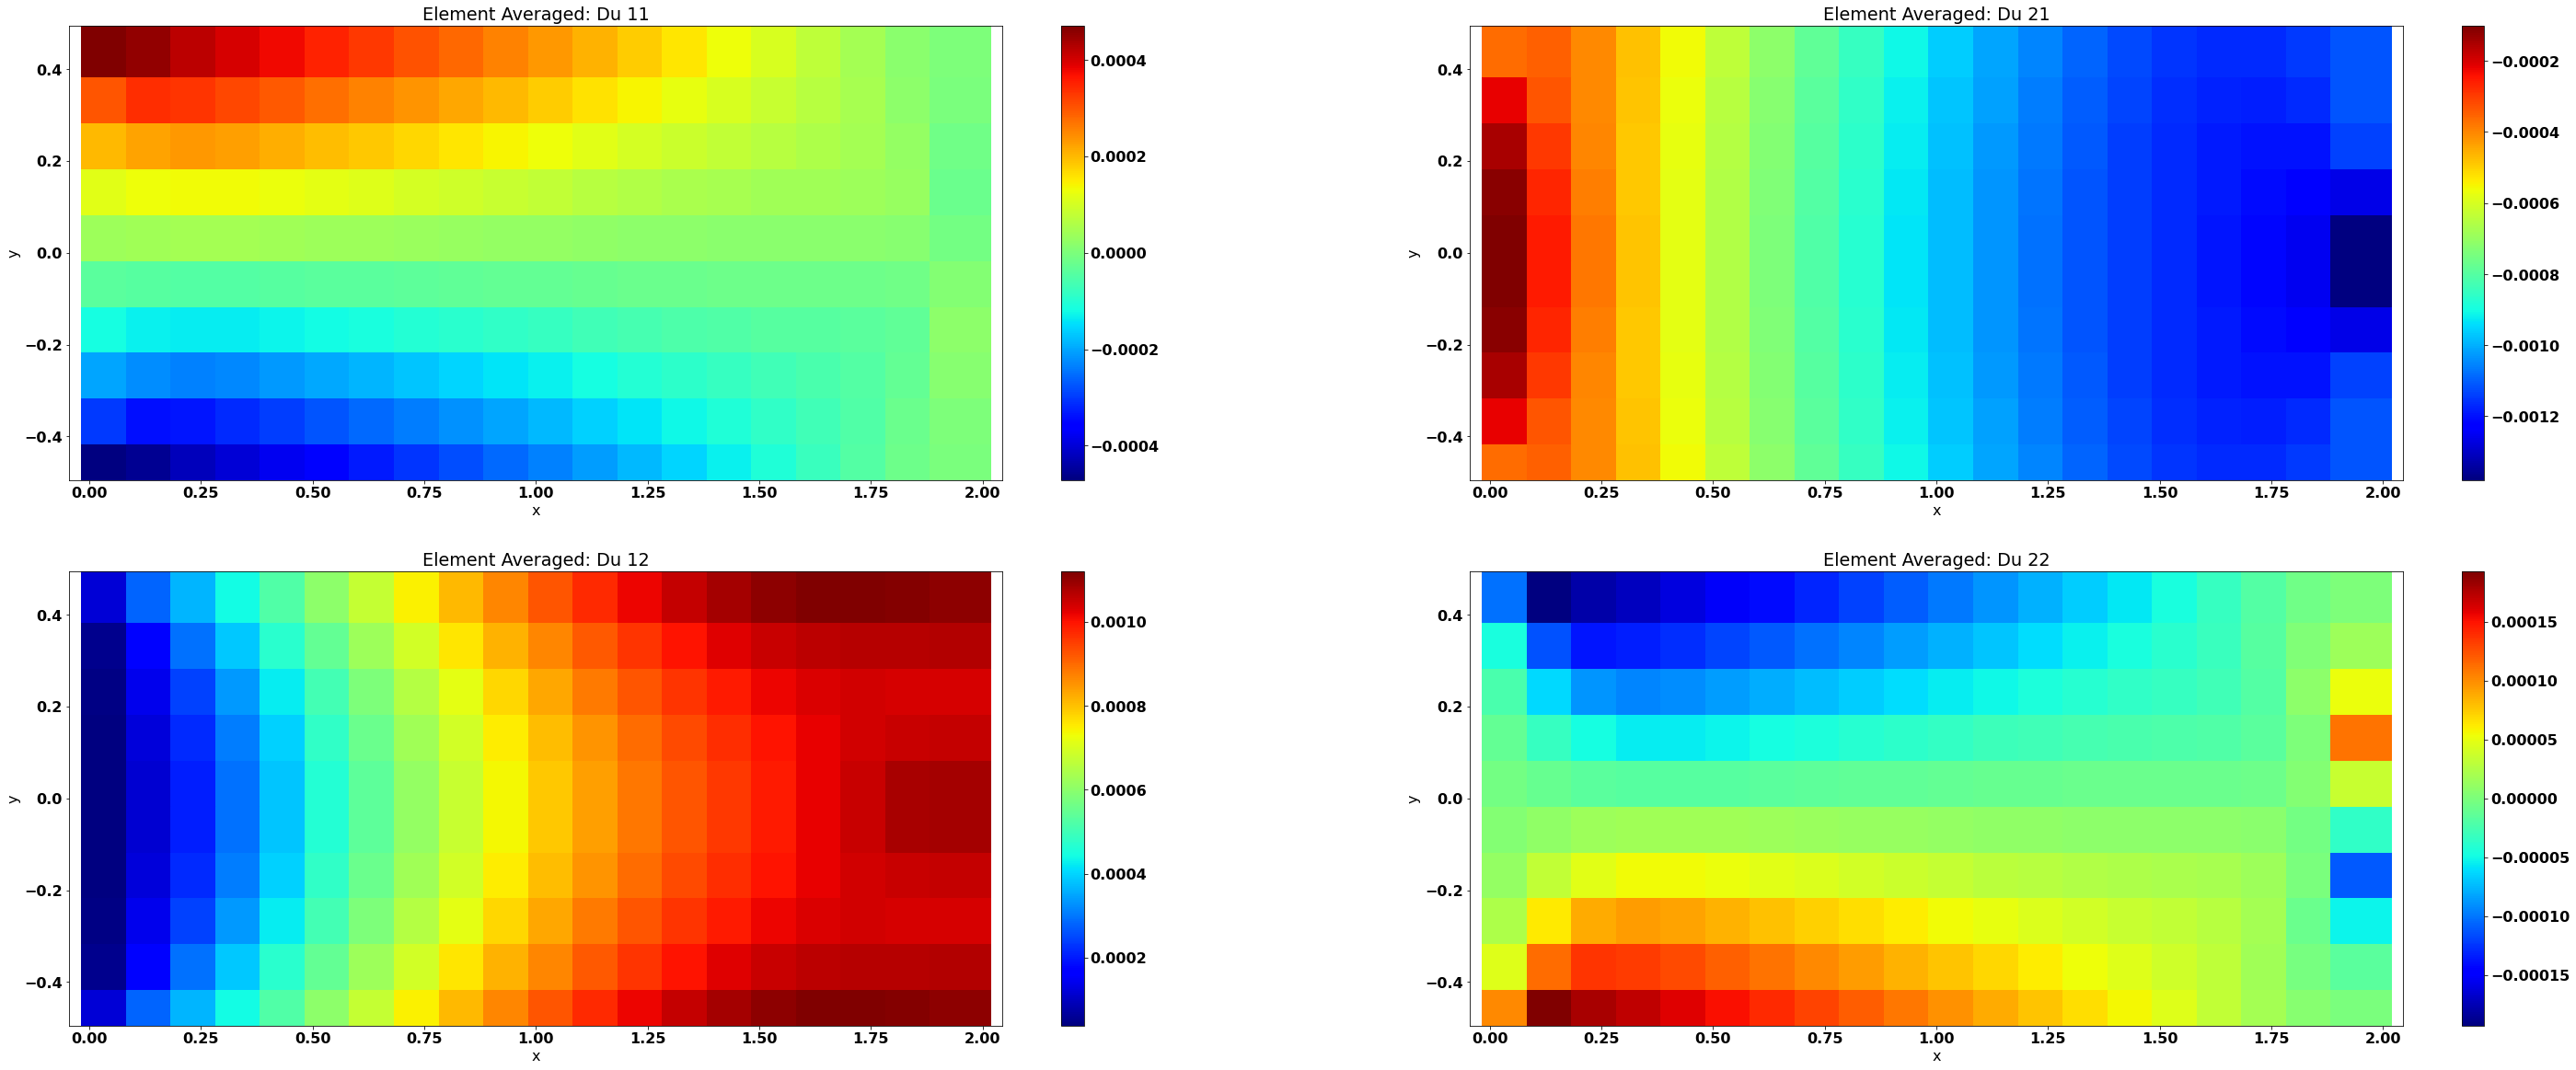

Compliance results
8668.434418311226
8668.434418310779


In [39]:
elem_type = "quad"
E = 200e9
v = 0.3
applied_force_dofs = [0, 1]
applied_force_vals = [0, -1e7]
body_force = [0.0, 0.0]
m1 = 20
m2 = 10
bound_x = [0.0, 2.0]
bound_y = [-0.5, 0.5]

noise_type = "posi" # "posi" or "row"
support_option = "left_cantilever" # left_cantilever, right_cantilever, dual_cantilever, MBB
force_option = "side_center" # side_center, side_bottom, side_top, top_center, top_distributed
noise_coord_scale = 0.0

efficient_opt = True
mesh = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                  "posi", noise_coord_scale, 0.0)
base_density = [1]*mesh.n_elem
base_material = assign_material(elem_type, mesh, E, v, base_density)
bc = assign_BC_option(mesh, applied_force_vals, applied_force_dofs, body_force,
                     support_option, force_option)
fea = assemble_matrices(elem_type, mesh, base_material, bc, efficient_opt)
results = solve_FEA(mesh, bc, fea)
print("Residual of Reaction: {}".format(sum(results.R[...,0]) + applied_force_vals[1]))

nodal_stress, elem_stress = get_stress_gauss(elem_type, mesh, base_material, results)
nodal_du, elem_du = get_dU_gauss(elem_type, mesh, results.UUR.T )

annotations = False
alternate_title = "Noise type: " + noise_type + " " + str(noise_coord_scale)
plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh, bc, results.UUR, elem_stress.T[-1,...])
title= "Element Averaged: Du"
plot_elem_attr(elem_type, title, mesh, elem_du)

print("Compliance results")
KUR = np.asarray(fea.KUR.todense())
print(compliance_viaKUR_mod(KUR, results.UUR)/2)
print(compliance_viaP(bc, results)/2)

In [40]:
elem_type = "quad"
E = 200e9
v = 0.3
applied_force_dofs = [0, 1]
applied_force_vals = [0, -1e7]
body_force = [0.0, 0.0]
m1 = 20
m2 = 10
bound_x = [0.0, 2.0]
bound_y = [-0.5, 0.5]
support_option, force_option = "left_cantilever", "side_center"
noise_type, noise_coord_scale, refine_fract = "posi", 0.0, 0.0

efficient_opt = False
m1_a = 200
m2_a = 100
mesh = build_mesh(elem_type, m1_a, m2_a, bound_x, bound_y,
                  noise_type, noise_coord_scale, refine_fract)
base_density = [1]*mesh.n_elem
base_material = assign_material(elem_type, mesh, E, v, base_density)
bc = assign_BC_option(mesh, applied_force_vals, applied_force_dofs, body_force,
                     support_option, force_option)
fea = assemble_matrices(elem_type, mesh, base_material, bc, efficient_opt)
results = solve_FEA(mesh, bc, fea)
uur_known = results.UUR.T

In [41]:
logged_elems = []
logged_l2 = []
logged_uur = []
logged_err_avg = []
logged_err_max = []
logged_err_min = []
x_nodes = []
m1_list = [20, 40, 100]
m2_list = [int(val/2) for val in m1_list]
##############################################################################

for i, (m1_b, m2_b) in enumerate(zip(m1_list, m2_list)) :
  print(i, ": ", m1_b, "x", m2_b)
  mesh = build_mesh(elem_type, m1_b, m2_b, bound_x, bound_y,
                    "posi", 0.0, 0.0)
  base_density = [1]*mesh.n_elem
  base_material = assign_material(elem_type, mesh, E, v, base_density)
  bc = assign_BC_option(mesh, applied_force_vals, applied_force_dofs, body_force,
                      support_option, force_option)
  fea = assemble_matrices(elem_type, mesh, base_material, bc, efficient_opt)
  results = solve_FEA(mesh, bc, fea)

  uur_b = project_known_displacement(m1_a, m2_a, m1_b, m2_b, uur_known)
  l2 = np.linalg.norm(uur_b - results.UUR.T)

  err_tst_edges, avg_err_tst, max_tst, min_tst = get_disp_err(uur_b, results.UUR.T)
  disp_b = (uur_b[..., 0]**2 + uur_b[..., 1]**2)**0.5
  disp_fea = (results.UUR.T[..., 0]**2 + results.UUR.T[..., 1]**2)**0.5
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    err_tst = np.nan_to_num(np.abs(disp_b - disp_fea) / disp_b, posinf = 0, neginf =0)
  avg_err_tst = sum(err_tst) / len(err_tst)
  max_tst = err_tst.max()
  min_tst = err_tst.min()
  print("Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))
  print("L2 Error: {:.4e}, {:.4e}".format(l2, l2 / len(uur_b.flatten())))
  
  logged_l2.append(l2)
  logged_elems.append(m1_b*m2_b)
  logged_uur.append((uur_b, results.UUR.T))
  logged_err_avg.append(avg_err_tst)
  logged_err_max.append(max_tst)
  logged_err_min.append(min_tst)
  x_nodes.append(len(uur_b.flatten()))
  # m1_b += 20
  # m2_b += 10

# del mesh
# del element_density
# del surf_nodes
# del void_nodes
# del base_material
# del bc
# del fea
# del results

0 :  20 x 10
Relative Error: avg 0.0164, max 0.0809, min 0.0000
L2 Error: 1.7115e-04, 3.7046e-07
1 :  40 x 20
Relative Error: avg 0.0059, max 0.0654, min 0.0000
L2 Error: 1.0417e-04, 6.0493e-08
2 :  100 x 50
Relative Error: avg 0.0012, max 0.0459, min 0.0000
L2 Error: 4.4812e-05, 4.3498e-09


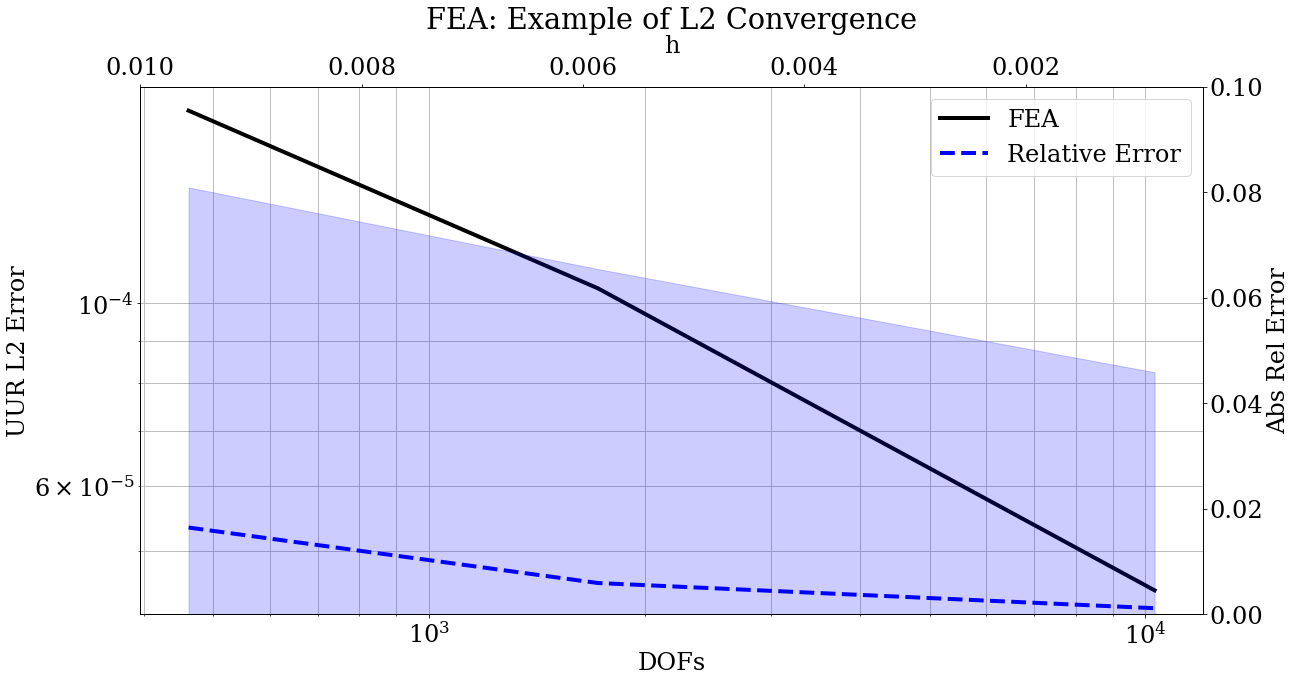

-0.43397571128443213


In [42]:
o = 0
i = 7
h = 2/np.asarray(logged_elems)[o:i]
x = np.asarray(x_nodes)[o:i]
y0 = np.asarray(logged_l2)[o:i]
avg_err = np.asarray(logged_err_avg)[o:i]
max_err = np.asarray(logged_err_max)[o:i]
min_err = np.asarray(logged_err_min)[o:i]

################################################################
error_lim = 0.1
fea_err_color = "blue"

fig = plt.figure(1, figsize=(50, 10))
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 24}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']

# Convergence
ax = fig.add_subplot(1, 3, 1)
ax.grid(True, which = 'both')
ax.set_title("FEA: Example of L2 Convergence") 
ax.set_ylabel('UUR L2 Error')
ax.set_xlabel('DOFs')
plt.xscale("log")
plt.yscale("log")
line1 = ax.plot(x, y0, c = 'k', lw = lw, label = 'FEA', zorder = 10)

# Relative Error
ax1 = ax.twinx()
ax1.set_ylim([0, error_lim])
ax1.set_ylabel('Abs Rel Error')
line2 = ax1.plot(x, avg_err, '--', c = fea_err_color, lw = lw, label = 'Relative Error')
line3 = ax1.fill_between(x, min_err, max_err, color = fea_err_color, alpha = 0.2, label = "Error Bounds")
# secax = ax.secondary_xaxis('top', 2/np.asarray(logged_elems)[o:i])
# secax.set_xlabel('angle [rad]')


# DOF
ax2 = ax.twiny()
ax2.set_xlabel('h')
ax2.set_xlim([h.max(), h.min()])

# Legend
lns = line1 + line2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.tight_layout()
plt.show()

# Polyfit
m, b = np.polyfit(np.log10(x), np.log10(y0), 1)
print(m)





## L Bracket

Residual of Reaction: -100000000.00000015


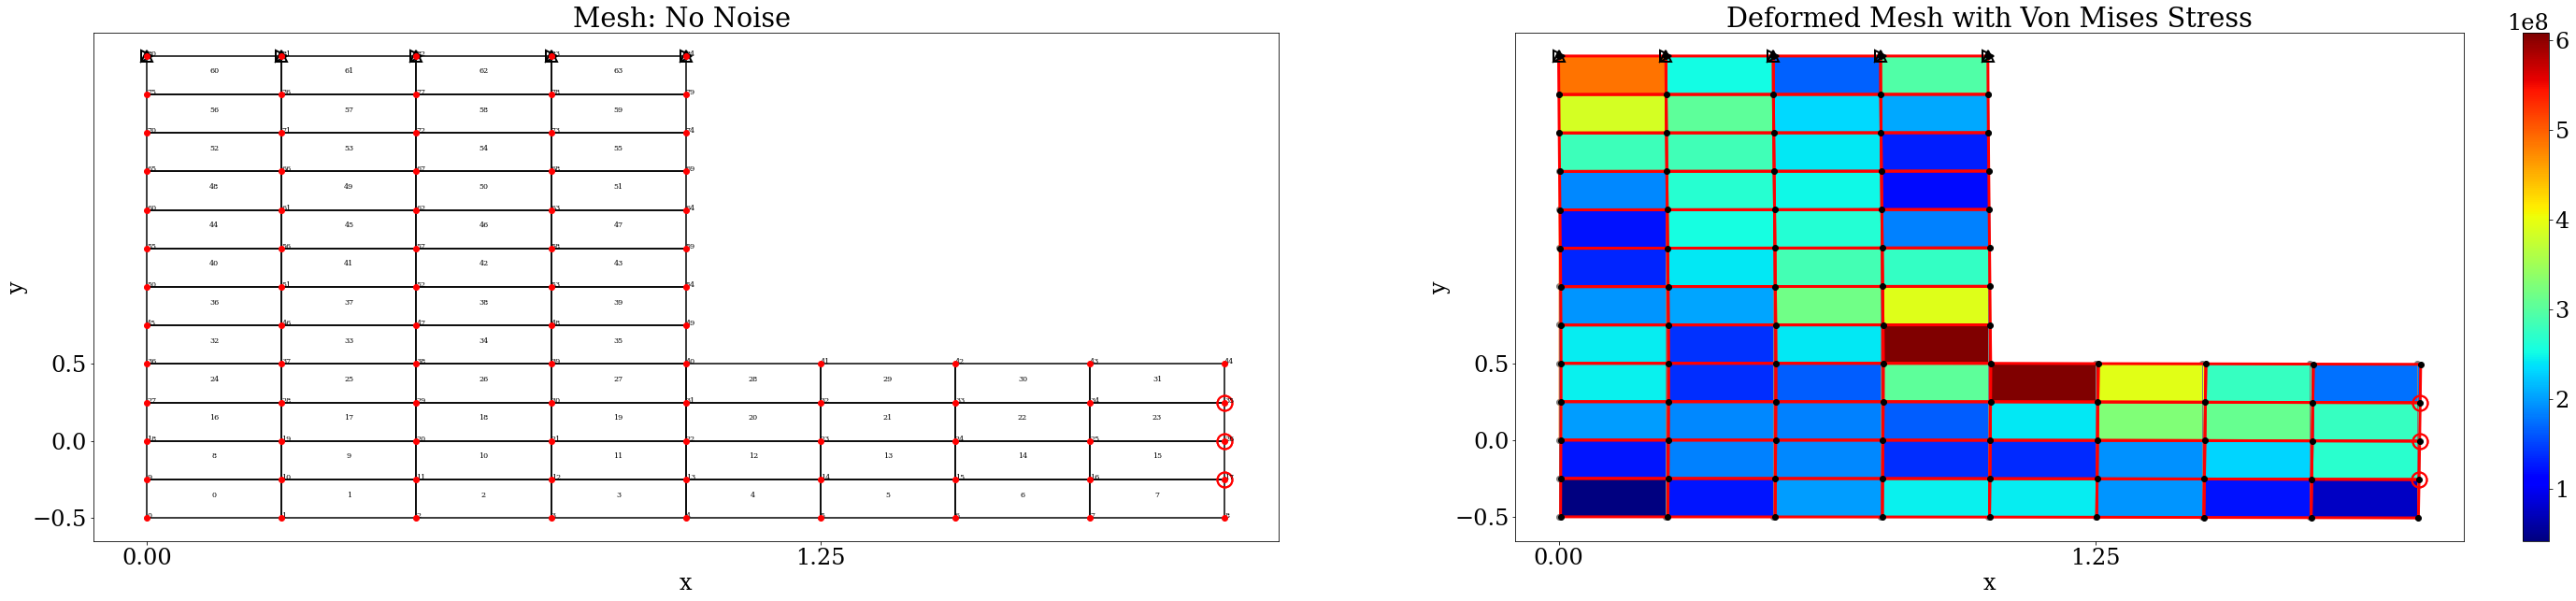

Residual of Reaction: -99999999.99996668


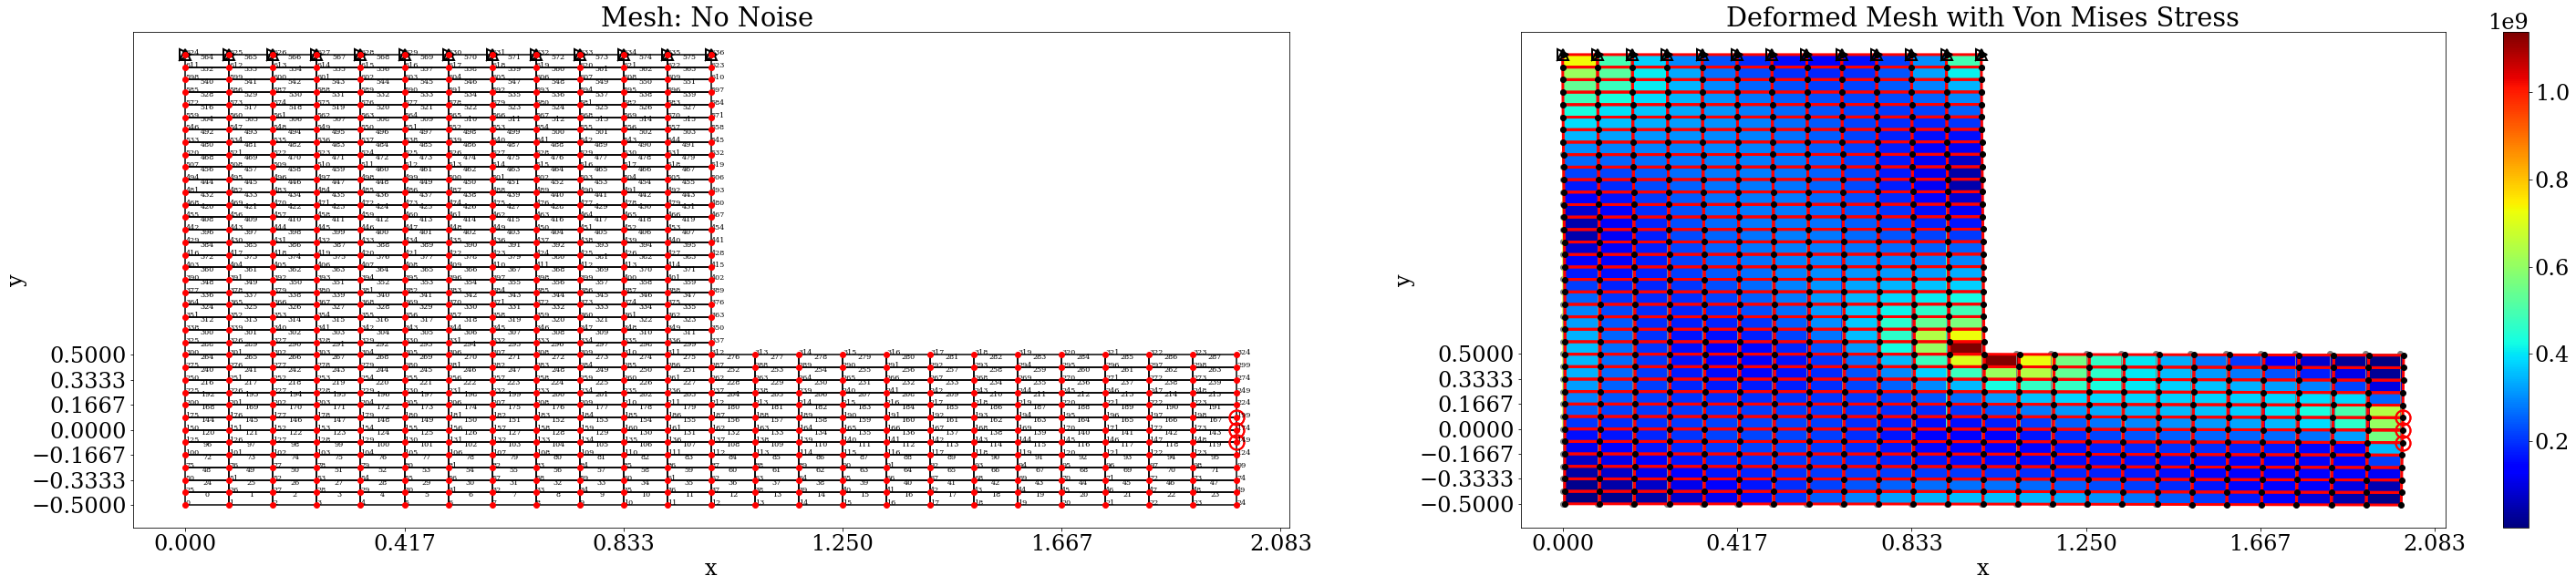

Residual of Reaction: -99999999.99992073


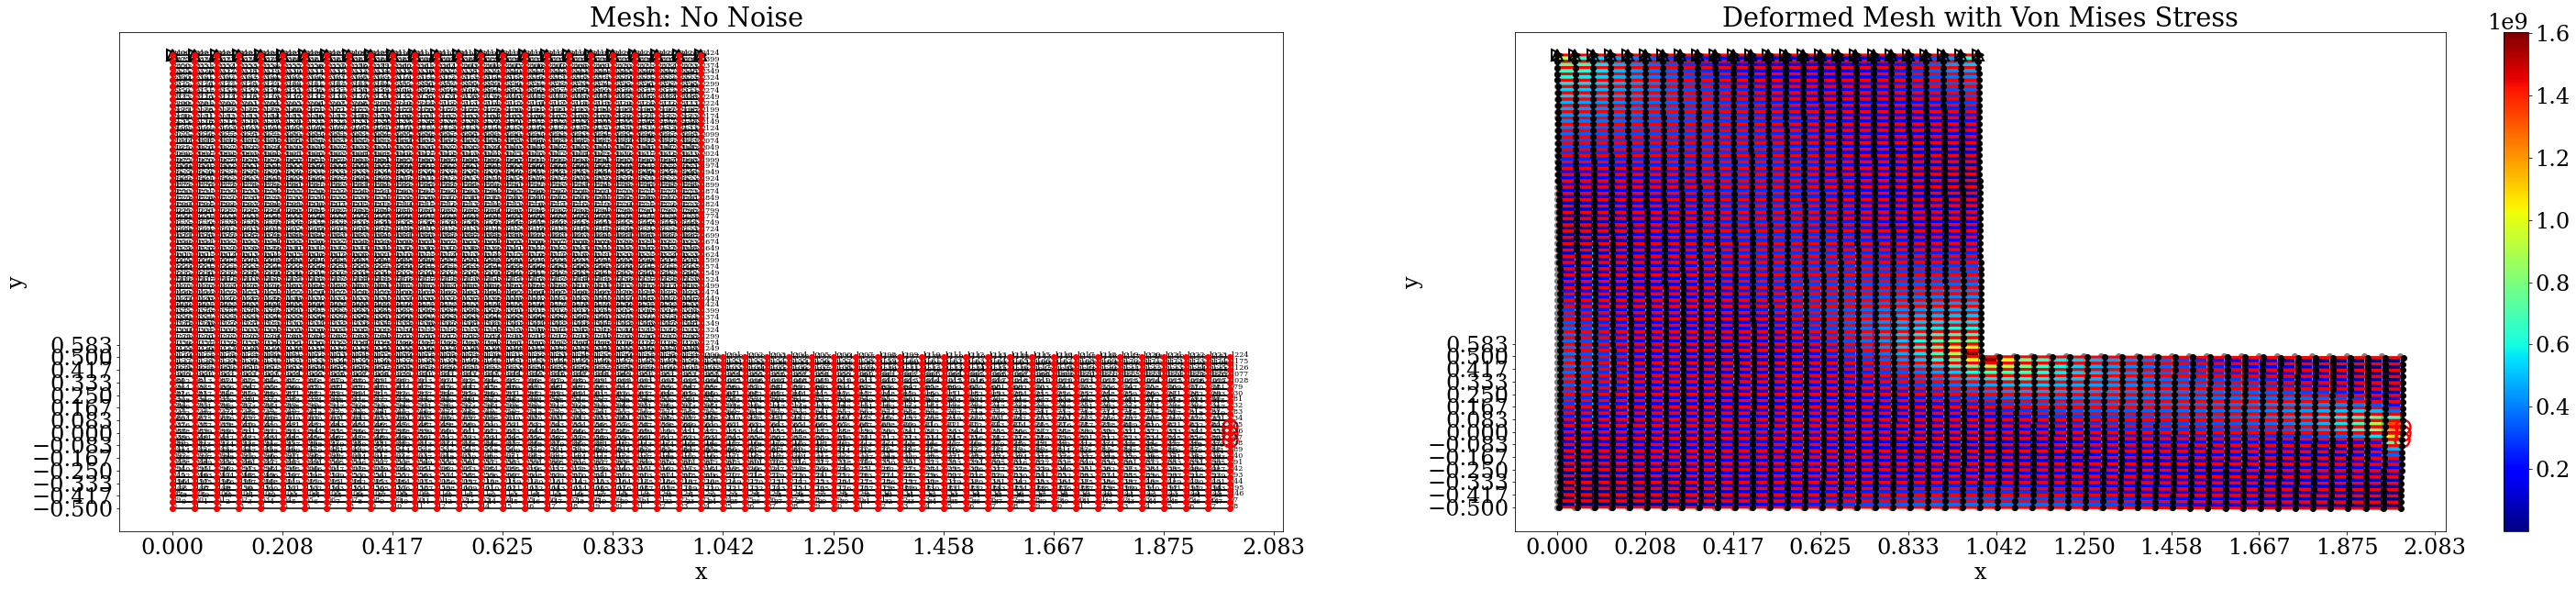

In [44]:
elem_type = "quad" # "tri" or "quad"
bound_x = (0, 2)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

applied_force_vals = (1e8, -1e8)
applied_force_dofs = (0, 1)
body_force = (0, 0)
support_options = ["left_cantilever", "right_cantilever","dual_cantilever", "MBB"]
force_options = ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
support_opt = "L_bracket"
force_opt = "side_center"

noise_type = "posi" # "posi" or "row"
noise_coord_scale = 0.0
refine_fract = 0.2 # only affect tri elems

##############################################################################
m1 = 8
m2 = 4
efficient_opt = False
if support_opt == "L_bracket" :
  mesh_0 = build_mesh_L_bracket(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
else :
  mesh_0 = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
element_density_0 = [1]*mesh_0.n_elem
surf_nodes_0  = [1]*mesh_0.n_node
void_nodes_0  = [1]*mesh_0.n_node
base_material_0 = assign_material(elem_type, mesh_0, E, v, element_density_0)
bc_0 = assign_BC_option(mesh_0, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_0 = assemble_matrices(elem_type, mesh_0, base_material_0, bc_0, efficient_opt)
results_0 = solve_FEA(mesh_0, bc_0, fea_0)
print("Residual of Reaction: {}".format(sum(results_0.R[...,0]) + applied_force_vals[1]))

nodal_stress_0, elem_stress_0 = get_stress_gauss(elem_type, mesh_0, base_material_0, results_0)
nodal_du_0, elem_du = get_dU_gauss(elem_type, mesh_0, results_0.UUR.T )


annotations = True
alternate_title = "No Noise "
plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_0, bc_0, results_0.UUR, elem_stress_0.T[-1,...])
##############################################################################
m1 = 24
m2 = 12
efficient_opt = False
if support_opt == "L_bracket" :
  mesh_p = build_mesh_L_bracket(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
else :
  mesh_p = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
element_density_p = [1]*mesh_p.n_elem
surf_nodes_p  = [1]*mesh_p.n_node
void_nodes_p  = [1]*mesh_p.n_node
base_material_p = assign_material(elem_type, mesh_p, E, v, element_density_p)
bc_p = assign_BC_option(mesh_p, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_p = assemble_matrices(elem_type, mesh_p, base_material_p, bc_p, efficient_opt)
results_p = solve_FEA(mesh_p, bc_p, fea_p)
print("Residual of Reaction: {}".format(sum(results_p.R[...,0]) + applied_force_vals[1]))

nodal_stress_p, elem_stress_p = get_stress_gauss(elem_type, mesh_p, base_material_p, results_p)
nodal_du_p, elem_du = get_dU_gauss(elem_type, mesh_p, results_p.UUR.T )

plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_p, bc_p, results_p.UUR, elem_stress_p.T[-1,...])


##############################################################################
m1 = 48
m2 = 24
MS_noise_type = "posi"
MS_noise_scale = 0.0 # 0.2


efficient_opt = False
if support_opt == "L_bracket" :
  mesh_1 = build_mesh_L_bracket(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
else :
  mesh_1 = build_mesh(elem_type, m1, m2, bound_x, bound_y,
                    noise_type, noise_coord_scale, refine_fract)
mesh_1.coords = noise_mesh_MS(MS_noise_type, MS_noise_scale, mesh_p, mesh_1)
element_density_1 = [1]*mesh_1.n_elem
base_density_1 = [1]*mesh_1.n_elem
surf_nodes_1  = [1]*mesh_1.n_node
void_nodes_1  = [1]*mesh_1.n_node
base_material_1 = assign_material(elem_type, mesh_1, E, v, element_density_1)
bc_1 = assign_BC_option(mesh_1, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_1 = assemble_matrices(elem_type, mesh_1, base_material_1, bc_1, efficient_opt)
results_1 = solve_FEA(mesh_1, bc_1, fea_1)
print("Residual of Reaction: {}".format(sum(results_1.R[...,0]) + applied_force_vals[1]))

nodal_stress_1, elem_stress_1 = get_stress_gauss(elem_type, mesh_1, base_material_1, results_1)
nodal_du_1, elem_du = get_dU_gauss(elem_type, mesh_1, results_1.UUR.T )

plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_1, bc_1, results_1.UUR, elem_stress_1.T[-1,...])


## Hole - conformining, bi-material

In [47]:
def build_mesh_hole(elem_type, m1, m2, bound_x, bound_y, 
               noise_type, noise_coord_scale, refine_fract,
               center = [1.0, 0.0], radius = 0.0) :
  # Building Mesh
  precision_base = 8
  dim = 2 # i.e. 2d
  nodes_per_elem = 4
  d1 = (bound_x[1] - bound_x[0])/m1
  d2 = (bound_y[1] - bound_y[0])/m2
  nodes_per_elem = 4
  n_elem = m1 * m2
  n_node = (m1 + 1) * (m2 + 1)
  hole_density = [1]*n_elem


  # count coords row-wise, bottom to top, then apply noise
  # hole_bound_x = [center[0]-radius, center[0]+radius]
  # hole_bound_y = [center[1]-radius, center[1]+radius]
  # border_bound_x = [center[0]-radius-d1, center[0]+radius+d1]
  # border_bound_y = [center[1]-radius-d2, center[1]+radius+d2]
  border_bound_x = [center[0]-radius, center[0]+radius]
  border_bound_y = [center[1]-radius, center[1]+radius]
  hole_bound_x = [center[0]-radius+d1, center[0]+radius-d1]
  hole_bound_y = [center[1]-radius+d2, center[1]+radius-d2]
  node_i = 0
  coords = []
  skip_nodes = []
  border_nodes = []
  for j in range(m2 + 1) :
    for i in range(m1 +1) :
      x = round(bound_x[0] + d1*i, precision_base)
      y = round(bound_y[0] + d2*j, precision_base)
      if ((x >= hole_bound_x[0]) and (x <= hole_bound_x[1]) and 
          (y >= hole_bound_y[0]) and (y <= hole_bound_y[1])) :
        skip_nodes.append(node_i)
        coords.append([x, y])
        # n_node -= 1
      elif ((x >= border_bound_x[0]) and (x <= border_bound_x[1]) and 
        (y >= border_bound_y[0]) and (y <= border_bound_y[1])) :
        border_nodes.append(node_i)
        try :
          theta = np.arctan(np.abs( (y-center[1])/(x-center[0])))
        except :
          theta = np.pi/2
        x_delta = radius*np.cos(theta)
        y_delta = radius*np.sin(theta)
        if x <= center[0] : 
          x = center[0] - x_delta
        else :
          x = center[0] + x_delta
        if y <= center[1] :
          y = center[1] - y_delta
        else :
          y = center[1] + y_delta
        coords.append([x, y])
      else :
        coords.append([x, y])
      node_i += 1


  # Build elements ccw from bottom left
  # Build elements ccw from bottom left
  elem_nodes = []
  elem_i = 0
  for i in range(0, (m2-1) * (m1 + 1) + 1, m1 + 1) :
    for j in range(i, i + m1) :
      elem_node = []
      elem_node.append(j)
      elem_node.append(j + 1)
      elem_node.append(j + m1 + 2)
      elem_node.append(j + m1 + 1)
      if all(i in border_nodes+skip_nodes for i in elem_node) :
        print("hit at {}".format(elem_i))
        hole_density[elem_i] = 1e-6
      elem_nodes.append(elem_node)
      elem_i += 1

  # Refine Mesh
  refined_coords = []

  # Apply noise to coordinates
  coords = noise_mesh(elem_type, noise_type, noise_coord_scale,
                      refined_coords, coords, m1, m2, d1, d2)
  
  mesh = Mesh(dim, m1, m2, d1, d2, bound_x, bound_y, nodes_per_elem, n_elem, n_node, coords, elem_nodes)

  return mesh, hole_density

hit at 131
hit at 132
hit at 155
hit at 156
Residual of Reaction: -99999999.99999383


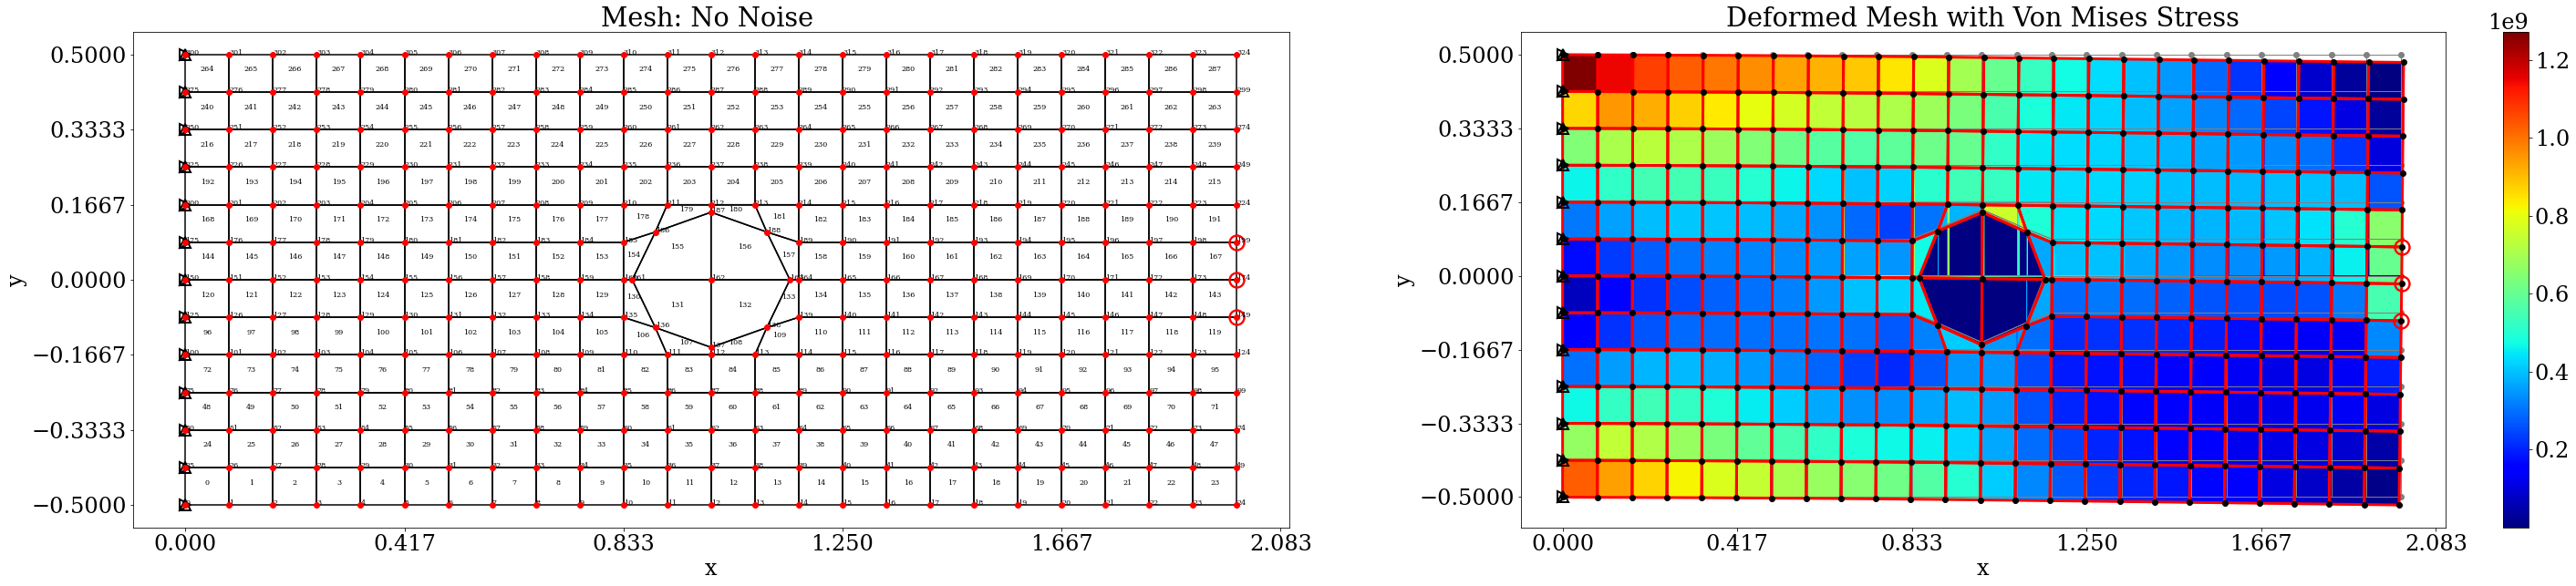

hit at 131
hit at 132
hit at 155
hit at 156
Residual of Reaction: -99999999.99999383


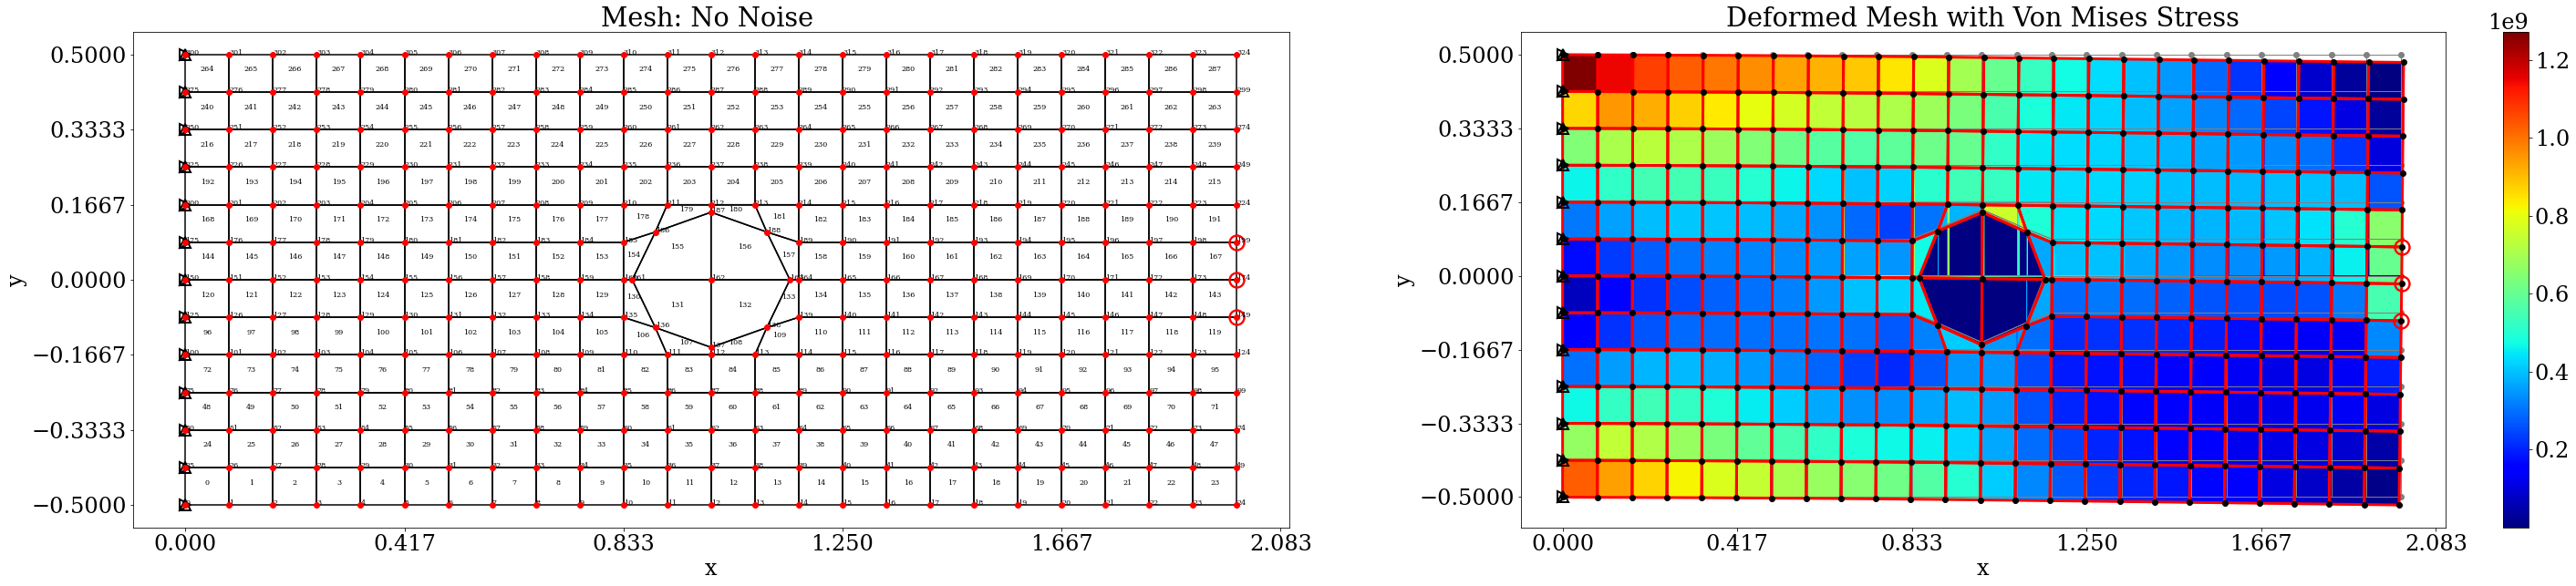

hit at 453
hit at 454
hit at 455
hit at 456
hit at 457
hit at 458
hit at 501
hit at 502
hit at 503
hit at 504
hit at 505
hit at 506
hit at 549
hit at 550
hit at 551
hit at 552
hit at 553
hit at 554
hit at 597
hit at 598
hit at 599
hit at 600
hit at 601
hit at 602
hit at 645
hit at 646
hit at 647
hit at 648
hit at 649
hit at 650
hit at 693
hit at 694
hit at 695
hit at 696
hit at 697
hit at 698
Residual of Reaction: -99999999.99994409


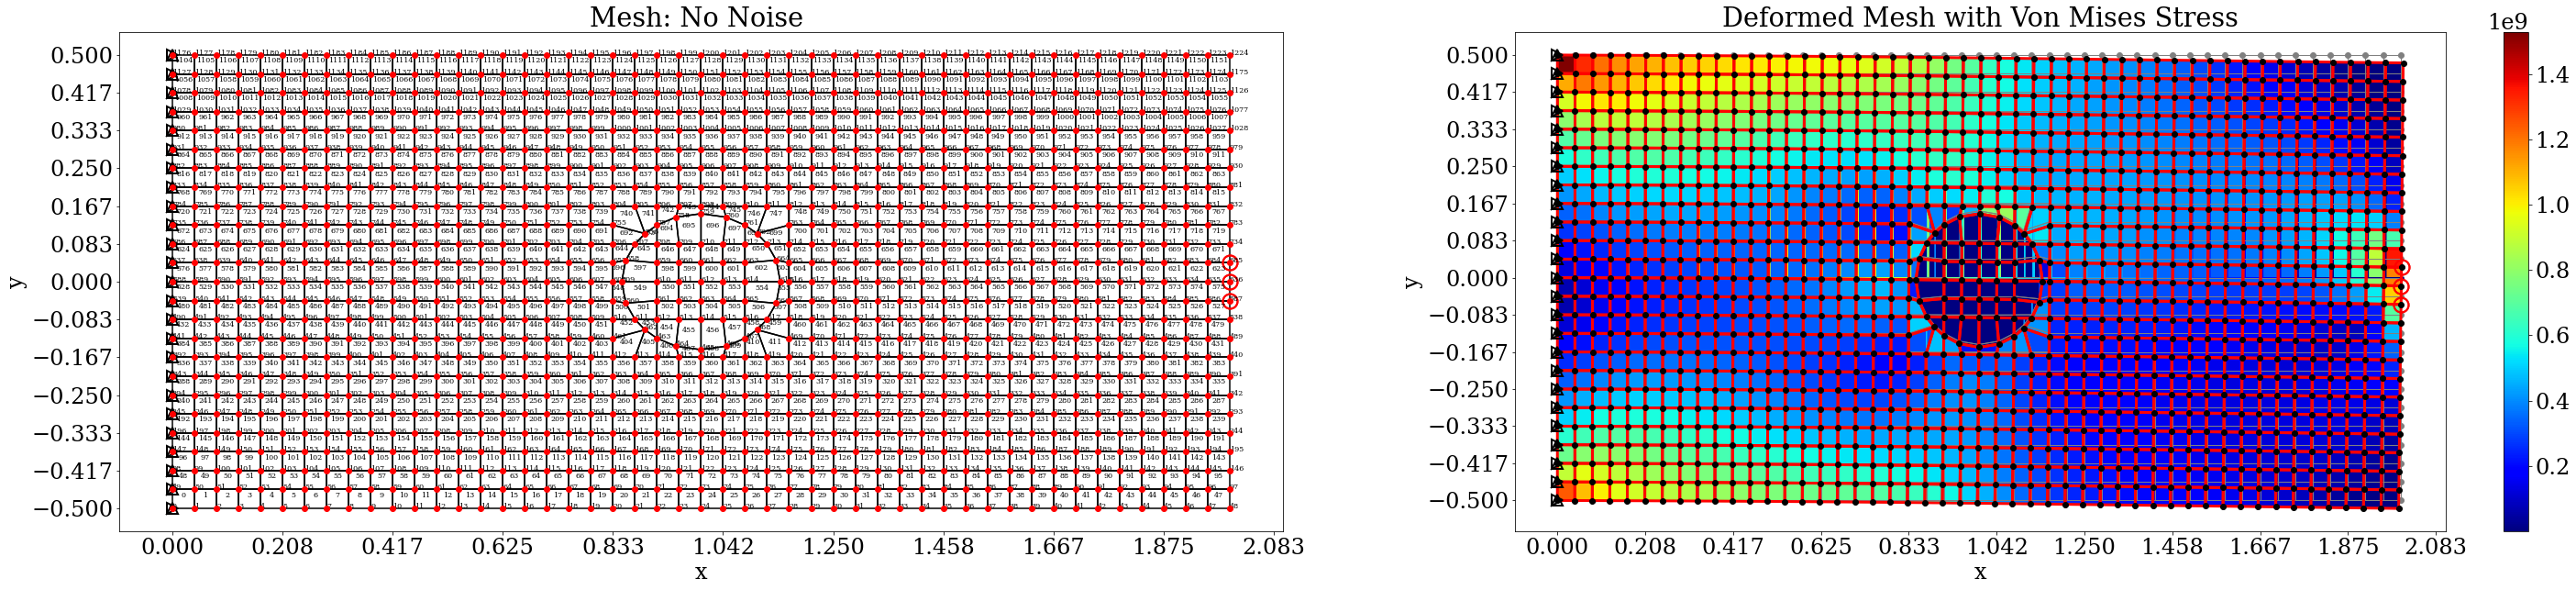

In [48]:
elem_type = "quad" # "tri" or "quad"
bound_x = (0, 2)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3
radius = 0.15

applied_force_vals = (1e8, -1e8)
applied_force_dofs = (0, 1)
body_force = (0, 0)
support_options = ["left_cantilever", "right_cantilever","dual_cantilever", "MBB"]
force_options = ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
support_opt = "left_cantilever"
force_opt = "side_center"

noise_type = "posi" # "posi" or "row"
noise_coord_scale = 0.0
refine_fract = 0.2 # only affect tri elems
special_opt = "hole"
##############################################################################
m1 = 24
m2 = 12
efficient_opt = False

mesh_0, element_density_0 = build_mesh_hole(elem_type, m1, m2, bound_x, bound_y,
                  noise_type, noise_coord_scale, refine_fract,
                  radius = radius)
  # mesh_0 = build_mesh(elem_type, m1, m2, bound_x, bound_y,
  #                   noise_type, noise_coord_scale, refine_fract)
base_material_0 = assign_material(elem_type, mesh_0, E, v, element_density_0)
bc_0 = assign_BC_option(mesh_0, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_0 = assemble_matrices(elem_type, mesh_0, base_material_0, bc_0, efficient_opt)
results_0 = solve_FEA(mesh_0, bc_0, fea_0)
print("Residual of Reaction: {}".format(sum(results_0.R[...,0]) + applied_force_vals[1]))

nodal_stress_0, elem_stress_0 = get_stress_gauss(elem_type, mesh_0, base_material_0, results_0)
nodal_du_0, elem_du = get_dU_gauss(elem_type, mesh_0, results_0.UUR.T )


annotations = True
alternate_title = "No Noise "
plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_0, bc_0, results_0.UUR, elem_stress_0.T[-1,...])
##############################################################################

##############################################################################
m1 = 24
m2 = 12
efficient_opt = False

mesh_p, element_density_p  = build_mesh_hole(elem_type, m1, m2, bound_x, bound_y,
                  noise_type, noise_coord_scale, refine_fract,
                  radius = radius)
  # mesh_p = build_mesh(elem_type, m1, m2, bound_x, bound_y,
  #                   noise_type, noise_coord_scale, refine_fract)
base_material_p = assign_material(elem_type, mesh_p, E, v, element_density_p)
bc_p = assign_BC_option(mesh_p, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_p = assemble_matrices(elem_type, mesh_p, base_material_p, bc_p, efficient_opt)
results_p = solve_FEA(mesh_p, bc_p, fea_p)
print("Residual of Reaction: {}".format(sum(results_p.R[...,0]) + applied_force_vals[1]))

nodal_stress_p, elem_stress_p = get_stress_gauss(elem_type, mesh_p, base_material_p, results_p)
nodal_du_p, elem_du = get_dU_gauss(elem_type, mesh_p, results_p.UUR.T )

plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_p, bc_p, results_p.UUR, elem_stress_p.T[-1,...])


##############################################################################
m1 = 48
m2 = 24
MS_noise_type = "posi"
MS_noise_scale = 0.0 # 0.2


efficient_opt = False

mesh_1, base_density_1 = build_mesh_hole(elem_type, m1, m2, bound_x, bound_y,
                  noise_type, noise_coord_scale, refine_fract,
                  radius = radius)
#   mesh_1 = build_mesh(elem_type, m1, m2, bound_x, bound_y,
#                     noise_type, noise_coord_scale, refine_fract)
mesh_1.coords = noise_mesh_MS(MS_noise_type, MS_noise_scale, mesh_p, mesh_1)
base_material_1 = assign_material(elem_type, mesh_1, E, v, base_density_1)
bc_1 = assign_BC_option(mesh_1, applied_force_vals, applied_force_dofs, body_force, support_opt, force_opt)
fea_1 = assemble_matrices(elem_type, mesh_1, base_material_1, bc_1, efficient_opt)
results_1 = solve_FEA(mesh_1, bc_1, fea_1)
print("Residual of Reaction: {}".format(sum(results_1.R[...,0]) + applied_force_vals[1]))

nodal_stress_1, elem_stress_1 = get_stress_gauss(elem_type, mesh_1, base_material_1, results_1)
nodal_du_1, elem_du = get_dU_gauss(elem_type, mesh_1, results_1.UUR.T )

plot_mesh(elem_type, annotations, alternate_title, bound_x, bound_y,
              mesh_1, bc_1, results_1.UUR, elem_stress_1.T[-1,...])

In [49]:
father_elems_0, graph_nodes_0 = dual_mesh_pre_process(mesh_0, mesh_1)
father_elems, graph_nodes = dual_mesh_pre_process(mesh_p, mesh_1)

input_graph_0 = get_input_graph(elem_type, mesh_0, bc_0, element_density_0, [1]*mesh_0.n_node, [1]*mesh_0.n_node)
output_graph_0 = get_output_graph(elem_type, input_graph_0, mesh_0, results_0, nodal_stress_0, nodal_du_0)

input_graph_p = get_input_graph(elem_type, mesh_p, bc_p, element_density_p, surf_nodes_p, void_nodes_p)
output_graph_p = get_output_graph(elem_type, input_graph_p, mesh_p, results_p, nodal_stress_p, nodal_du_p)

input_graph_1 = get_input_graph_dual_informed(elem_type, mesh_1, bc_1, element_density_1, surf_nodes_1, void_nodes_1,
                            father_elems_0, father_elems, graph_nodes,
                            mesh_p, output_graph_p) 
output_graph_1 = get_output_graph_informed(elem_type, input_graph_1, mesh_1, results_1, nodal_stress_1, nodal_du_1)

err_projection, avg_err_tst, max_tst, min_tst = get_disp_err(results_1.UUR.T, input_graph_1["nodes"][..., 10:12])
print("Projection Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))


Projection Error: avg 0.0462, max 0.8811, min -0.2817


In [50]:
input_sub_graph_list = []
output_sub_graph_list = []
graph_edges = []
for elem in range(mesh_0.n_elem) :
  graph_node_list = graph_nodes_0[elem]
  father_elem_node_list = father_elems_0[elem]

  ig, edge_id_list = get_input_graph_multiscale_informed(elem, input_graph_0, input_graph_1, output_graph_0, output_graph_1, 
                                                        graph_node_list, father_elem_node_list, mesh_0)
  og = get_output_graph_multiscale_informed(ig, output_graph_1, graph_node_list, edge_id_list)

  graph_edges.append(edge_id_list)
  input_sub_graph_list.append(ig)
  output_sub_graph_list.append(og)

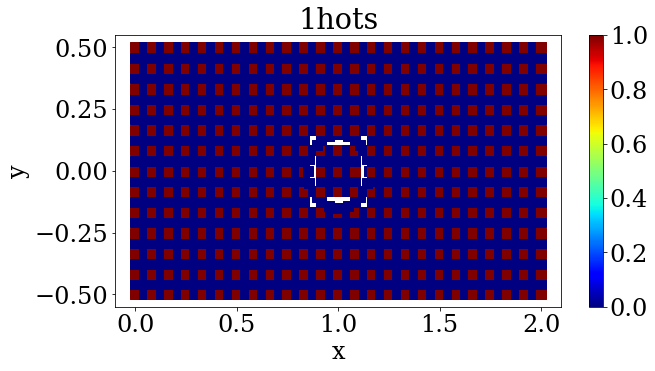

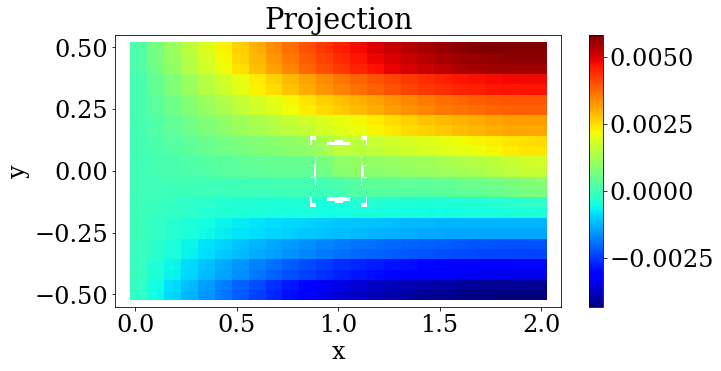

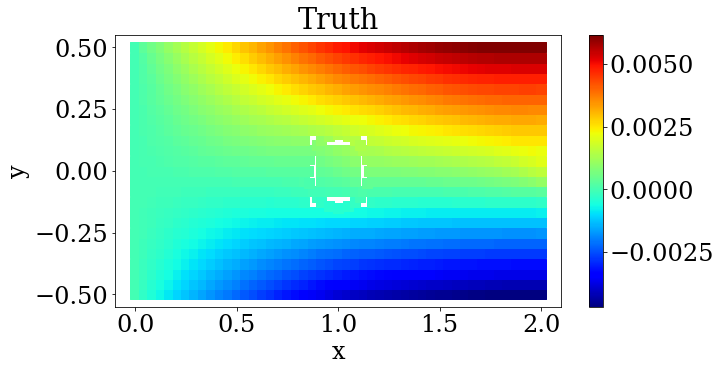

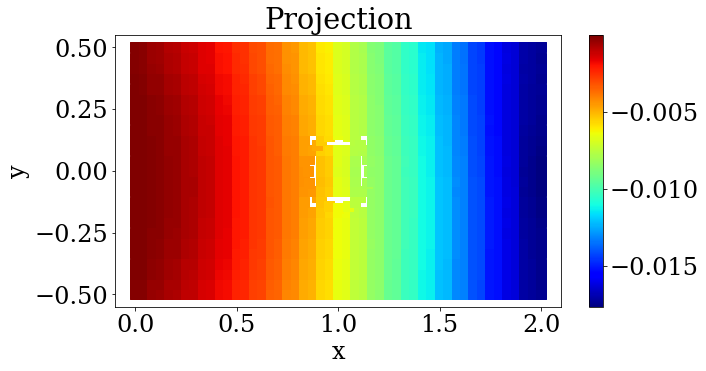

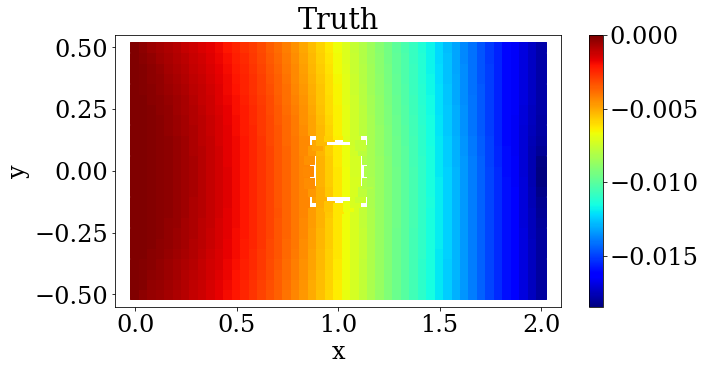

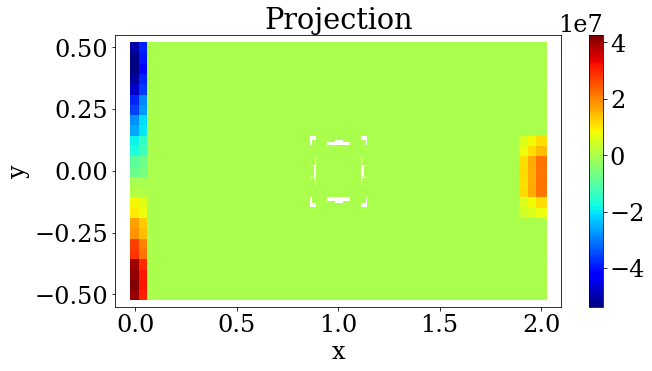

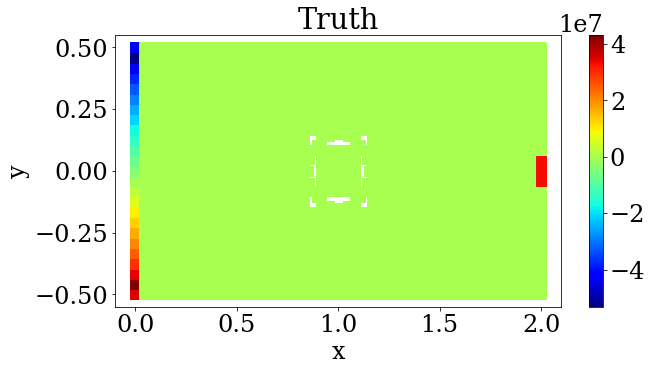

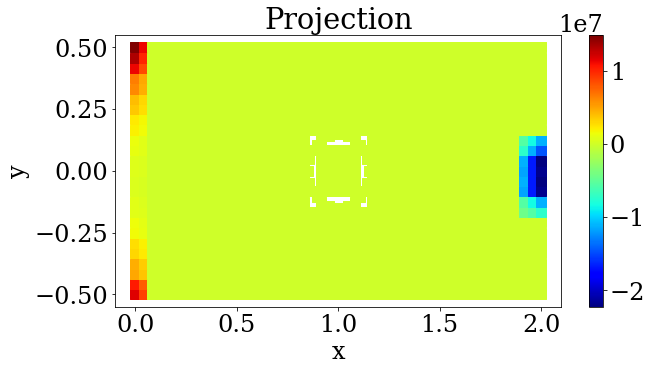

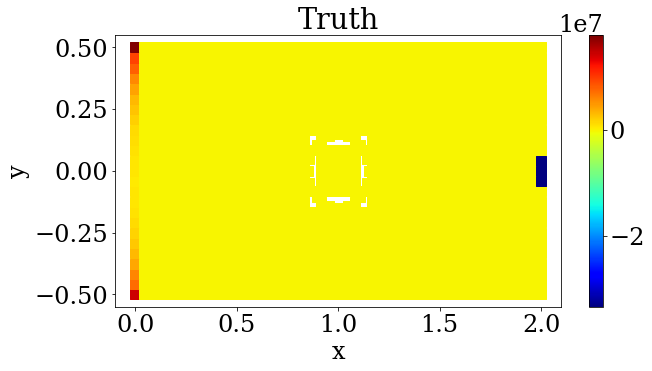

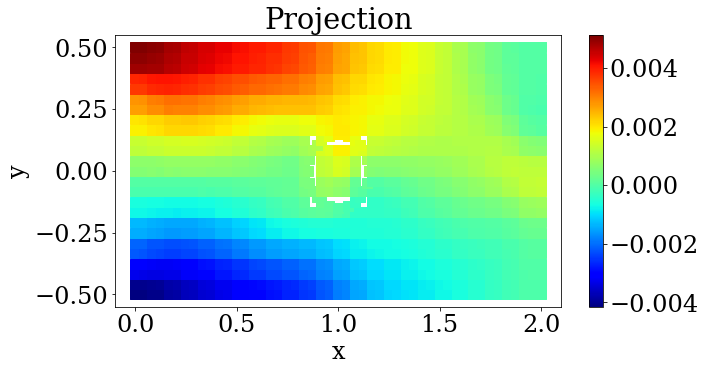

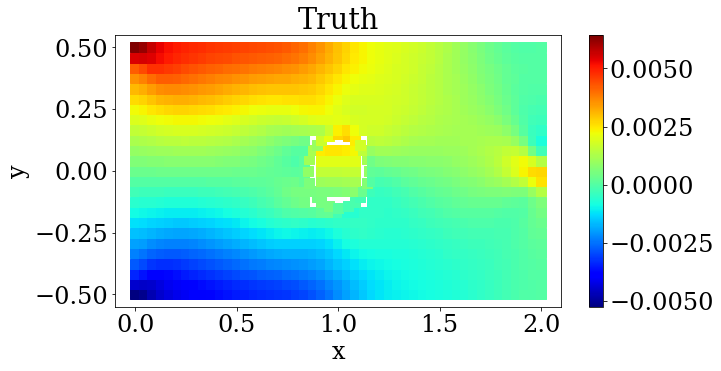

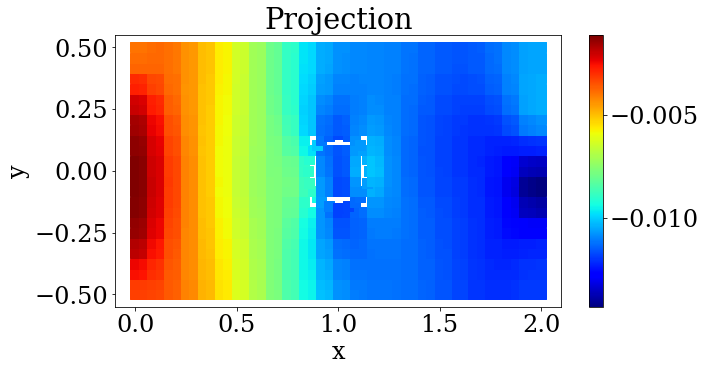

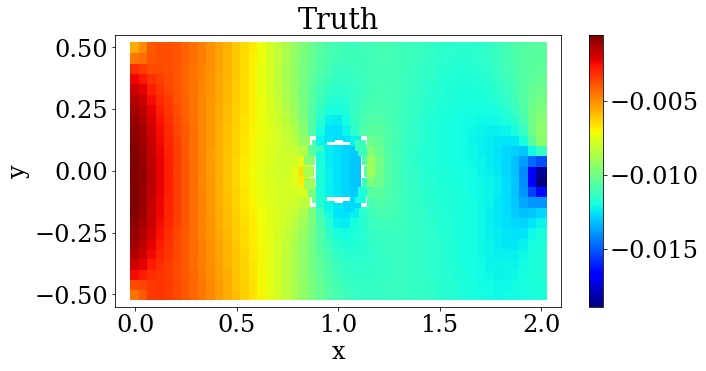

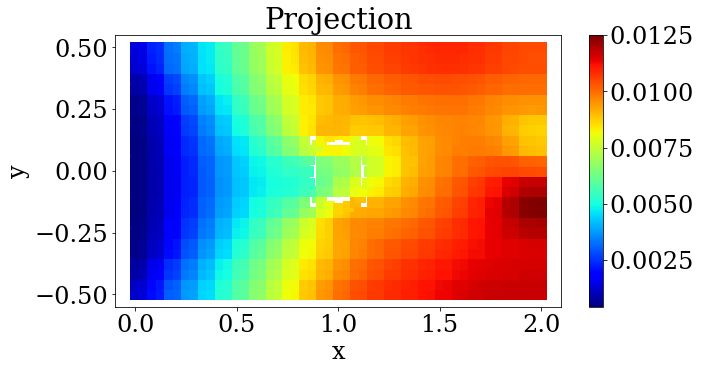

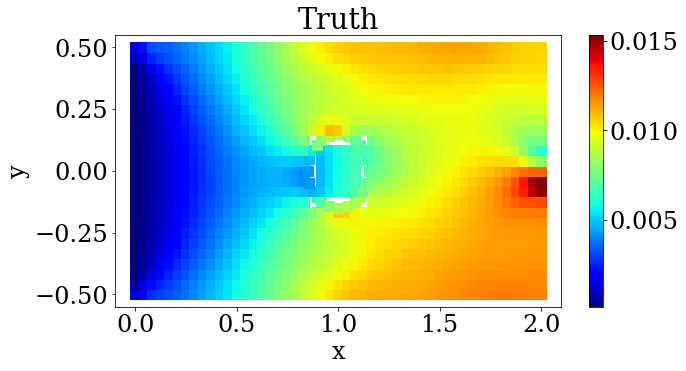

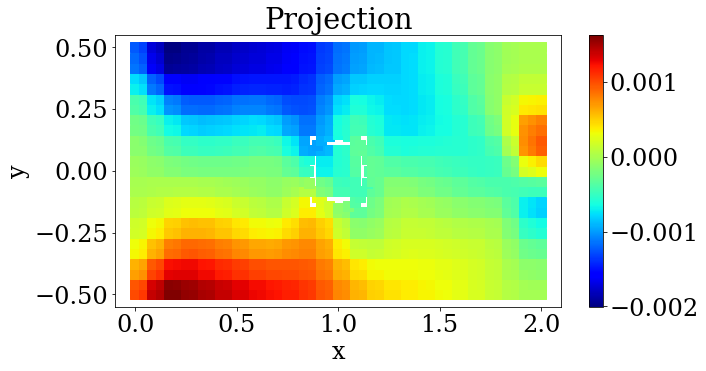

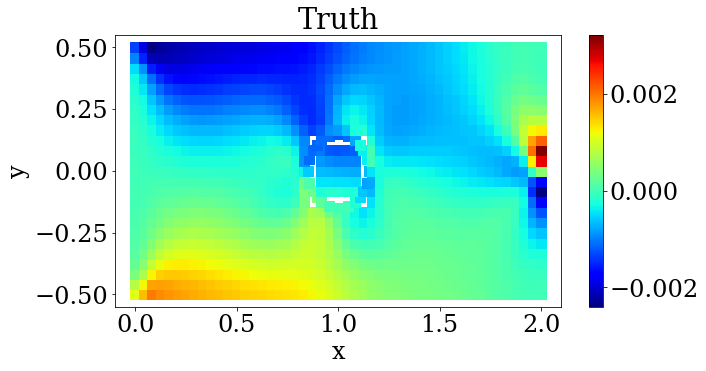

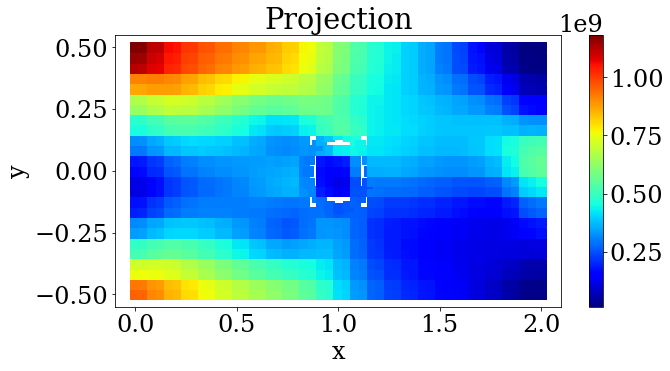

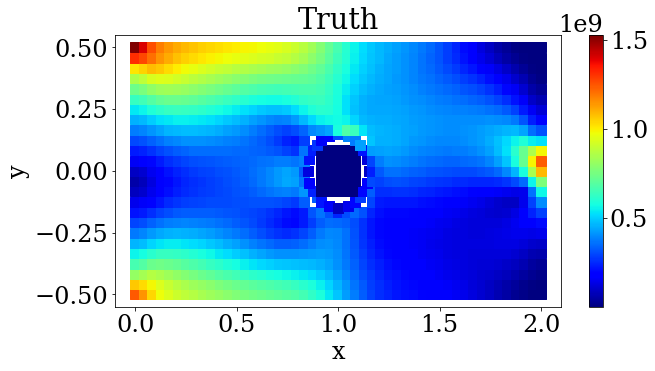

In [51]:
size = 1e2
x, y = np.asarray(mesh_1.coords).T
plot_nodal_vect(x, y, input_graph_1["nodes"][..., 9], "1hots", size)
for i in range(9) :
  plot_nodal_vect(x, y, input_graph_1["nodes"][..., i+10], "Projection", size)
  plot_nodal_vect(x, y, output_graph_1["nodes"][..., i], "Truth", size )

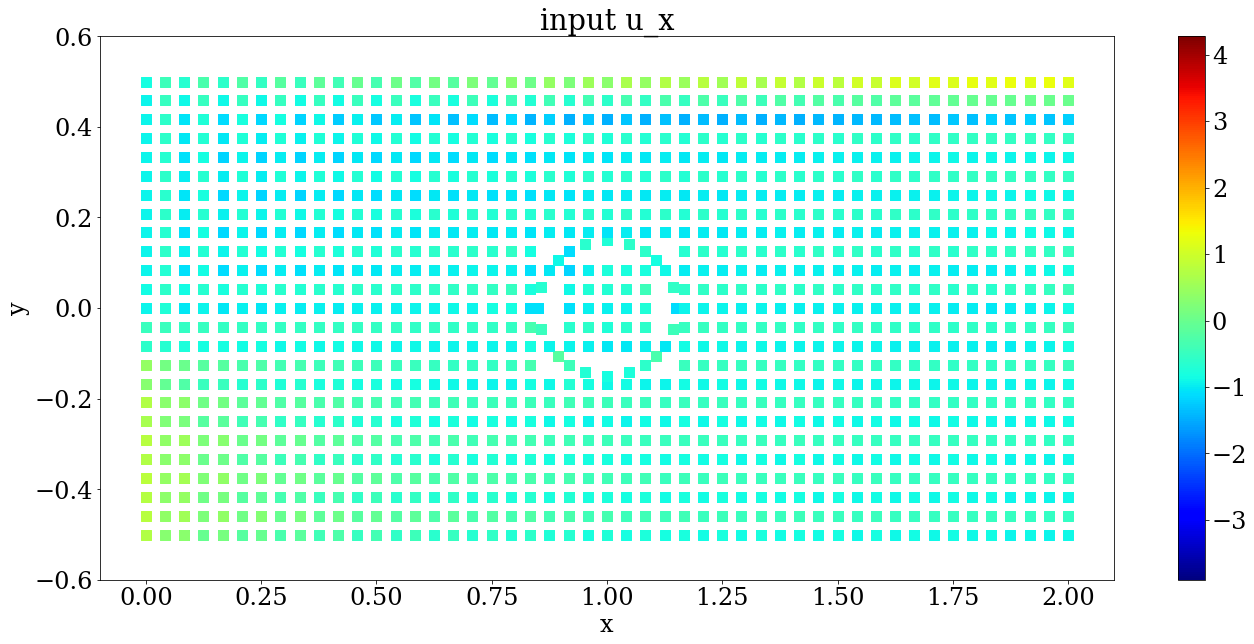

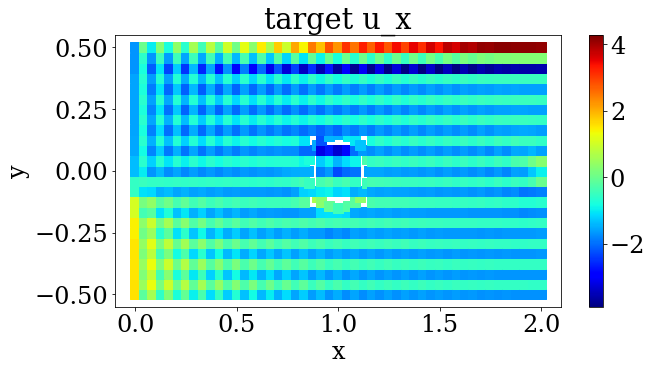

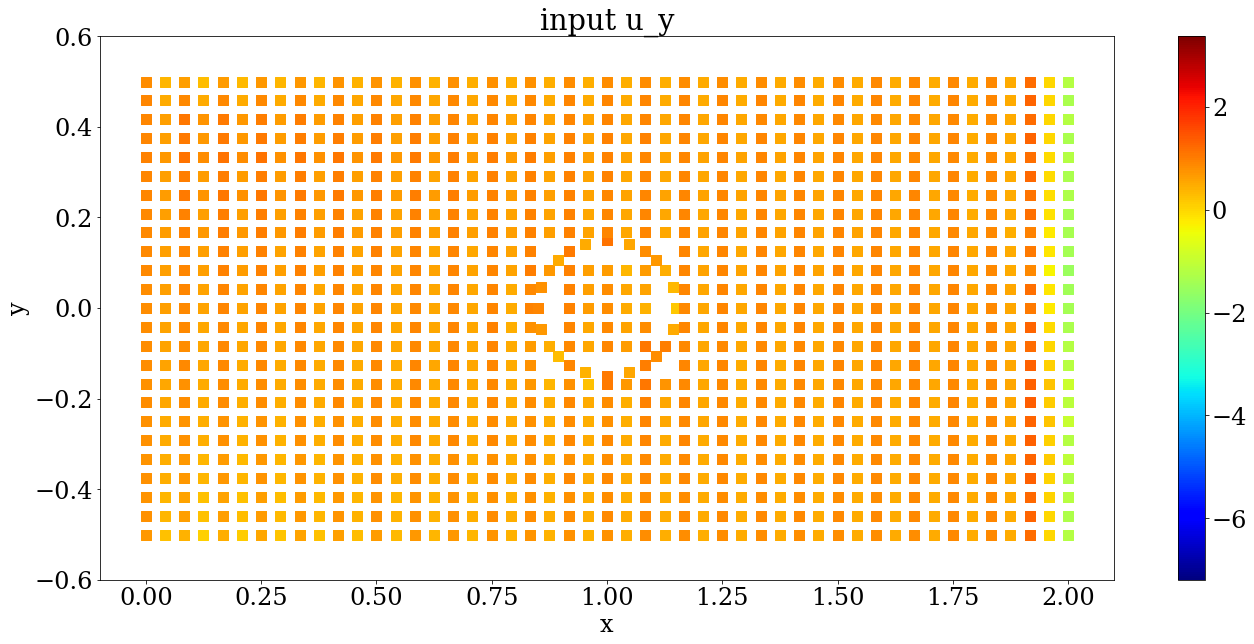

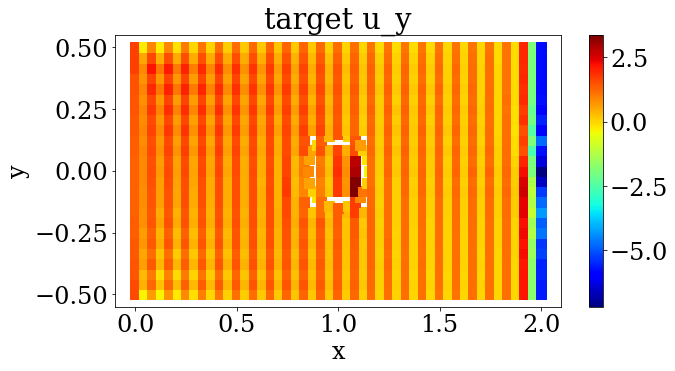

In [52]:
normalized_input_list, local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list = normalize_input_list_informed_multiscale(input_sub_graph_list, [0]*10, [1]*10)
normalized_target_list = local_standard_target(output_sub_graph_list,  local_mean_list, local_std_list)


input_nodes = np.concatenate([item["nodes"]for item in normalized_input_list])
target_nodes = np.concatenate([item["nodes"]for item in normalized_target_list])

plot_capped_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                input_nodes[..., 10], "input u_x", size, np.min(target_nodes[..., 0]), np.max(target_nodes[..., 0]))
plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                target_nodes[..., 0], "target u_x", size)
plot_capped_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                input_nodes[..., 11], "input u_y", size, np.min(target_nodes[..., 1]), np.max(target_nodes[..., 1]))
plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                target_nodes[..., 1], "target u_y", size)

In [53]:
for i, item in enumerate(normalized_input_list) :
  fig = plt.figure(1, figsize=(20, 5))
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title("Checking Sub-Graph Senders, receivers") 
  ax.set_ylabel('y')
  ax.set_xlabel('x')
  for e, (send, rec) in enumerate(zip(item["senders"], item["receivers"])) :
    x0, y0 = item["nodes"][send,0:2]
    x1, y1 = item["nodes"][rec,0:2]
    if e % 2 == 0 :
      ax.plot([x0, x1], [y0, y1], c = 'k')
    else :
      ax.plot([x0, x1], [y0, y1], ':', c = 'b')
  plt.show()
  fig.clf()


Output hidden; open in https://colab.research.google.com to view.

In [54]:
for i, item in enumerate(normalized_input_list) :
  plot_capped_nodal_vect(item["nodes"][..., 0], item["nodes"][..., 1], 
                 item["nodes"][..., 10], "input " + str(i), 3.1e3, -3, 3)

Output hidden; open in https://colab.research.google.com to view.

In [55]:
for item, targ in zip(normalized_input_list, normalized_target_list) :
  plot_nodal_vect(item["nodes"][..., 0], item["nodes"][..., 1], 
                 targ["nodes"][..., 0], "FEA: u_x", 4e3)

Output hidden; open in https://colab.research.google.com to view.

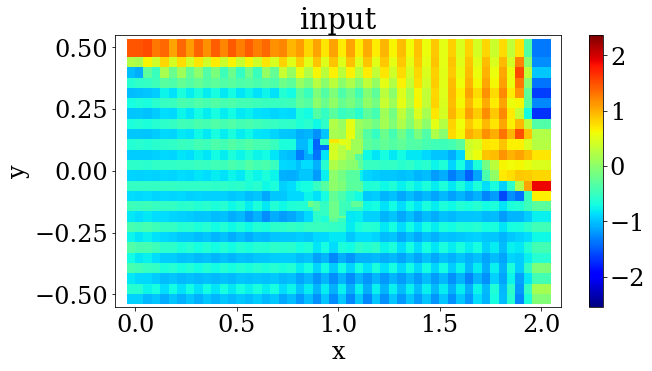

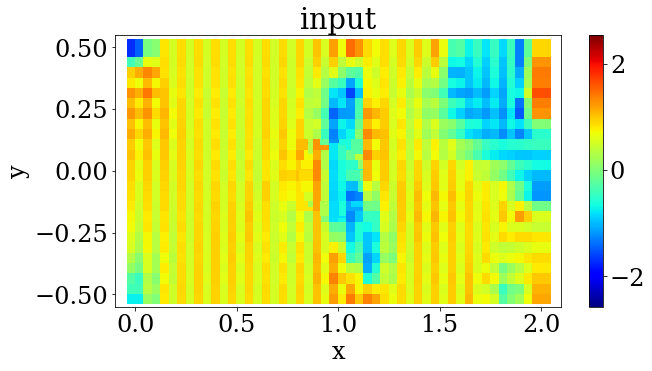

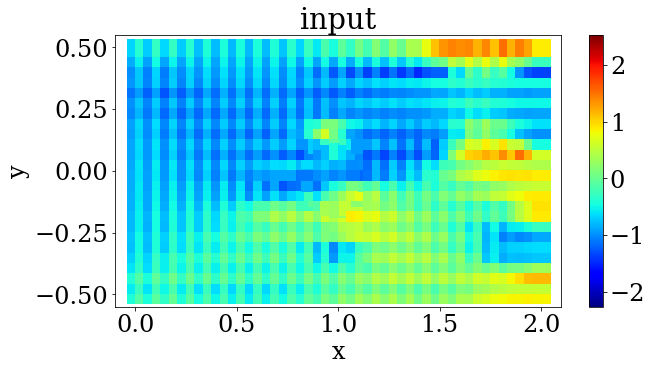

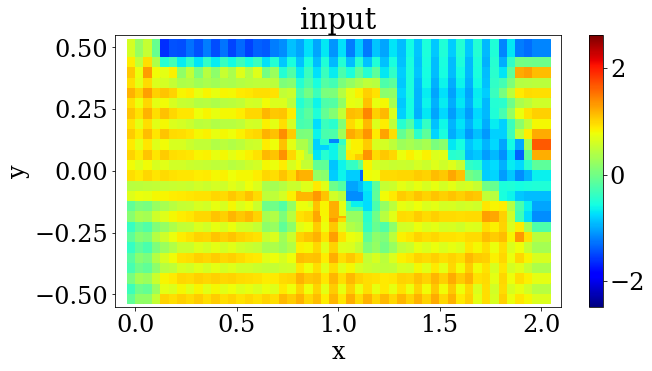

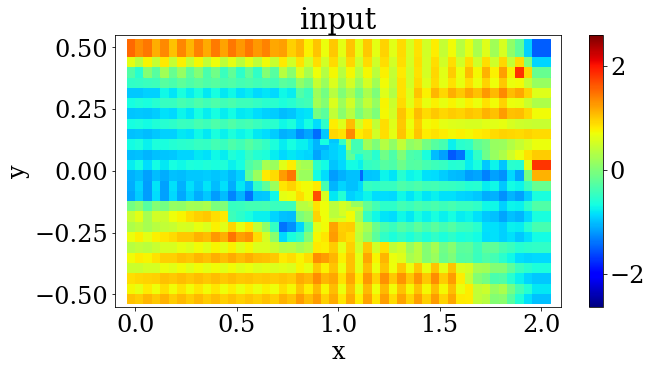

In [56]:
for i in range(5) :
  plot_nodal_vect(input_nodes[..., 0], input_nodes[..., 1], 
                  input_nodes[..., 14 + i], "input", 3e2) 